In [1]:
#### Julia 1.7.3 #####
# using LinearAlgebra
# using PyPlot
# using RandomMatrix
# using ITensors
# # using TensorOperations
using LsqFit
using ITensors, PyPlot, Polynomials

# Numerical many-body methods - Problem Set 3 
## (DMRG)
Noam Ophir

# $J_1-J_2$ spin-1/2 chain
*In this problem we will revisit the spin-1/2 antiferromagnetic $J_1-J_2$ chain discussed in Problem Set 1, given by the Hamiltonian*
$$
H
=
J_1\sum_i\vec{S}_i\cdot\vec{S}_{i+1}+J_2\sum_i\vec{S}_i\cdot\vec{S}_{i+2}
$$
*Recall that the model exhibits a phase transition between a gapless and a dimerized phase at $g_c\simeq 0.241$, where $g$ is the dimensionless ratio $J_2/J_1$.*

*We will now solve the problem using DMRG and employing the ITensor library. In sections 2,3 below use values of $g\leq1/2$. (For $g > 1/2$ the system is still dimerized but exhibitis incommensurate spin-spin correlations, reminiscent of the classical ordering, which can give rise to large finite-size effects.)*

## 1-1
*Generalize the construction of the Heisenberg Hamiltonian discussed in class to allow for a finite $J_2$ term.*

In [2]:
function J1J2Hamiltonian(sites, J2)
    N = length(sites)
    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the 1D quantum system
    for j = 1:N-1
        # Heisenberg interaction term (Sz-Sz)
        ampo += "Sz", j, "Sz", j+1
        # Spin-flip terms (S+, S- and S-, S+) with coupling strength 1/2
        ampo += 1/2, "S+", j, "S-", j+1
        ampo += 1/2, "S-", j, "S+", j+1
    end
    for j = 1:N-2
        # Heisenberg interaction term (Sz-Sz)
        ampo += J2, "Sz", j, "Sz", j+2
        # Spin-flip terms (S+, S- and S-, S+) with coupling strength 1/2
        ampo += J2/2, "S+", j, "S-", j+2
        ampo += J2/2, "S-", j, "S+", j+2
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)
    return H
end

# Number of sites in the 1D quantum system
N = 100

# Generate an index set representing quantum sites with spin S=1/2, conserving quantum numbers
sites = siteinds("S=1/2", N; conserve_qns=true)

J2 = 1.0
H = J1J2Hamiltonian(sites, J2)

MPO
[1] ((dim=5|id=53|"Link,l=1") <Out>
 1: QN() => 1
 2: QN("Sz",0) => 1
 3: QN("Sz",-2) => 1
 4: QN("Sz",2) => 1
 5: QN("Sz",0) => 1, (dim=2|id=401|"S=1/2,Site,n=1")' <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=2|id=401|"S=1/2,Site,n=1") <In>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1)
[2] ((dim=5|id=53|"Link,l=1") <In>
 1: QN() => 1
 2: QN("Sz",0) => 1
 3: QN("Sz",-2) => 1
 4: QN("Sz",2) => 1
 5: QN("Sz",0) => 1, (dim=8|id=481|"Link,l=2") <Out>
 1: QN() => 1
 2: QN("Sz",0) => 2
 3: QN("Sz",-2) => 2
 4: QN("Sz",2) => 2
 5: QN("Sz",0) => 1, (dim=2|id=728|"S=1/2,Site,n=2")' <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=2|id=728|"S=1/2,Site,n=2") <In>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1)
[3] ((dim=8|id=481|"Link,l=2") <In>
 1: QN() => 1
 2: QN("Sz",0) => 2
 3: QN("Sz",-2) => 2
 4: QN("Sz",2) => 2
 5: QN("Sz",0) => 1, (dim=8|id=863|"Link,l=3") <Out>
 1: QN() => 1
 2: QN("Sz",0) => 2
 3: QN("Sz",-2) => 2
 4: QN("Sz",2) => 2
 5: QN("Sz",0) => 1, (dim=2|id=719|"S=1/2,Site

## 1-2
*Perform finite-size scaling of the triplet gap (i.e. the energy gap between the ground state in the $S^z = 0$ sector to the lowest state in the $S^z = 1$ sector) for different values of $g$ across the phase transition. To find the lowest energy state in each $S^z$ sector you will need to make sure that the initial state is in the same $S^z$ sector. You can now easily access system sizes of up to $N = 100$ sites (performing e.g. 10 sweeps with bond dimensions of order 100), but to clearly observe a finite gap for $g > g_c$ it is still advisable to consider values of g close enough to $g = 1/2$.*

In [3]:
Ns = 20:20:100
gs = [0.2, 0.4, 0.6, 0.8]
E_singlet = zeros(length(Ns),length(gs))
E_triplet = zeros(length(Ns),length(gs))

for (i,N) in enumerate(Ns)
    for (j,g) in enumerate(gs)
        sites = siteinds("S=1/2", N; conserve_qns=true)
        H = J1J2Hamiltonian(sites, g)
        
        state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]
        psi0 = productMPS(sites, state0)
        @show flux(psi0)
        E_singlet[i,j],psi = dmrg(H,psi0; nsweeps=10, maxdim=100, cutoff=1E-10)

        state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]
        state0[2] = "Up"

        psi0 = productMPS(sites, state0)
        @show flux(psi0)
        E_triplet[i,j],psi = dmrg(H,psi0; nsweeps=10, maxdim=100, cutoff=1E-10)
    end
end

flux(psi0) = QN("Sz",0)
After sweep 1 energy=-8.003089405267293  maxlinkdim=4 maxerr=1.12E-15 time=31.864


After sweep 2 energy=-8.06375980623002  maxlinkdim=16 maxerr=1.06E-15 time=0.347


After sweep 3 energy=-8.064121355982047  maxlinkdim=36 maxerr=9.87E-11 time=0.390


After sweep 4 energy=-8.064121440962017  maxlinkdim=34 maxerr=9.95E-11 time=0.301


After sweep 5 energy=-8.064121440968703  maxlinkdim=34 maxerr=9.94E-11 time=0.306


After sweep 6 energy=-8.0641214409692  maxlinkdim=34 maxerr=9.94E-11 time=0.303


After sweep 7 energy=-8.06412144096933  maxlinkdim=34 maxerr=9.93E-11 time=0.297


After sweep 8 energy=-8.06412144096935  maxlinkdim=34 maxerr=9.93E-11 time=0.294


After sweep 9 energy=-8.064121440969354  maxlinkdim=34 maxerr=9.93E-11 time=0.297


After sweep 10 energy=-8.064121440969362  maxlinkdim=34 maxerr=9.93E-11 time=0.302


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-7.3660828524631  maxlinkdim=4 maxerr=7.78E-16 time=0.067


After sweep 2 energy=-7.864810248138272  maxlinkdim=16 maxerr=1.11E-15 time=0.219


After sweep 3 energy=-7.89302546234256  maxlinkdim=42 maxerr=9.74E-11 time=0.314


After sweep 4 energy=-7.893053530413833  maxlinkdim=33 maxerr=9.99E-11 time=0.340


After sweep 5 energy=-7.893053531858655  maxlinkdim=33 maxerr=9.92E-11 time=0.295


After sweep 6 energy=-7.893053531777842  maxlinkdim=32 maxerr=9.86E-11 time=0.261


After sweep 7 energy=-7.893053531777864  maxlinkdim=32 maxerr=9.84E-11 time=0.292


After sweep 8 energy=-7.893053531777867  maxlinkdim=32 maxerr=9.84E-11 time=0.291


After sweep 9 energy=-7.89305353177787  maxlinkdim=32 maxerr=9.84E-11 time=0.286


After sweep 10 energy=-7.893053531777867  maxlinkdim=32 maxerr=9.84E-11 time=0.292


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-7.559319649604032  maxlinkdim=4 maxerr=5.05E-16 time=0.072


After sweep 2 energy=-7.587847713988467  maxlinkdim=16 maxerr=9.86E-11 time=0.224


After sweep 3 energy=-7.5879408736782885  maxlinkdim=34 maxerr=9.79E-11 time=0.308


After sweep 4 energy=-7.587941013152365  maxlinkdim=33 maxerr=9.81E-11 time=0.313


After sweep 5 energy=-7.587941013062538  maxlinkdim=32 maxerr=9.89E-11 time=0.282


After sweep 6 energy=-7.587941013062527  maxlinkdim=32 maxerr=9.81E-11 time=0.316


After sweep 7 energy=-7.587941013062554  maxlinkdim=32 maxerr=9.81E-11 time=0.319


After sweep 8 energy=-7.587941013062521  maxlinkdim=32 maxerr=9.81E-11 time=0.322


After sweep 9 energy=-7.587941013062527  maxlinkdim=32 maxerr=9.81E-11 time=0.328


After sweep 10 energy=-7.587941013062529  maxlinkdim=32 maxerr=9.81E-11 time=0.336


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-6.951470283810673  maxlinkdim=4 maxerr=9.44E-16 time=0.075


After sweep 2 energy=-7.335589348497417  maxlinkdim=16 maxerr=1.11E-15 time=0.202


After sweep 3 energy=-7.386162068204272  maxlinkdim=55 maxerr=9.48E-11 time=0.348


After sweep 4 energy=-7.387693016726406  maxlinkdim=59 maxerr=9.79E-11 time=0.448


After sweep 5 energy=-7.3876995047859655  maxlinkdim=37 maxerr=9.84E-11 time=0.383


After sweep 6 energy=-7.387699507447631  maxlinkdim=35 maxerr=9.98E-11 time=0.335


After sweep 7 energy=-7.387699507452098  maxlinkdim=35 maxerr=9.69E-11 time=0.335


After sweep 8 energy=-7.387699507452008  maxlinkdim=35 maxerr=9.68E-11 time=0.410


After sweep 9 energy=-7.3876995074519884  maxlinkdim=35 maxerr=9.68E-11 time=0.332


After sweep 10 energy=-7.38769950745197  maxlinkdim=35 maxerr=9.68E-11 time=0.342


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-7.577877036298358  maxlinkdim=4 maxerr=1.28E-15 time=0.075


After sweep 2 energy=-7.600450732350852  maxlinkdim=16 maxerr=6.53E-11 time=0.202


After sweep 3 energy=-7.6005335237791325  maxlinkdim=43 maxerr=9.60E-11 time=0.310


After sweep 4 energy=-7.60053356462554  maxlinkdim=48 maxerr=9.89E-11 time=0.345


After sweep 5 energy=-7.6005335646336185  maxlinkdim=48 maxerr=9.37E-11 time=0.371


After sweep 6 energy=-7.600533564633638  maxlinkdim=48 maxerr=9.36E-11 time=0.343


After sweep 7 energy=-7.6005335646336665  maxlinkdim=48 maxerr=9.36E-11 time=0.352


After sweep 8 energy=-7.600533564633658  maxlinkdim=48 maxerr=9.36E-11 time=0.369


After sweep 9 energy=-7.600533564633658  maxlinkdim=48 maxerr=9.36E-11 time=0.343


After sweep 10 energy=-7.600533564633658  maxlinkdim=48 maxerr=9.36E-11 time=0.374


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-6.839641682634562  maxlinkdim=4 maxerr=1.11E-15 time=0.073


After sweep 2 energy=-7.050718820130137  maxlinkdim=16 maxerr=4.84E-11 time=0.193


After sweep 3 energy=-7.108024107114645  maxlinkdim=61 maxerr=9.95E-11 time=0.321


After sweep 4 energy=-7.123668988870651  maxlinkdim=100 maxerr=1.46E-09 time=0.555


After sweep 5 energy=-7.131603542208802  maxlinkdim=100 maxerr=1.92E-09 time=0.614


After sweep 6 energy=-7.133279956545821  maxlinkdim=100 maxerr=9.89E-10 time=0.584


After sweep 7 energy=-7.133483806252246  maxlinkdim=100 maxerr=3.71E-10 time=0.589


After sweep 8 energy=-7.133514041189066  maxlinkdim=100 maxerr=1.38E-10 time=0.583


After sweep 9 energy=-7.133521249849082  maxlinkdim=93 maxerr=9.65E-11 time=0.529


After sweep 10 energy=-7.133523470600508  maxlinkdim=88 maxerr=9.92E-11 time=0.535


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-8.124208511821742  maxlinkdim=4 maxerr=1.06E-15 time=0.078


After sweep 2 energy=-8.329911562988908  maxlinkdim=16 maxerr=2.83E-11 time=0.207


After sweep 3 energy=-8.33260535410012  maxlinkdim=59 maxerr=8.83E-11 time=0.570


After sweep 4 energy=-8.33261070202145  maxlinkdim=97 maxerr=9.99E-11 time=0.448


After sweep 5 energy=-8.332610701715744  maxlinkdim=95 maxerr=9.96E-11 time=0.479


After sweep 6 energy=-8.332610701715405  maxlinkdim=95 maxerr=9.75E-11 time=0.471


After sweep 7 energy=-8.33261070171542  maxlinkdim=95 maxerr=9.75E-11 time=0.494


After sweep 8 energy=-8.332610701715435  maxlinkdim=95 maxerr=9.75E-11 time=0.488


After sweep 9 energy=-8.332610701715415  maxlinkdim=95 maxerr=9.75E-11 time=0.491


After sweep 10 energy=-8.332610701715414  maxlinkdim=95 maxerr=9.75E-11 time=0.505


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-7.251760776006333  maxlinkdim=4 maxerr=8.90E-16 time=0.071


After sweep 2 energy=-7.582561923561645  maxlinkdim=16 maxerr=1.77E-11 time=0.188


After sweep 3 energy=-7.805241182905556  maxlinkdim=64 maxerr=7.55E-11 time=0.317


After sweep 4 energy=-7.823134681828674  maxlinkdim=100 maxerr=1.35E-08 time=0.564


After sweep 5 energy=-7.823828740724192  maxlinkdim=100 maxerr=7.92E-09 time=0.621


After sweep 6 energy=-7.823934608061772  maxlinkdim=100 maxerr=4.17E-09 time=0.646


After sweep 7 energy=-7.823970418850336  maxlinkdim=100 maxerr=2.95E-09 time=0.655


After sweep 8 energy=-7.823982720351766  maxlinkdim=100 maxerr=2.49E-09 time=0.689


After sweep 9 energy=-7.823986176179306  maxlinkdim=100 maxerr=5.38E-09 time=0.695


After sweep 10 energy=-7.823986835184858  maxlinkdim=100 maxerr=3.35E-09 time=0.693


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-16.124715451022915  maxlinkdim=4 maxerr=1.06E-15 time=0.234


After sweep 2 energy=-16.22622257512107  maxlinkdim=16 maxerr=1.00E-15 time=0.578


After sweep 3 energy=-16.23062305442994  maxlinkdim=52 maxerr=9.87E-11 time=1.072


After sweep 4 energy=-16.23066039871148  maxlinkdim=63 maxerr=9.85E-11 time=1.337


After sweep 5 energy=-16.230660465250374  maxlinkdim=57 maxerr=9.96E-11 time=1.174


After sweep 6 energy=-16.230660465335703  maxlinkdim=57 maxerr=9.94E-11 time=1.290


After sweep 7 energy=-16.230660465429825  maxlinkdim=57 maxerr=9.93E-11 time=1.236


After sweep 8 energy=-16.230660465429775  maxlinkdim=57 maxerr=9.93E-11 time=1.159


After sweep 9 energy=-16.230660465429782  maxlinkdim=57 maxerr=9.93E-11 time=1.021


After sweep 10 energy=-16.230660465429793  maxlinkdim=57 maxerr=9.93E-11 time=1.137


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-15.470681641614021  maxlinkdim=4 maxerr=8.34E-16 time=0.255


After sweep 2 energy=-16.055588448174667  maxlinkdim=16 maxerr=9.06E-11 time=0.482


After sweep 3 energy=-16.13842304422252  maxlinkdim=54 maxerr=9.96E-11 time=0.837


After sweep 4 energy=-16.1417900789208  maxlinkdim=69 maxerr=9.99E-11 time=1.090


After sweep 5 energy=-16.14182375861663  maxlinkdim=68 maxerr=9.87E-11 time=1.154


After sweep 6 energy=-16.14182376729048  maxlinkdim=56 maxerr=9.99E-11 time=0.903


After sweep 7 energy=-16.141823766947414  maxlinkdim=56 maxerr=9.98E-11 time=0.885


After sweep 8 energy=-16.141823766948303  maxlinkdim=56 maxerr=9.94E-11 time=0.895


After sweep 9 energy=-16.141823766948356  maxlinkdim=56 maxerr=9.93E-11 time=0.915


After sweep 10 energy=-16.141823766948345  maxlinkdim=56 maxerr=9.93E-11 time=0.902


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-15.10986963207957  maxlinkdim=4 maxerr=1.00E-15 time=0.190


After sweep 2 energy=-15.194161723059539  maxlinkdim=16 maxerr=6.14E-16 time=0.461


After sweep 3 energy=-15.195206677026107  maxlinkdim=48 maxerr=9.85E-11 time=0.875


After sweep 4 energy=-15.195227050057971  maxlinkdim=55 maxerr=9.94E-11 time=0.988


After sweep 5 energy=-15.195227212709334  maxlinkdim=52 maxerr=9.93E-11 time=0.872


After sweep 6 energy=-15.195227212117828  maxlinkdim=49 maxerr=9.99E-11 time=0.815


After sweep 7 energy=-15.195227212170359  maxlinkdim=49 maxerr=9.84E-11 time=0.816


After sweep 8 energy=-15.195227212177182  maxlinkdim=49 maxerr=9.84E-11 time=0.822


After sweep 9 energy=-15.195227212178809  maxlinkdim=49 maxerr=9.83E-11 time=0.801


After sweep 10 energy=-15.195227212180285  maxlinkdim=49 maxerr=9.83E-11 time=0.801


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-14.501356990076584  maxlinkdim=4 maxerr=7.77E-16 time=0.184


After sweep 2 energy=-14.947865542433124  maxlinkdim=16 maxerr=9.45E-16 time=0.458


After sweep 3 energy=-15.046163875398987  maxlinkdim=56 maxerr=9.92E-11 time=0.858


After sweep 4 energy=-15.069640148564748  maxlinkdim=97 maxerr=9.96E-11 time=1.381


After sweep 5 energy=-15.073368812839027  maxlinkdim=97 maxerr=9.99E-11 time=1.493


After sweep 6 energy=-15.073791019925967  maxlinkdim=91 maxerr=1.00E-10 time=1.411


After sweep 7 energy=-15.07381936147602  maxlinkdim=84 maxerr=9.95E-11 time=1.357


After sweep 8 energy=-15.073819549061653  maxlinkdim=62 maxerr=9.99E-11 time=1.094


After sweep 9 energy=-15.073819548332155  maxlinkdim=61 maxerr=9.95E-11 time=1.116


After sweep 10 energy=-15.073819548340701  maxlinkdim=61 maxerr=9.84E-11 time=1.164


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-15.165010210945876  maxlinkdim=4 maxerr=1.00E-15 time=0.185


After sweep 2 energy=-15.216479716944363  maxlinkdim=16 maxerr=6.54E-11 time=0.499


After sweep 3 energy=-15.216730617163401  maxlinkdim=45 maxerr=9.87E-11 time=0.795


After sweep 4 energy=-15.216730839487683  maxlinkdim=52 maxerr=9.97E-11 time=0.995


After sweep 5 energy=-15.216730838973357  maxlinkdim=52 maxerr=9.99E-11 time=0.975


After sweep 6 energy=-15.21673083907888  maxlinkdim=52 maxerr=9.97E-11 time=0.982


After sweep 7 energy=-15.2167308390774  maxlinkdim=52 maxerr=9.97E-11 time=1.033


After sweep 8 energy=-15.216730839074915  maxlinkdim=52 maxerr=9.97E-11 time=0.963


After sweep 9 energy=-15.216730839071323  maxlinkdim=52 maxerr=9.97E-11 time=1.077


After sweep 10 energy=-15.216730839068264  maxlinkdim=52 maxerr=9.96E-11 time=1.111


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-14.426774848561829  maxlinkdim=4 maxerr=1.00E-15 time=0.271


After sweep 2 energy=-14.666758612253123  maxlinkdim=16 maxerr=6.54E-11 time=0.479


After sweep 3 energy=-14.725080220281338  maxlinkdim=60 maxerr=9.95E-11 time=0.790


After sweep 4 energy=-14.745276605266007  maxlinkdim=100 maxerr=1.88E-10 time=1.427


After sweep 5 energy=-14.756056823789624  maxlinkdim=100 maxerr=1.50E-09 time=1.708


After sweep 6 energy=-14.762086984013457  maxlinkdim=100 maxerr=2.51E-09 time=1.679


After sweep 7 energy=-14.765233126361311  maxlinkdim=100 maxerr=2.85E-09 time=1.819


After sweep 8 energy=-14.766805158020167  maxlinkdim=100 maxerr=4.31E-09 time=1.780


After sweep 9 energy=-14.767592236195188  maxlinkdim=100 maxerr=3.79E-09 time=2.367


After sweep 10 energy=-14.768002744518707  maxlinkdim=100 maxerr=3.18E-09 time=1.783


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-16.31187955327843  maxlinkdim=4 maxerr=7.81E-16 time=0.269


After sweep 2 energy=-16.75900808451543  maxlinkdim=16 maxerr=2.25E-11 time=0.475


After sweep 3 energy=-16.766908158027647  maxlinkdim=60 maxerr=9.81E-11 time=0.878


After sweep 4 energy=-16.76696688511633  maxlinkdim=100 maxerr=4.13E-10 time=1.657


After sweep 5 energy=-16.76696700148155  maxlinkdim=100 maxerr=7.03E-10 time=1.882


After sweep 6 energy=-16.766967001642517  maxlinkdim=100 maxerr=5.93E-10 time=1.748


After sweep 7 energy=-16.76696700177356  maxlinkdim=100 maxerr=5.94E-10 time=1.809


After sweep 8 energy=-16.76696700182155  maxlinkdim=100 maxerr=5.95E-10 time=1.832


After sweep 9 energy=-16.766967001919063  maxlinkdim=100 maxerr=5.95E-10 time=1.739


After sweep 10 energy=-16.76696700191956  maxlinkdim=100 maxerr=5.95E-10 time=1.839


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-15.440197752198207  maxlinkdim=4 maxerr=1.06E-15 time=0.172


After sweep 2 energy=-16.011500966664045  maxlinkdim=16 maxerr=9.35E-11 time=0.457


After sweep 3 energy=-16.247196684819748  maxlinkdim=64 maxerr=9.69E-11 time=0.816


After sweep 4 energy=-16.3194552574548  maxlinkdim=100 maxerr=1.50E-08 time=1.665


After sweep 5 energy=-16.33386467525041  maxlinkdim=100 maxerr=2.70E-08 time=1.781


After sweep 6 energy=-16.33593396474661  maxlinkdim=100 maxerr=2.50E-08 time=1.907


After sweep 7 energy=-16.336144339308518  maxlinkdim=100 maxerr=1.62E-07 time=1.989


After sweep 8 energy=-16.336167029017677  maxlinkdim=100 maxerr=8.44E-08 time=1.899


After sweep 9 energy=-16.336171235723256  maxlinkdim=100 maxerr=4.64E-08 time=2.044


After sweep 10 energy=-16.33617260875856  maxlinkdim=100 maxerr=4.10E-08 time=2.009


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-24.25108564956238  maxlinkdim=4 maxerr=7.30E-16 time=0.279


After sweep 2 energy=-24.389705268224862  maxlinkdim=16 maxerr=6.12E-11 time=0.780


After sweep 3 energy=-24.399103072191508  maxlinkdim=53 maxerr=9.86E-11 time=1.319


After sweep 4 energy=-24.399543216994882  maxlinkdim=77 maxerr=9.99E-11 time=1.948


After sweep 5 energy=-24.399549254761425  maxlinkdim=76 maxerr=9.98E-11 time=2.154


After sweep 6 energy=-24.399549260530744  maxlinkdim=73 maxerr=9.97E-11 time=2.427


After sweep 7 energy=-24.39954926051785  maxlinkdim=73 maxerr=9.93E-11 time=1.886


After sweep 8 energy=-24.399549260517425  maxlinkdim=73 maxerr=9.97E-11 time=1.744


After sweep 9 energy=-24.399549260517457  maxlinkdim=73 maxerr=9.97E-11 time=1.820


After sweep 10 energy=-24.3995492605174  maxlinkdim=73 maxerr=9.97E-11 time=1.871


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-23.596566122318357  maxlinkdim=4 maxerr=9.45E-16 time=0.267


After sweep 2 energy=-24.21216533398718  maxlinkdim=16 maxerr=7.62E-11 time=0.735


After sweep 3 energy=-24.32469865171824  maxlinkdim=55 maxerr=9.99E-11 time=1.392


After sweep 4 energy=-24.338126199994015  maxlinkdim=79 maxerr=9.99E-11 time=1.804


After sweep 5 energy=-24.33949053311686  maxlinkdim=81 maxerr=9.95E-11 time=2.107


After sweep 6 energy=-24.33951994622417  maxlinkdim=91 maxerr=9.99E-11 time=2.056


After sweep 7 energy=-24.339520144311397  maxlinkdim=73 maxerr=9.99E-11 time=1.872


After sweep 8 energy=-24.339520143238435  maxlinkdim=73 maxerr=1.00E-10 time=1.866


After sweep 9 energy=-24.33952014324074  maxlinkdim=73 maxerr=9.97E-11 time=1.933


After sweep 10 energy=-24.33952014317615  maxlinkdim=73 maxerr=9.99E-11 time=1.804


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-22.65787096115685  maxlinkdim=4 maxerr=7.78E-16 time=0.341


After sweep 2 energy=-22.800799094546772  maxlinkdim=16 maxerr=9.42E-11 time=0.744


After sweep 3 energy=-22.802708861590546  maxlinkdim=51 maxerr=9.99E-11 time=1.339


After sweep 4 energy=-22.802794915981885  maxlinkdim=61 maxerr=9.95E-11 time=1.662


After sweep 5 energy=-22.802798298025166  maxlinkdim=68 maxerr=9.98E-11 time=1.732


After sweep 6 energy=-22.80279837374477  maxlinkdim=62 maxerr=1.00E-10 time=1.681


After sweep 7 energy=-22.802798373066285  maxlinkdim=60 maxerr=9.97E-11 time=1.515


After sweep 8 energy=-22.802798373256277  maxlinkdim=60 maxerr=9.95E-11 time=1.632


After sweep 9 energy=-22.80279837325568  maxlinkdim=60 maxerr=9.91E-11 time=1.593


After sweep 10 energy=-22.802798373272793  maxlinkdim=60 maxerr=9.93E-11 time=1.567


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-22.048034546356387  maxlinkdim=4 maxerr=5.57E-16 time=0.331


After sweep 2 energy=-22.552723384134854  maxlinkdim=16 maxerr=8.88E-16 time=0.717


After sweep 3 energy=-22.653516501880606  maxlinkdim=57 maxerr=9.97E-11 time=1.291


After sweep 4 energy=-22.68633746182652  maxlinkdim=87 maxerr=9.98E-11 time=2.008


After sweep 5 energy=-22.70177649709708  maxlinkdim=100 maxerr=1.21E-10 time=2.320


After sweep 6 energy=-22.70704549160288  maxlinkdim=99 maxerr=9.97E-11 time=2.255


After sweep 7 energy=-22.70877730142298  maxlinkdim=100 maxerr=9.94E-11 time=2.428


After sweep 8 energy=-22.709299079440896  maxlinkdim=96 maxerr=1.08E-10 time=2.316


After sweep 9 energy=-22.70942393526424  maxlinkdim=91 maxerr=9.99E-11 time=2.152


After sweep 10 energy=-22.709455384745457  maxlinkdim=85 maxerr=9.99E-11 time=2.660


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-22.752143385781892  maxlinkdim=4 maxerr=1.22E-15 time=0.259


After sweep 2 energy=-22.832508712666232  maxlinkdim=16 maxerr=6.54E-11 time=0.780


After sweep 3 energy=-22.832927644161288  maxlinkdim=45 maxerr=9.86E-11 time=1.172


After sweep 4 energy=-22.832928142579178  maxlinkdim=53 maxerr=9.98E-11 time=1.584


After sweep 5 energy=-22.832928142087734  maxlinkdim=53 maxerr=1.00E-10 time=1.538


After sweep 6 energy=-22.832928142206768  maxlinkdim=53 maxerr=9.97E-11 time=1.653


After sweep 7 energy=-22.832928142091482  maxlinkdim=53 maxerr=9.99E-11 time=1.701


After sweep 8 energy=-22.832928141978716  maxlinkdim=53 maxerr=9.97E-11 time=1.630


After sweep 9 energy=-22.832928141709772  maxlinkdim=53 maxerr=9.95E-11 time=1.720


After sweep 10 energy=-22.832928141754245  maxlinkdim=53 maxerr=9.92E-11 time=1.747


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-22.01390802339787  maxlinkdim=4 maxerr=1.00E-15 time=0.283


After sweep 2 energy=-22.28278760795522  maxlinkdim=16 maxerr=6.54E-11 time=0.749


After sweep 3 energy=-22.340941307151603  maxlinkdim=59 maxerr=9.93E-11 time=1.309


After sweep 4 energy=-22.360036303946277  maxlinkdim=100 maxerr=1.38E-10 time=2.036


After sweep 5 energy=-22.370995327938175  maxlinkdim=100 maxerr=9.03E-10 time=2.405


After sweep 6 energy=-22.37835685682543  maxlinkdim=100 maxerr=1.92E-09 time=2.556


After sweep 7 energy=-22.383299543755108  maxlinkdim=100 maxerr=2.57E-09 time=2.558


After sweep 8 energy=-22.386794473329946  maxlinkdim=100 maxerr=3.38E-09 time=2.664


After sweep 9 energy=-22.38938508976925  maxlinkdim=100 maxerr=4.71E-09 time=2.719


After sweep 10 energy=-22.391396822783058  maxlinkdim=100 maxerr=5.83E-09 time=2.751


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-24.500653833845462  maxlinkdim=4 maxerr=8.92E-16 time=0.353


After sweep 2 energy=-25.1881030309869  maxlinkdim=16 maxerr=2.25E-11 time=0.739


After sweep 3 energy=-25.201212501115776  maxlinkdim=60 maxerr=9.99E-11 time=1.386


After sweep 4 energy=-25.201331817046594  maxlinkdim=100 maxerr=4.30E-10 time=2.744


After sweep 5 energy=-25.20133230673624  maxlinkdim=100 maxerr=9.49E-10 time=3.251


After sweep 6 energy=-25.20133230781185  maxlinkdim=100 maxerr=7.60E-10 time=3.675


After sweep 7 energy=-25.20133230765286  maxlinkdim=100 maxerr=7.63E-10 time=2.891


After sweep 8 energy=-25.201332307862522  maxlinkdim=100 maxerr=7.63E-10 time=2.945


After sweep 9 energy=-25.201332307920236  maxlinkdim=100 maxerr=7.63E-10 time=3.015


After sweep 10 energy=-25.201332307924794  maxlinkdim=100 maxerr=7.63E-10 time=2.856


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-23.62931315098462  maxlinkdim=4 maxerr=1.00E-15 time=0.254


After sweep 2 energy=-24.4405954816565  maxlinkdim=16 maxerr=7.99E-12 time=0.795


After sweep 3 energy=-24.681504940704315  maxlinkdim=64 maxerr=9.93E-11 time=1.352


After sweep 4 energy=-24.757811274235596  maxlinkdim=100 maxerr=1.66E-08 time=2.777


After sweep 5 energy=-24.782618837364225  maxlinkdim=100 maxerr=1.88E-08 time=3.231


After sweep 6 energy=-24.793208241729687  maxlinkdim=100 maxerr=2.11E-08 time=3.243


After sweep 7 energy=-24.79761665028114  maxlinkdim=100 maxerr=2.60E-08 time=3.421


After sweep 8 energy=-24.79930158628453  maxlinkdim=100 maxerr=9.49E-07 time=3.391


After sweep 9 energy=-24.79988704823214  maxlinkdim=100 maxerr=7.72E-07 time=3.371


After sweep 10 energy=-24.800121355595625  maxlinkdim=100 maxerr=2.00E-07 time=3.683


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-32.377591528354806  maxlinkdim=4 maxerr=5.87E-16 time=0.361


After sweep 2 energy=-32.5548424686966  maxlinkdim=16 maxerr=9.92E-11 time=1.060


After sweep 3 energy=-32.56767579600362  maxlinkdim=54 maxerr=9.97E-11 time=1.617


After sweep 4 energy=-32.56898267123579  maxlinkdim=78 maxerr=1.00E-10 time=2.413


After sweep 5 energy=-32.569056538423766  maxlinkdim=82 maxerr=9.99E-11 time=2.814


After sweep 6 energy=-32.569057498801975  maxlinkdim=88 maxerr=1.00E-10 time=2.947


After sweep 7 energy=-32.56905750143485  maxlinkdim=86 maxerr=1.00E-10 time=3.085


After sweep 8 energy=-32.569057501407926  maxlinkdim=86 maxerr=9.99E-11 time=3.090


After sweep 9 energy=-32.56905750164681  maxlinkdim=86 maxerr=9.99E-11 time=3.026


After sweep 10 energy=-32.56905750153321  maxlinkdim=86 maxerr=9.95E-11 time=2.853


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-31.72305825411847  maxlinkdim=4 maxerr=1.11E-15 time=0.428


After sweep 2 energy=-32.37087572873869  maxlinkdim=16 maxerr=7.51E-11 time=0.966


After sweep 3 energy=-32.49482000907509  maxlinkdim=54 maxerr=1.00E-10 time=1.841


After sweep 4 energy=-32.51577521276355  maxlinkdim=78 maxerr=9.99E-11 time=2.418


After sweep 5 energy=-32.52222259515023  maxlinkdim=88 maxerr=9.99E-11 time=2.661


After sweep 6 energy=-32.52359004484542  maxlinkdim=90 maxerr=9.98E-11 time=2.815


After sweep 7 energy=-32.52371231949541  maxlinkdim=82 maxerr=1.00E-10 time=2.917


After sweep 8 energy=-32.52371551821947  maxlinkdim=90 maxerr=1.50E-10 time=3.071


After sweep 9 energy=-32.52371552664041  maxlinkdim=85 maxerr=9.99E-11 time=2.992


After sweep 10 energy=-32.52371552638375  maxlinkdim=85 maxerr=9.98E-11 time=3.294


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-30.207401998593475  maxlinkdim=4 maxerr=4.49E-16 time=0.422


After sweep 2 energy=-30.40741818255653  maxlinkdim=16 maxerr=5.84E-11 time=0.948


After sweep 3 energy=-30.410238271830806  maxlinkdim=51 maxerr=1.00E-10 time=1.751


After sweep 4 energy=-30.410391741771726  maxlinkdim=66 maxerr=9.99E-11 time=2.210


After sweep 5 energy=-30.410401374200944  maxlinkdim=71 maxerr=9.99E-11 time=2.243


After sweep 6 energy=-30.410402033563248  maxlinkdim=72 maxerr=1.00E-10 time=2.404


After sweep 7 energy=-30.410402038859228  maxlinkdim=67 maxerr=9.98E-11 time=2.454


After sweep 8 energy=-30.410402038719425  maxlinkdim=67 maxerr=9.98E-11 time=2.391


After sweep 9 energy=-30.410402038832824  maxlinkdim=67 maxerr=9.95E-11 time=2.497


After sweep 10 energy=-30.41040203879014  maxlinkdim=67 maxerr=9.95E-11 time=2.483


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-29.596578093663425  maxlinkdim=4 maxerr=9.99E-16 time=0.364


After sweep 2 energy=-30.159284286137  maxlinkdim=16 maxerr=3.73E-11 time=1.012


After sweep 3 energy=-30.260202882884222  maxlinkdim=57 maxerr=9.99E-11 time=1.875


After sweep 4 energy=-30.29356211353701  maxlinkdim=89 maxerr=1.00E-10 time=2.528


After sweep 5 energy=-30.30946860307708  maxlinkdim=99 maxerr=9.98E-11 time=2.760


After sweep 6 energy=-30.319623463619536  maxlinkdim=97 maxerr=9.95E-11 time=2.761


After sweep 7 energy=-30.325368092827876  maxlinkdim=96 maxerr=9.98E-11 time=2.696


After sweep 8 energy=-30.328430092621222  maxlinkdim=96 maxerr=9.99E-11 time=2.859


After sweep 9 energy=-30.33017950442208  maxlinkdim=90 maxerr=9.99E-11 time=3.043


After sweep 10 energy=-30.330950827553018  maxlinkdim=80 maxerr=1.00E-10 time=3.151


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-30.33927656061794  maxlinkdim=4 maxerr=1.22E-15 time=0.376


After sweep 2 energy=-30.448537708387967  maxlinkdim=16 maxerr=6.54E-11 time=0.989


After sweep 3 energy=-30.449124641204367  maxlinkdim=45 maxerr=9.86E-11 time=1.920


After sweep 4 energy=-30.449125445668965  maxlinkdim=53 maxerr=9.97E-11 time=2.225


After sweep 5 energy=-30.449125445450687  maxlinkdim=53 maxerr=1.00E-10 time=2.330


After sweep 6 energy=-30.449125445539934  maxlinkdim=53 maxerr=9.97E-11 time=2.321


After sweep 7 energy=-30.44912544541847  maxlinkdim=53 maxerr=9.99E-11 time=2.201


After sweep 8 energy=-30.449125445305928  maxlinkdim=53 maxerr=9.96E-11 time=2.307


After sweep 9 energy=-30.449125444982364  maxlinkdim=53 maxerr=9.95E-11 time=2.751


After sweep 10 energy=-30.44912544503002  maxlinkdim=53 maxerr=9.92E-11 time=2.156


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-29.60104119823385  maxlinkdim=4 maxerr=1.06E-15 time=0.426


After sweep 2 energy=-29.898816603676856  maxlinkdim=16 maxerr=6.54E-11 time=0.927


After sweep 3 energy=-29.956940303546038  maxlinkdim=59 maxerr=9.86E-11 time=1.594


After sweep 4 energy=-29.9747988451617  maxlinkdim=100 maxerr=9.98E-11 time=2.486


After sweep 5 energy=-29.985902190340486  maxlinkdim=100 maxerr=8.87E-10 time=2.897


After sweep 6 energy=-29.99372049336562  maxlinkdim=100 maxerr=3.09E-09 time=3.092


After sweep 7 energy=-29.9995508594538  maxlinkdim=100 maxerr=4.83E-09 time=3.490


After sweep 8 energy=-30.00356595386112  maxlinkdim=100 maxerr=5.52E-09 time=3.540


After sweep 9 energy=-30.00637771305789  maxlinkdim=100 maxerr=3.52E-09 time=3.577


After sweep 10 energy=-30.008743794297633  maxlinkdim=100 maxerr=2.75E-09 time=3.889


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-32.68960017414323  maxlinkdim=4 maxerr=5.58E-16 time=0.340


After sweep 2 energy=-33.61719782699426  maxlinkdim=16 maxerr=2.25E-11 time=0.957


After sweep 3 energy=-33.635517201240575  maxlinkdim=60 maxerr=1.00E-10 time=1.908


After sweep 4 energy=-33.63569674004758  maxlinkdim=100 maxerr=4.35E-10 time=3.620


After sweep 5 energy=-33.63569763647733  maxlinkdim=100 maxerr=9.94E-10 time=4.205


After sweep 6 energy=-33.635697638716216  maxlinkdim=100 maxerr=7.82E-10 time=4.711


After sweep 7 energy=-33.63569763842268  maxlinkdim=100 maxerr=7.86E-10 time=4.408


After sweep 8 energy=-33.635697638868194  maxlinkdim=100 maxerr=7.86E-10 time=4.268


After sweep 9 energy=-33.635697638927354  maxlinkdim=100 maxerr=7.86E-10 time=4.084


After sweep 10 energy=-33.6356976389343  maxlinkdim=100 maxerr=7.86E-10 time=4.139


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-31.818366542149406  maxlinkdim=4 maxerr=6.69E-16 time=0.356


After sweep 2 energy=-32.8696901241237  maxlinkdim=16 maxerr=7.86E-12 time=0.925


After sweep 3 energy=-33.115815363087805  maxlinkdim=64 maxerr=9.83E-11 time=1.814


After sweep 4 energy=-33.19084012912878  maxlinkdim=100 maxerr=1.34E-08 time=3.607


After sweep 5 energy=-33.21641478664649  maxlinkdim=100 maxerr=1.71E-08 time=4.281


After sweep 6 energy=-33.23056808568881  maxlinkdim=100 maxerr=1.42E-08 time=4.367


After sweep 7 energy=-33.23873016240316  maxlinkdim=100 maxerr=2.55E-08 time=4.853


After sweep 8 energy=-33.243488044992404  maxlinkdim=100 maxerr=1.81E-08 time=4.263


After sweep 9 energy=-33.24655636630129  maxlinkdim=100 maxerr=1.61E-06 time=4.216


After sweep 10 energy=-33.24816815013171  maxlinkdim=100 maxerr=9.76E-07 time=4.186


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-40.50410124827893  maxlinkdim=4 maxerr=1.12E-15 time=0.447


After sweep 2 energy=-40.721153442593696  maxlinkdim=16 maxerr=7.82E-11 time=1.324


After sweep 3 energy=-40.73614338456598  maxlinkdim=54 maxerr=9.96E-11 time=2.080


After sweep 4 energy=-40.7383988474826  maxlinkdim=83 maxerr=1.00E-10 time=3.435


After sweep 5 energy=-40.73879149981151  maxlinkdim=96 maxerr=9.99E-11 time=3.535


After sweep 6 energy=-40.738818354597356  maxlinkdim=93 maxerr=9.98E-11 time=3.880


After sweep 7 energy=-40.73881901753053  maxlinkdim=100 maxerr=1.79E-10 time=4.244


After sweep 8 energy=-40.738819017901406  maxlinkdim=96 maxerr=9.98E-11 time=4.073


After sweep 9 energy=-40.73881901801242  maxlinkdim=96 maxerr=9.97E-11 time=4.479


After sweep 10 energy=-40.73881901801152  maxlinkdim=96 maxerr=9.98E-11 time=3.911


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-39.849567584946016  maxlinkdim=4 maxerr=1.11E-15 time=0.427


After sweep 2 energy=-40.533826268950456  maxlinkdim=16 maxerr=8.78E-11 time=1.249


After sweep 3 energy=-40.66137412083006  maxlinkdim=54 maxerr=9.91E-11 time=2.105


After sweep 4 energy=-40.68494047977256  maxlinkdim=75 maxerr=1.00E-10 time=3.117


After sweep 5 energy=-40.69450947430488  maxlinkdim=73 maxerr=9.99E-11 time=5.497


After sweep 6 energy=-40.699596979937645  maxlinkdim=78 maxerr=9.99E-11 time=3.615


After sweep 7 energy=-40.70197400587842  maxlinkdim=93 maxerr=9.99E-11 time=3.588


After sweep 8 energy=-40.70235505576908  maxlinkdim=89 maxerr=9.99E-11 time=3.632


After sweep 9 energy=-40.70238274532379  maxlinkdim=100 maxerr=3.03E-10 time=3.779


After sweep 10 energy=-40.70238423740993  maxlinkdim=100 maxerr=1.24E-10 time=14.723


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-37.75823139690217  maxlinkdim=4 maxerr=9.46E-16 time=111.678


After sweep 2 energy=-38.01360438176921  maxlinkdim=16 maxerr=7.56E-11 time=4.124


After sweep 3 energy=-38.01778129426283  maxlinkdim=51 maxerr=9.99E-11 time=2.657


After sweep 4 energy=-38.017988874493355  maxlinkdim=62 maxerr=9.99E-11 time=4.404


After sweep 5 energy=-38.01800899529473  maxlinkdim=67 maxerr=9.99E-11 time=4.207


After sweep 6 energy=-38.018011399132504  maxlinkdim=74 maxerr=1.00E-10 time=4.163


After sweep 7 energy=-38.01801144694769  maxlinkdim=73 maxerr=1.00E-10 time=3.702


After sweep 8 energy=-38.01801144717231  maxlinkdim=72 maxerr=1.00E-10 time=3.929


After sweep 9 energy=-38.01801144718912  maxlinkdim=72 maxerr=9.98E-11 time=2.861


After sweep 10 energy=-38.01801144724297  maxlinkdim=72 maxerr=9.99E-11 time=2.954


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-37.14687687469621  maxlinkdim=4 maxerr=6.66E-16 time=0.389


After sweep 2 energy=-37.76570312683872  maxlinkdim=16 maxerr=6.70E-11 time=1.019


After sweep 3 energy=-37.86679104070619  maxlinkdim=55 maxerr=9.97E-11 time=1.861


After sweep 4 energy=-37.901030040717636  maxlinkdim=84 maxerr=9.99E-11 time=2.972


After sweep 5 energy=-37.91739194946296  maxlinkdim=100 maxerr=1.07E-10 time=3.036


After sweep 6 energy=-37.928050213485896  maxlinkdim=93 maxerr=9.99E-11 time=3.356


After sweep 7 energy=-37.93524641393626  maxlinkdim=92 maxerr=1.00E-10 time=3.279


After sweep 8 energy=-37.94001810193885  maxlinkdim=93 maxerr=9.99E-11 time=3.468


After sweep 9 energy=-37.94352466212009  maxlinkdim=99 maxerr=9.98E-11 time=3.582


After sweep 10 energy=-37.94549555647759  maxlinkdim=88 maxerr=1.00E-10 time=3.772


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-37.926409735453866  maxlinkdim=4 maxerr=6.94E-16 time=0.434


After sweep 2 energy=-38.06456670410964  maxlinkdim=16 maxerr=6.54E-11 time=1.068


After sweep 3 energy=-38.065321637292186  maxlinkdim=45 maxerr=9.86E-11 time=1.938


After sweep 4 energy=-38.065322748289134  maxlinkdim=53 maxerr=9.93E-11 time=2.393


After sweep 5 energy=-38.06532274844708  maxlinkdim=53 maxerr=1.00E-10 time=2.637


After sweep 6 energy=-38.065322748583334  maxlinkdim=53 maxerr=9.99E-11 time=2.736


After sweep 7 energy=-38.06532274846271  maxlinkdim=53 maxerr=9.99E-11 time=2.623


After sweep 8 energy=-38.06532274834793  maxlinkdim=53 maxerr=9.96E-11 time=2.717


After sweep 9 energy=-38.065322747983814  maxlinkdim=53 maxerr=9.95E-11 time=2.716


After sweep 10 energy=-38.06532274780158  maxlinkdim=53 maxerr=9.99E-11 time=2.682


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-37.1881743730698  maxlinkdim=4 maxerr=1.06E-15 time=0.433


After sweep 2 energy=-37.514845599398676  maxlinkdim=16 maxerr=6.54E-11 time=1.573


After sweep 3 energy=-37.573065375426616  maxlinkdim=59 maxerr=9.98E-11 time=2.087


After sweep 4 energy=-37.59051971504495  maxlinkdim=98 maxerr=1.00E-10 time=3.207


After sweep 5 energy=-37.6022951725773  maxlinkdim=100 maxerr=8.39E-10 time=4.140


After sweep 6 energy=-37.611198523453034  maxlinkdim=100 maxerr=3.24E-09 time=4.554


After sweep 7 energy=-37.61765426443868  maxlinkdim=100 maxerr=6.02E-09 time=4.538


After sweep 8 energy=-37.621756883270876  maxlinkdim=100 maxerr=5.59E-09 time=4.576


After sweep 9 energy=-37.62476593099399  maxlinkdim=100 maxerr=3.08E-09 time=4.664


After sweep 10 energy=-37.62680608635541  maxlinkdim=100 maxerr=1.80E-09 time=4.886


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-40.87858455455963  maxlinkdim=4 maxerr=8.92E-16 time=0.468


After sweep 2 energy=-42.0462925778697  maxlinkdim=16 maxerr=2.25E-11 time=1.283


After sweep 3 energy=-42.06982182147187  maxlinkdim=60 maxerr=1.00E-10 time=2.583


After sweep 4 energy=-42.07006165403384  maxlinkdim=100 maxerr=4.35E-10 time=4.790


After sweep 5 energy=-42.07006296667198  maxlinkdim=100 maxerr=9.93E-10 time=5.920


After sweep 6 energy=-42.07006296971856  maxlinkdim=100 maxerr=7.84E-10 time=5.224


After sweep 7 energy=-42.07006296947801  maxlinkdim=100 maxerr=7.88E-10 time=5.255


After sweep 8 energy=-42.070062969698704  maxlinkdim=100 maxerr=7.88E-10 time=5.463


After sweep 9 energy=-42.07006297003136  maxlinkdim=100 maxerr=7.88E-10 time=5.518


After sweep 10 energy=-42.07006297003799  maxlinkdim=100 maxerr=7.88E-10 time=5.374


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-40.00738226289008  maxlinkdim=4 maxerr=6.14E-16 time=0.489


After sweep 2 energy=-41.29878483142286  maxlinkdim=16 maxerr=7.83E-12 time=1.211


After sweep 3 energy=-41.550120050466504  maxlinkdim=64 maxerr=9.99E-11 time=2.282


After sweep 4 energy=-41.625023773953075  maxlinkdim=100 maxerr=1.34E-08 time=4.794


After sweep 5 energy=-41.650102934265604  maxlinkdim=100 maxerr=1.79E-08 time=5.080


After sweep 6 energy=-41.66482531388562  maxlinkdim=100 maxerr=2.67E-08 time=5.124


After sweep 7 energy=-41.673943908371264  maxlinkdim=100 maxerr=1.41E-07 time=5.517


After sweep 8 energy=-41.68028572286314  maxlinkdim=100 maxerr=3.32E-08 time=5.763


After sweep 9 energy=-41.684500230616706  maxlinkdim=100 maxerr=1.12E-07 time=5.277


After sweep 10 energy=-41.687208134477466  maxlinkdim=100 maxerr=3.26E-08 time=5.382


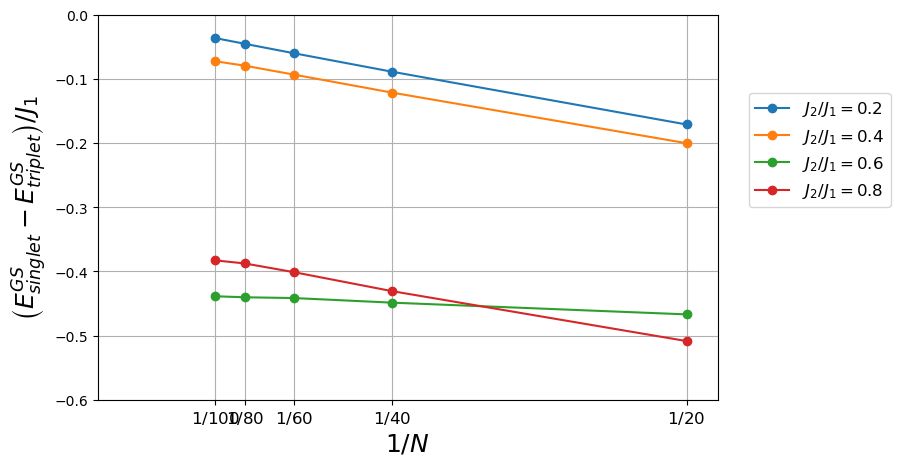

In [183]:
fig,ax = subplots(figsize=(8,5))
for i in 1:length(gs)
    ax.plot(1 ./Ns,E_singlet[:,i]-E_triplet[:,i],"-o",label=L"$J_2/J_1=$"*string(gs[i]))
end
# ax.set_xlim([0,1])
# ax.set_xscale("log")
ax.legend(loc=(1.05,0.5),fontsize=12)
ax.set_xlabel(L"$1/N$", fontsize=18)
ax.set_xticks(1 ./Ns)
ax.set_xticklabels([L"1/" * string(N) for N in Ns ], fontsize=12)
ax.set_ylabel(L"\left(E^{GS}_{singlet}-E^{GS}_{triplet}\right)/J_1",fontsize=18)
ax.set_xlim([0,1/19])
ax.set_ylim([-0.6,0])
# ax.set_xscale("log")
ax.grid()

gcf()

## 1-3
*Calculate the spin-spin correlations (i.e. the expectation value of $\langle\vec{S}_{x_0} \cdot \vec{S}_{x_0+x} \rangle$ as function of $x$) for different values of g across the phase transition. Show that for $g\leq g_c$ the correlations decay as a power law (i.e.  $1/x^\alpha$), while for $g > g_c$ the decay is exponential (i.e. $\sim\exp(-x\xi)$) . Use system sizes of $N = 200$ sites and calculate the correlations with respect to a site in the middle of the system to avoid boundary effects. (Recall that we are now working with open boundary conditions as opposed to all the calculations we performed using Exact Diagonalization.) For $g\leq g_c$ calculate the exponent $\alpha$, and for $g > g_c$ obtain the correlation length $\xi$. Note: to obtain the spin-spin correlations you can use the built in ITensor function `correlation matrix(psi,"Sz","Sz")` that calculates the full correlation matrix $\langle \psi|S^z_i S^z_j|\psi \rangle$ for every pair of sites $(i,j)$ in the system.*

In [76]:
N = 200
correlations = []
for (j,g) in enumerate(gs)
    sites = siteinds("S=1/2", N; conserve_qns=true)
    H = J1J2Hamiltonian(sites, g)
    
    state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]
    psi0 = productMPS(sites, state0)
    @show flux(psi0)
    E ,psi = dmrg(H,psi0; nsweeps=20, maxdim=100, cutoff=1E-10)

    append!(correlations,[correlation_matrix(psi,"Sz","Sz") + 0.5* correlation_matrix(psi,"S+","S-") + 0.5*correlation_matrix(psi,"S-","S+")])
end

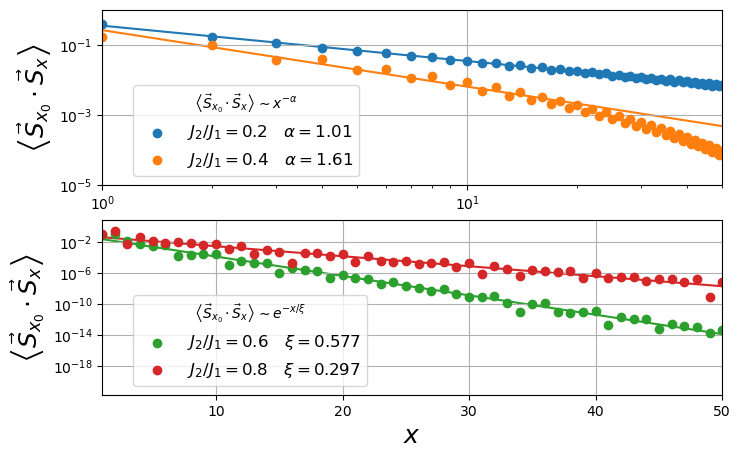

In [205]:
fig,ax = subplots(2,1,figsize=(8,5))
xx = LinRange(0,50,100)
p0 = [1.0, 0.0]
title=[L"$\left< \vec{S}_{x_0} \cdot \vec{S}_x \right>\sim x^{-\alpha}$", L"$\left< \vec{S}_{x_0} \cdot \vec{S}_x \right>\sim e^{-x/\xi}$"]
c = ["tab:blue","tab:orange","tab:green", "tab:red"]

for (i,g) in enumerate(gs)
    if g<0.5
        fit = curve_fit(m, log.(1:1:20), log.(abs.(correlations[i][100,101:120])) ,p0)
        ax[1].plot(exp.(xx),exp.(m(xx,fit.param)),color=c[i],zorder=1)
        ax[1].scatter(0:1:div(N,2),abs.(correlations[i][100,100:200]),
            zorder=2,color=c[i],
            label=L"$J_2/J_1=$"*string(g)*L"$\quad \alpha=$"*string(round(-fit.param[1],digits=2)))
    else
        fit = curve_fit(m, 1:1:50, log.(abs.(correlations[i][100,101:150])) ,p0)
        ax[2].plot(xx,exp.(m(xx,fit.param)),color=c[i],zorder=1)
        ax[2].scatter(0:1:div(N,2),abs.(correlations[i][100,100:200]),
            zorder=2,color=c[i],
            label=L"$J_2/J_1=$"*string(g)*L"$\quad \xi=$"*string(round(-fit.param[1],digits=3)))
    end
end
for i in 1:2
    ax[i].legend(loc=(0.05,0.05),fontsize=12, title=title[i])
    ax[i].set_ylabel(L"\left< \vec{S}_{x_0} \cdot \vec{S}_x \right>",fontsize=18)
    ax[i].set_xlim([1,50])
    ax[i].set_xlabel(L"$x$", fontsize=18)
end
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_ylim([1e-5,1])
ax[2].set_yscale("log")

ax[1].grid(zorder=0)
ax[2].grid(zorder=0)

gcf()

# Spin-1 chain - Haldane gap
*In this problem we will consider the spin-1 bilinear-biquadtatic model*
$$H=\sum_i J_1 \vec{S}_i\cdot\vec{S}_{i+1} + J_2 \left( \vec{S}_i\cdot\vec{S}_{i+1} \right)^2 $$
*As discussed in the tutorial and in Problem Set 2, for $J_2/J_1 = 1/3$ the model is exactly solvable,and the ground state can be written explicitly as an MPS of bind dimension $M = 2$. At this point you observed that the ground state is four-fold degenerate for open boundary conditions and that the edges feature fractionalized spin-1/2 states.*

*In this problem you will show that when $J_2\rightarrow0$ the system remains in the same phase, i.e. it is gapped, and hosts fractionalized edge mods.*

## 2-1
*Consider different values of $J_2$ ranging between $1/3$ and $0$ and show that the system remains gapped within this range. To this end, perform finite-size scaling of the bulk gap. Note that to probe the bulk gap in this case you will need to look at the $S^z = 2$ sector, as the lowest energy state in the $S^z = 1$ sector simply accumulates the extra spin at the edges of the system (you'll check this in the next section).*

In [2]:
function AKLTHamiltonian(sites, J2)
    N = length(sites)
    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the 1D quantum system
    for j = 1:N-1
        ampo += "Sz", j, "Sz", j+1
        ampo += 1/2, "S+", j, "S-", j+1
        ampo += 1/2, "S-", j, "S+", j+1
        
        ampo += J2, "Sz", j, "Sz", j+1, "Sz", j, "Sz", j+1
        ampo += J2/2, "Sz", j, "Sz", j+1, "S+", j, "S-", j+1
        ampo += J2/2, "S+", j, "S-", j+1, "Sz", j, "Sz", j+1
        ampo += J2/2, "Sz", j, "Sz", j+1, "S-", j, "S+", j+1
        ampo += J2/2, "S-", j, "S+", j+1, "Sz", j, "Sz", j+1
        ampo += J2/4, "S+", j, "S-", j+1 , "S+", j, "S-", j+1
        ampo += J2/4, "S+", j, "S-", j+1 , "S-", j, "S+", j+1
        ampo += J2/4, "S-", j, "S+", j+1 , "S-", j, "S+", j+1
        ampo += J2/4, "S-", j, "S+", j+1 , "S+", j, "S-", j+1
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)
    return H
end

AKLTHamiltonian (generic function with 1 method)

In [9]:
Ns = 16:4:32
J2s = [0.0, 0.1, 0.2, 0.3, 1/3]
E_0 = zeros(length(Ns),length(J2s))
E_2 = zeros(length(Ns),length(J2s))

for (i,N) in enumerate(Ns)
    for (j,J2) in enumerate(J2s)
        sites = siteinds("S=1", N; conserve_qns=true)
        H = AKLTHamiltonian(sites, J2)
        
        state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]

        psi0 = randomMPS(sites,state0,linkdims=2)
        @show flux(psi0)
        E_0[i,j],psi = dmrg(H,psi0; nsweeps=30, maxdim=10, cutoff=1E-10)

        state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]
        state0[2] = "Up"

        psi0 = randomMPS(sites,state0,linkdims=2)
        @show flux(psi0)
        E_2[i,j],psi = dmrg(H,psi0; nsweeps=30, maxdim=10, cutoff=1E-10)
    end
end

flux(psi0) = QN("Sz",0)
After sweep 1 energy=-21.14909815586029  maxlinkdim=10 maxerr=1.28E-03 time=0.126


After sweep 2 energy=-21.225203344737654  maxlinkdim=10 maxerr=1.10E-04 time=0.148


After sweep 3 energy=-21.225242892841674  maxlinkdim=10 maxerr=6.98E-05 time=0.140


After sweep 4 energy=-21.225238330431296  maxlinkdim=10 maxerr=7.18E-05 time=0.141


After sweep 5 energy=-21.225234700832793  maxlinkdim=10 maxerr=7.25E-05 time=0.142


After sweep 6 energy=-21.225232618742453  maxlinkdim=10 maxerr=7.29E-05 time=0.145


After sweep 7 energy=-21.225231402128138  maxlinkdim=10 maxerr=7.30E-05 time=0.145


After sweep 8 energy=-21.22523065325349  maxlinkdim=10 maxerr=7.31E-05 time=0.141


After sweep 9 energy=-21.225230171475392  maxlinkdim=10 maxerr=7.32E-05 time=0.155


After sweep 10 energy=-21.225229851390527  maxlinkdim=10 maxerr=7.32E-05 time=0.141


After sweep 11 energy=-21.225229633855044  maxlinkdim=10 maxerr=7.32E-05 time=0.141


After sweep 12 energy=-21.225229483643115  maxlinkdim=10 maxerr=7.32E-05 time=0.143


After sweep 13 energy=-21.225229378750004  maxlinkdim=10 maxerr=7.32E-05 time=0.143


After sweep 14 energy=-21.22522930491973  maxlinkdim=10 maxerr=7.32E-05 time=0.144


After sweep 15 energy=-21.225229252659584  maxlinkdim=10 maxerr=7.33E-05 time=0.141


After sweep 16 energy=-21.225229215518837  maxlinkdim=10 maxerr=7.33E-05 time=0.605


After sweep 17 energy=-21.225229189047347  maxlinkdim=10 maxerr=7.33E-05 time=0.226


After sweep 18 energy=-21.225229170141542  maxlinkdim=10 maxerr=7.33E-05 time=0.185


After sweep 19 energy=-21.22522915661922  maxlinkdim=10 maxerr=7.33E-05 time=0.147


After sweep 20 energy=-21.22522914693726  maxlinkdim=10 maxerr=7.33E-05 time=0.142


After sweep 21 energy=-21.225229139999744  maxlinkdim=10 maxerr=7.33E-05 time=0.667


After sweep 22 energy=-21.225229135026062  maxlinkdim=10 maxerr=7.33E-05 time=0.173


After sweep 23 energy=-21.225229131458885  maxlinkdim=10 maxerr=7.33E-05 time=0.159


After sweep 24 energy=-21.225229128899763  maxlinkdim=10 maxerr=7.33E-05 time=0.142


After sweep 25 energy=-21.225229127063486  maxlinkdim=10 maxerr=7.33E-05 time=0.263


After sweep 26 energy=-21.225229125745656  maxlinkdim=10 maxerr=7.33E-05 time=0.566


After sweep 27 energy=-21.22522912479983  maxlinkdim=10 maxerr=7.33E-05 time=0.183


After sweep 28 energy=-21.225229124120958  maxlinkdim=10 maxerr=7.33E-05 time=0.144


After sweep 29 energy=-21.22522912363356  maxlinkdim=10 maxerr=7.33E-05 time=0.143


After sweep 30 energy=-21.22522912328381  maxlinkdim=10 maxerr=7.33E-05 time=0.143


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-18.98209134315461  maxlinkdim=10 maxerr=1.18E-04 time=0.109


After sweep 2 energy=-20.494968697673173  maxlinkdim=10 maxerr=1.18E-03 time=0.151


After sweep 3 energy=-20.589955499137602  maxlinkdim=10 maxerr=5.07E-04 time=0.148


After sweep 4 energy=-20.59132280722149  maxlinkdim=10 maxerr=4.19E-04 time=0.153


After sweep 5 energy=-20.591346248546635  maxlinkdim=10 maxerr=4.13E-04 time=0.165


After sweep 6 energy=-20.591346262422753  maxlinkdim=10 maxerr=4.12E-04 time=0.156


After sweep 7 energy=-20.591346193184393  maxlinkdim=10 maxerr=4.12E-04 time=0.165


After sweep 8 energy=-20.59134618165649  maxlinkdim=10 maxerr=4.12E-04 time=0.198


After sweep 9 energy=-20.59134617995883  maxlinkdim=10 maxerr=4.12E-04 time=0.168


After sweep 10 energy=-20.591346179713007  maxlinkdim=10 maxerr=4.12E-04 time=0.165


After sweep 11 energy=-20.59134617967747  maxlinkdim=10 maxerr=4.12E-04 time=0.158


After sweep 12 energy=-20.59134617967233  maxlinkdim=10 maxerr=4.12E-04 time=0.162


After sweep 13 energy=-20.591346179671596  maxlinkdim=10 maxerr=4.12E-04 time=0.187


After sweep 14 energy=-20.59134617967151  maxlinkdim=10 maxerr=4.12E-04 time=0.155


After sweep 15 energy=-20.59134617967149  maxlinkdim=10 maxerr=4.12E-04 time=0.153


After sweep 16 energy=-20.591346179671454  maxlinkdim=10 maxerr=4.12E-04 time=0.165


After sweep 17 energy=-20.591346179671476  maxlinkdim=10 maxerr=4.12E-04 time=0.168


After sweep 18 energy=-20.59134617967146  maxlinkdim=10 maxerr=4.12E-04 time=0.155


After sweep 19 energy=-20.59134617967147  maxlinkdim=10 maxerr=4.12E-04 time=0.163


After sweep 20 energy=-20.591346179671483  maxlinkdim=10 maxerr=4.12E-04 time=0.155


After sweep 21 energy=-20.59134617967146  maxlinkdim=10 maxerr=4.12E-04 time=0.155


After sweep 22 energy=-20.591346179671472  maxlinkdim=10 maxerr=4.12E-04 time=0.169


After sweep 23 energy=-20.591346179671497  maxlinkdim=10 maxerr=4.12E-04 time=0.161


After sweep 24 energy=-20.591346179671508  maxlinkdim=10 maxerr=4.12E-04 time=0.156


After sweep 25 energy=-20.591346179671497  maxlinkdim=10 maxerr=4.12E-04 time=0.165


After sweep 26 energy=-20.59134617967151  maxlinkdim=10 maxerr=4.12E-04 time=0.156


After sweep 27 energy=-20.59134617967145  maxlinkdim=10 maxerr=4.12E-04 time=0.153


After sweep 28 energy=-20.59134617967149  maxlinkdim=10 maxerr=4.12E-04 time=0.163


After sweep 29 energy=-20.591346179671472  maxlinkdim=10 maxerr=4.12E-04 time=0.155


After sweep 30 energy=-20.59134617967151  maxlinkdim=10 maxerr=4.12E-04 time=0.154


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-17.59528858288441  maxlinkdim=10 maxerr=6.46E-05 time=0.185


After sweep 2 energy=-17.634385001471617  maxlinkdim=10 maxerr=1.63E-05 time=0.276


After sweep 3 energy=-17.634467640398533  maxlinkdim=10 maxerr=1.57E-05 time=0.259


After sweep 4 energy=-17.63447241102177  maxlinkdim=10 maxerr=1.64E-05 time=0.264


After sweep 5 energy=-17.634471961300292  maxlinkdim=10 maxerr=1.67E-05 time=0.261


After sweep 6 energy=-17.634471149214132  maxlinkdim=10 maxerr=1.69E-05 time=0.262


After sweep 7 energy=-17.63447065184942  maxlinkdim=10 maxerr=1.70E-05 time=0.273


After sweep 8 energy=-17.6344457137455  maxlinkdim=10 maxerr=1.70E-05 time=0.258


After sweep 9 energy=-17.634468318424275  maxlinkdim=10 maxerr=1.70E-05 time=0.260


After sweep 10 energy=-17.634442940692935  maxlinkdim=10 maxerr=1.71E-05 time=0.258


After sweep 11 energy=-17.634440704869885  maxlinkdim=10 maxerr=1.71E-05 time=0.256


After sweep 12 energy=-17.634465935468036  maxlinkdim=10 maxerr=1.70E-05 time=0.258


After sweep 13 energy=-17.63446543701569  maxlinkdim=10 maxerr=1.71E-05 time=0.256


After sweep 14 energy=-17.634440435664327  maxlinkdim=10 maxerr=1.71E-05 time=0.254


After sweep 15 energy=-17.634443389113066  maxlinkdim=10 maxerr=1.71E-05 time=0.257


After sweep 16 energy=-17.63444334587864  maxlinkdim=10 maxerr=1.71E-05 time=0.273


After sweep 17 energy=-17.63446579724813  maxlinkdim=10 maxerr=1.71E-05 time=0.263


After sweep 18 energy=-17.634465370032345  maxlinkdim=10 maxerr=1.71E-05 time=0.257


After sweep 19 energy=-17.634440402272332  maxlinkdim=10 maxerr=1.71E-05 time=0.258


After sweep 20 energy=-17.63444337644798  maxlinkdim=10 maxerr=1.71E-05 time=0.260


After sweep 21 energy=-17.634443340094215  maxlinkdim=10 maxerr=1.71E-05 time=0.257


After sweep 22 energy=-17.634465794627435  maxlinkdim=10 maxerr=1.71E-05 time=0.258


After sweep 23 energy=-17.63446536880864  maxlinkdim=10 maxerr=1.71E-05 time=0.258


After sweep 24 energy=-17.634440401676972  maxlinkdim=10 maxerr=1.71E-05 time=0.258


After sweep 25 energy=-17.634443376223526  maxlinkdim=10 maxerr=1.71E-05 time=0.258


After sweep 26 energy=-17.634443339992128  maxlinkdim=10 maxerr=1.71E-05 time=0.288


After sweep 27 energy=-17.634465794581228  maxlinkdim=10 maxerr=1.71E-05 time=0.260


After sweep 28 energy=-17.634465368787083  maxlinkdim=10 maxerr=1.71E-05 time=0.272


After sweep 29 energy=-17.634440401666527  maxlinkdim=10 maxerr=1.71E-05 time=0.258


After sweep 30 energy=-17.634443376219597  maxlinkdim=10 maxerr=1.71E-05 time=0.259


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-16.724183930388023  maxlinkdim=10 maxerr=7.09E-04 time=0.189


After sweep 2 energy=-17.002385794046155  maxlinkdim=10 maxerr=3.39E-04 time=0.296


After sweep 3 energy=-17.009360659971275  maxlinkdim=10 maxerr=3.11E-04 time=0.289


After sweep 4 energy=-17.009563789144494  maxlinkdim=10 maxerr=2.94E-04 time=0.314


After sweep 5 energy=-17.009568860948793  maxlinkdim=10 maxerr=2.92E-04 time=0.309


After sweep 6 energy=-17.009568785850295  maxlinkdim=10 maxerr=2.92E-04 time=0.302


After sweep 7 energy=-17.009568737871607  maxlinkdim=10 maxerr=2.92E-04 time=0.311


After sweep 8 energy=-17.009568727789148  maxlinkdim=10 maxerr=2.92E-04 time=0.310


After sweep 9 energy=-17.00956872587804  maxlinkdim=10 maxerr=2.92E-04 time=0.340


After sweep 10 energy=-17.009568725522037  maxlinkdim=10 maxerr=2.92E-04 time=0.310


After sweep 11 energy=-17.00956872545589  maxlinkdim=10 maxerr=2.92E-04 time=0.311


After sweep 12 energy=-17.009568725443582  maxlinkdim=10 maxerr=2.92E-04 time=0.301


After sweep 13 energy=-17.009568725441326  maxlinkdim=10 maxerr=2.92E-04 time=0.313


After sweep 14 energy=-17.00956872544088  maxlinkdim=10 maxerr=2.92E-04 time=0.310


After sweep 15 energy=-17.009568725440797  maxlinkdim=10 maxerr=2.92E-04 time=0.298


After sweep 16 energy=-17.009568725440804  maxlinkdim=10 maxerr=2.92E-04 time=0.382


After sweep 17 energy=-17.009568725440783  maxlinkdim=10 maxerr=2.92E-04 time=0.301


After sweep 18 energy=-17.009568725440797  maxlinkdim=10 maxerr=2.92E-04 time=0.313


After sweep 19 energy=-17.009568725440793  maxlinkdim=10 maxerr=2.92E-04 time=0.311


After sweep 20 energy=-17.009568725440776  maxlinkdim=10 maxerr=2.92E-04 time=0.301


After sweep 21 energy=-17.009568725440815  maxlinkdim=10 maxerr=2.92E-04 time=0.313


After sweep 22 energy=-17.009568725440783  maxlinkdim=10 maxerr=2.92E-04 time=0.313


After sweep 23 energy=-17.00956872544078  maxlinkdim=10 maxerr=2.92E-04 time=0.298


After sweep 24 energy=-17.00956872544081  maxlinkdim=10 maxerr=2.92E-04 time=0.312


After sweep 25 energy=-17.009568725440808  maxlinkdim=10 maxerr=2.92E-04 time=0.299


After sweep 26 energy=-17.009568725440793  maxlinkdim=10 maxerr=2.92E-04 time=0.313


After sweep 27 energy=-17.00956872544081  maxlinkdim=10 maxerr=2.92E-04 time=0.318


After sweep 28 energy=-17.009568725440808  maxlinkdim=10 maxerr=2.92E-04 time=0.303


After sweep 29 energy=-17.00956872544078  maxlinkdim=10 maxerr=2.92E-04 time=0.313


After sweep 30 energy=-17.0095687254408  maxlinkdim=10 maxerr=2.92E-04 time=0.309


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-13.264162640423375  maxlinkdim=10 maxerr=2.82E-03 time=0.193


After sweep 2 energy=-14.21849771170714  maxlinkdim=10 maxerr=1.10E-04 time=0.290


After sweep 3 energy=-14.218723099347715  maxlinkdim=10 maxerr=1.41E-06 time=0.259


After sweep 4 energy=-14.218724593427865  maxlinkdim=10 maxerr=1.19E-06 time=0.266


After sweep 5 energy=-14.218725162108164  maxlinkdim=10 maxerr=1.22E-06 time=0.264


After sweep 6 energy=-14.218725437333875  maxlinkdim=10 maxerr=1.25E-06 time=0.265


After sweep 7 energy=-14.218725567634849  maxlinkdim=10 maxerr=1.27E-06 time=0.266


After sweep 8 energy=-14.21872562488225  maxlinkdim=10 maxerr=1.29E-06 time=0.296


After sweep 9 energy=-14.218725647313997  maxlinkdim=10 maxerr=1.30E-06 time=0.266


After sweep 10 energy=-14.218725654453525  maxlinkdim=10 maxerr=1.31E-06 time=0.265


After sweep 11 energy=-14.218725655551504  maxlinkdim=10 maxerr=1.31E-06 time=0.266


After sweep 12 energy=-14.218725654648036  maxlinkdim=10 maxerr=1.32E-06 time=0.265


After sweep 13 energy=-14.21872565334445  maxlinkdim=10 maxerr=1.32E-06 time=0.266


After sweep 14 energy=-14.218725652186546  maxlinkdim=10 maxerr=1.32E-06 time=0.264


After sweep 15 energy=-14.218725651301382  maxlinkdim=10 maxerr=1.32E-06 time=0.265


After sweep 16 energy=-14.21872565067017  maxlinkdim=10 maxerr=1.32E-06 time=0.265


After sweep 17 energy=-14.218725650236696  maxlinkdim=10 maxerr=1.32E-06 time=0.266


After sweep 18 energy=-14.218725649945473  maxlinkdim=10 maxerr=1.32E-06 time=0.265


After sweep 19 energy=-14.218725649752388  maxlinkdim=10 maxerr=1.32E-06 time=0.263


After sweep 20 energy=-14.218725649625384  maxlinkdim=10 maxerr=1.32E-06 time=0.268


After sweep 21 energy=-14.218725649542328  maxlinkdim=10 maxerr=1.33E-06 time=0.262


After sweep 22 energy=-14.21872564948816  maxlinkdim=10 maxerr=1.33E-06 time=0.265


After sweep 23 energy=-14.218725649452933  maxlinkdim=10 maxerr=1.33E-06 time=0.264


After sweep 24 energy=-14.218725649430047  maxlinkdim=10 maxerr=1.33E-06 time=0.267


After sweep 25 energy=-14.218725649415209  maxlinkdim=10 maxerr=1.33E-06 time=0.266


After sweep 26 energy=-14.218725649405553  maxlinkdim=10 maxerr=1.33E-06 time=0.266


After sweep 27 energy=-14.218725649399278  maxlinkdim=10 maxerr=1.33E-06 time=0.266


After sweep 28 energy=-14.218725649395243  maxlinkdim=10 maxerr=1.33E-06 time=0.267


After sweep 29 energy=-14.218725649392624  maxlinkdim=10 maxerr=1.33E-06 time=0.266


After sweep 30 energy=-14.218725649390922  maxlinkdim=10 maxerr=1.33E-06 time=0.267


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-12.453834270548644  maxlinkdim=10 maxerr=8.12E-05 time=0.188


After sweep 2 energy=-13.505768053939466  maxlinkdim=10 maxerr=4.59E-04 time=0.310


After sweep 3 energy=-13.569111423331776  maxlinkdim=10 maxerr=1.37E-04 time=0.303


After sweep 4 energy=-13.57271480582931  maxlinkdim=10 maxerr=1.24E-04 time=0.304


After sweep 5 energy=-13.572892438381526  maxlinkdim=10 maxerr=9.35E-05 time=0.316


After sweep 6 energy=-13.572902852813865  maxlinkdim=10 maxerr=9.17E-05 time=0.303


After sweep 7 energy=-13.572903702375925  maxlinkdim=10 maxerr=9.16E-05 time=0.314


After sweep 8 energy=-13.572903788420977  maxlinkdim=10 maxerr=9.16E-05 time=0.303


After sweep 9 energy=-13.572903801377024  maxlinkdim=10 maxerr=9.15E-05 time=0.316


After sweep 10 energy=-13.572903804190776  maxlinkdim=10 maxerr=9.15E-05 time=0.305


After sweep 11 energy=-13.572903804916159  maxlinkdim=10 maxerr=9.15E-05 time=0.318


After sweep 12 energy=-13.572903805112919  maxlinkdim=10 maxerr=9.15E-05 time=0.308


After sweep 13 energy=-13.572903805166852  maxlinkdim=10 maxerr=9.15E-05 time=0.318


After sweep 14 energy=-13.572903805181618  maxlinkdim=10 maxerr=9.15E-05 time=0.316


After sweep 15 energy=-13.572903805185673  maxlinkdim=10 maxerr=9.15E-05 time=0.305


After sweep 16 energy=-13.572903805186773  maxlinkdim=10 maxerr=9.15E-05 time=0.316


After sweep 17 energy=-13.572903805187064  maxlinkdim=10 maxerr=9.15E-05 time=0.306


After sweep 18 energy=-13.572903805187163  maxlinkdim=10 maxerr=9.15E-05 time=0.316


After sweep 19 energy=-13.572903805187178  maxlinkdim=10 maxerr=9.15E-05 time=0.303


After sweep 20 energy=-13.572903805187163  maxlinkdim=10 maxerr=9.15E-05 time=0.336


After sweep 21 energy=-13.572903805187188  maxlinkdim=10 maxerr=9.15E-05 time=0.308


After sweep 22 energy=-13.572903805187178  maxlinkdim=10 maxerr=9.15E-05 time=0.315


After sweep 23 energy=-13.572903805187186  maxlinkdim=10 maxerr=9.15E-05 time=0.307


After sweep 24 energy=-13.572903805187192  maxlinkdim=10 maxerr=9.15E-05 time=0.316


After sweep 25 energy=-13.572903805187188  maxlinkdim=10 maxerr=9.15E-05 time=0.304


After sweep 26 energy=-13.572903805187185  maxlinkdim=10 maxerr=9.15E-05 time=0.317


After sweep 27 energy=-13.572903805187181  maxlinkdim=10 maxerr=9.15E-05 time=0.305


After sweep 28 energy=-13.572903805187178  maxlinkdim=10 maxerr=9.15E-05 time=0.317


After sweep 29 energy=-13.572903805187206  maxlinkdim=10 maxerr=9.15E-05 time=0.304


After sweep 30 energy=-13.572903805187174  maxlinkdim=10 maxerr=9.15E-05 time=0.322


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-11.00123417800241  maxlinkdim=10 maxerr=2.71E-05 time=0.196


After sweep 2 energy=-11.01441767537282  maxlinkdim=10 maxerr=1.22E-06 time=0.307


After sweep 3 energy=-11.014419571222117  maxlinkdim=10 maxerr=1.73E-07 time=0.255


After sweep 4 energy=-11.014419569988519  maxlinkdim=10 maxerr=1.71E-07 time=0.251


After sweep 5 energy=-11.01441956993255  maxlinkdim=10 maxerr=1.71E-07 time=0.262


After sweep 6 energy=-11.01441956993066  maxlinkdim=10 maxerr=1.71E-07 time=0.262


After sweep 7 energy=-11.01441956993061  maxlinkdim=10 maxerr=1.71E-07 time=0.260


After sweep 8 energy=-11.014419569930606  maxlinkdim=10 maxerr=1.71E-07 time=0.263


After sweep 9 energy=-11.014419569930604  maxlinkdim=10 maxerr=1.71E-07 time=0.262


After sweep 10 energy=-11.014419569930606  maxlinkdim=10 maxerr=1.71E-07 time=0.253


After sweep 11 energy=-11.014419569930595  maxlinkdim=10 maxerr=1.71E-07 time=0.261


After sweep 12 energy=-11.014419569930595  maxlinkdim=10 maxerr=1.71E-07 time=0.281


After sweep 13 energy=-11.014419569930599  maxlinkdim=10 maxerr=1.71E-07 time=0.260


After sweep 14 energy=-11.014419569930634  maxlinkdim=10 maxerr=1.71E-07 time=0.262


After sweep 15 energy=-11.0144195699306  maxlinkdim=10 maxerr=1.71E-07 time=0.262


After sweep 16 energy=-11.014419569930606  maxlinkdim=10 maxerr=1.71E-07 time=0.252


After sweep 17 energy=-11.01441956993061  maxlinkdim=10 maxerr=1.71E-07 time=0.262


After sweep 18 energy=-11.014419569930608  maxlinkdim=10 maxerr=1.71E-07 time=0.265


After sweep 19 energy=-11.014419569930599  maxlinkdim=10 maxerr=1.71E-07 time=0.263


After sweep 20 energy=-11.014419569930613  maxlinkdim=10 maxerr=1.71E-07 time=0.261


After sweep 21 energy=-11.014419569930602  maxlinkdim=10 maxerr=1.71E-07 time=0.264


After sweep 22 energy=-11.014419569930613  maxlinkdim=10 maxerr=1.71E-07 time=0.249


After sweep 23 energy=-11.01441956993062  maxlinkdim=10 maxerr=1.71E-07 time=0.266


After sweep 24 energy=-11.014419569930592  maxlinkdim=10 maxerr=1.71E-07 time=0.268


After sweep 25 energy=-11.014419569930613  maxlinkdim=10 maxerr=1.71E-07 time=0.260


After sweep 26 energy=-11.014419569930624  maxlinkdim=10 maxerr=1.71E-07 time=0.261


After sweep 27 energy=-11.014419569930606  maxlinkdim=10 maxerr=1.71E-07 time=0.261


After sweep 28 energy=-11.014419569930613  maxlinkdim=10 maxerr=1.71E-07 time=0.249


After sweep 29 energy=-11.014419569930634  maxlinkdim=10 maxerr=1.71E-07 time=0.261


After sweep 30 energy=-11.014419569930602  maxlinkdim=10 maxerr=1.71E-07 time=0.261


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-10.197542363983022  maxlinkdim=10 maxerr=1.67E-05 time=0.210


After sweep 2 energy=-10.28578243878517  maxlinkdim=10 maxerr=4.64E-05 time=0.280


After sweep 3 energy=-10.316190152441141  maxlinkdim=10 maxerr=2.79E-05 time=0.282


After sweep 4 energy=-10.31900003469838  maxlinkdim=10 maxerr=1.45E-05 time=0.309


After sweep 5 energy=-10.319175379085621  maxlinkdim=10 maxerr=8.54E-06 time=0.300


After sweep 6 energy=-10.319196917759442  maxlinkdim=10 maxerr=7.36E-06 time=0.300


After sweep 7 energy=-10.319201036378068  maxlinkdim=10 maxerr=7.11E-06 time=0.311


After sweep 8 energy=-10.31920192674102  maxlinkdim=10 maxerr=7.08E-06 time=0.301


After sweep 9 energy=-10.319202121772324  maxlinkdim=10 maxerr=7.07E-06 time=0.298


After sweep 10 energy=-10.319202164173129  maxlinkdim=10 maxerr=7.07E-06 time=0.313


After sweep 11 energy=-10.319202173177839  maxlinkdim=10 maxerr=7.07E-06 time=0.300


After sweep 12 energy=-10.319202174939214  maxlinkdim=10 maxerr=7.07E-06 time=0.302


After sweep 13 energy=-10.319202175199315  maxlinkdim=10 maxerr=7.08E-06 time=0.312


After sweep 14 energy=-10.319202175189794  maxlinkdim=10 maxerr=7.08E-06 time=0.303


After sweep 15 energy=-10.319202175154274  maxlinkdim=10 maxerr=7.08E-06 time=0.300


After sweep 16 energy=-10.319202175130036  maxlinkdim=10 maxerr=7.08E-06 time=0.318


After sweep 17 energy=-10.319202175116734  maxlinkdim=10 maxerr=7.08E-06 time=0.301


After sweep 18 energy=-10.319202175109911  maxlinkdim=10 maxerr=7.08E-06 time=0.299


After sweep 19 energy=-10.319202175106533  maxlinkdim=10 maxerr=7.08E-06 time=0.314


After sweep 20 energy=-10.319202175104884  maxlinkdim=10 maxerr=7.08E-06 time=0.300


After sweep 21 energy=-10.31920217510407  maxlinkdim=10 maxerr=7.08E-06 time=0.303


After sweep 22 energy=-10.319202175103687  maxlinkdim=10 maxerr=7.08E-06 time=0.302


After sweep 23 energy=-10.319202175103491  maxlinkdim=10 maxerr=7.08E-06 time=0.316


After sweep 24 energy=-10.319202175103392  maxlinkdim=10 maxerr=7.08E-06 time=0.303


After sweep 25 energy=-10.31920217510336  maxlinkdim=10 maxerr=7.08E-06 time=0.300


After sweep 26 energy=-10.319202175103332  maxlinkdim=10 maxerr=7.08E-06 time=0.313


After sweep 27 energy=-10.319202175103316  maxlinkdim=10 maxerr=7.08E-06 time=0.302


After sweep 28 energy=-10.319202175103324  maxlinkdim=10 maxerr=7.08E-06 time=0.301


After sweep 29 energy=-10.319202175103312  maxlinkdim=10 maxerr=7.08E-06 time=0.348


After sweep 30 energy=-10.319202175103317  maxlinkdim=10 maxerr=7.08E-06 time=0.379


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-9.990685358452513  maxlinkdim=10 maxerr=5.40E-06 time=0.192


After sweep 2 energy=-9.999988787836752  maxlinkdim=10 maxerr=4.32E-07 time=0.266


After sweep 3 energy=-9.999999989544301  maxlinkdim=6 maxerr=5.95E-10 time=0.216


After sweep 4 energy=-9.999999999999885  maxlinkdim=2 maxerr=1.44E-11 time=0.077


After sweep 5 energy=-9.999999999999996  maxlinkdim=2 maxerr=1.67E-16 time=0.052


After sweep 6 energy=-10.000000000000004  maxlinkdim=2 maxerr=5.55E-17 time=0.066


After sweep 7 energy=-10.000000000000004  maxlinkdim=2 maxerr=8.33E-17 time=0.078


After sweep 8 energy=-9.999999999999998  maxlinkdim=2 maxerr=6.94E-17 time=0.030


After sweep 9 energy=-10.0  maxlinkdim=2 maxerr=5.55E-17 time=0.024


After sweep 10 energy=-9.999999999999998  maxlinkdim=2 maxerr=5.55E-17 time=0.046


After sweep 11 energy=-9.999999999999996  maxlinkdim=2 maxerr=5.55E-17 time=0.026


After sweep 12 energy=-9.999999999999996  maxlinkdim=2 maxerr=5.55E-17 time=0.025


After sweep 13 energy=-9.999999999999996  maxlinkdim=2 maxerr=5.55E-17 time=0.044


After sweep 14 energy=-10.000000000000009  maxlinkdim=2 maxerr=6.94E-17 time=0.025


After sweep 15 energy=-10.0  maxlinkdim=2 maxerr=5.55E-17 time=0.045


After sweep 16 energy=-9.999999999999998  maxlinkdim=2 maxerr=5.55E-17 time=0.049


After sweep 17 energy=-10.000000000000002  maxlinkdim=2 maxerr=8.33E-17 time=0.025


After sweep 18 energy=-10.000000000000002  maxlinkdim=2 maxerr=6.94E-17 time=0.024


After sweep 19 energy=-9.999999999999998  maxlinkdim=2 maxerr=8.33E-17 time=0.026


After sweep 20 energy=-10.000000000000005  maxlinkdim=2 maxerr=5.55E-17 time=0.043


After sweep 21 energy=-10.0  maxlinkdim=2 maxerr=6.94E-17 time=0.026


After sweep 22 energy=-9.999999999999996  maxlinkdim=2 maxerr=4.16E-17 time=0.026


After sweep 23 energy=-9.999999999999998  maxlinkdim=2 maxerr=4.16E-17 time=0.043


After sweep 24 energy=-9.999999999999998  maxlinkdim=2 maxerr=6.94E-17 time=0.026


After sweep 25 energy=-10.0  maxlinkdim=2 maxerr=4.16E-17 time=0.025


After sweep 26 energy=-10.000000000000004  maxlinkdim=2 maxerr=5.55E-17 time=0.041


After sweep 27 energy=-10.000000000000002  maxlinkdim=2 maxerr=5.55E-17 time=0.025


After sweep 28 energy=-9.999999999999996  maxlinkdim=2 maxerr=4.16E-17 time=0.026


After sweep 29 energy=-10.000000000000002  maxlinkdim=2 maxerr=5.55E-17 time=0.045


After sweep 30 energy=-10.000000000000005  maxlinkdim=2 maxerr=5.55E-17 time=0.026


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-7.636472513676347  maxlinkdim=10 maxerr=5.72E-04 time=0.182


After sweep 2 energy=-9.224389628973846  maxlinkdim=10 maxerr=5.16E-04 time=0.273


After sweep 3 energy=-9.260333923871691  maxlinkdim=10 maxerr=2.03E-05 time=0.275


After sweep 4 energy=-9.27531633192748  maxlinkdim=10 maxerr=2.06E-05 time=0.307


After sweep 5 energy=-9.281428836168498  maxlinkdim=10 maxerr=1.57E-05 time=0.324


After sweep 6 energy=-9.282729640620847  maxlinkdim=10 maxerr=2.83E-06 time=0.311


After sweep 7 energy=-9.28285342218305  maxlinkdim=10 maxerr=1.22E-06 time=0.312


After sweep 8 energy=-9.282869982867997  maxlinkdim=10 maxerr=9.64E-07 time=0.323


After sweep 9 energy=-9.28287392979712  maxlinkdim=10 maxerr=8.97E-07 time=0.353


After sweep 10 energy=-9.282875107019317  maxlinkdim=10 maxerr=8.65E-07 time=0.309


After sweep 11 energy=-9.282875491463477  maxlinkdim=10 maxerr=8.55E-07 time=0.328


After sweep 12 energy=-9.2828756287263  maxlinkdim=10 maxerr=8.52E-07 time=0.313


After sweep 13 energy=-9.282875678460723  maxlinkdim=10 maxerr=8.51E-07 time=0.309


After sweep 14 energy=-9.282875696573246  maxlinkdim=10 maxerr=8.50E-07 time=0.323


After sweep 15 energy=-9.282875703233739  maxlinkdim=10 maxerr=8.50E-07 time=0.305


After sweep 16 energy=-9.282875705724088  maxlinkdim=10 maxerr=8.50E-07 time=0.305


After sweep 17 energy=-9.282875706674039  maxlinkdim=10 maxerr=8.50E-07 time=0.307


After sweep 18 energy=-9.282875707042262  maxlinkdim=10 maxerr=8.50E-07 time=0.320


After sweep 19 energy=-9.282875707186138  maxlinkdim=10 maxerr=8.50E-07 time=0.309


After sweep 20 energy=-9.2828757072423  maxlinkdim=10 maxerr=8.50E-07 time=0.306


After sweep 21 energy=-9.282875707264063  maxlinkdim=10 maxerr=8.50E-07 time=0.321


After sweep 22 energy=-9.282875707272336  maxlinkdim=10 maxerr=8.50E-07 time=0.308


After sweep 23 energy=-9.282875707275373  maxlinkdim=10 maxerr=8.50E-07 time=0.305


After sweep 24 energy=-9.28287570727643  maxlinkdim=10 maxerr=8.50E-07 time=0.306


After sweep 25 energy=-9.282875707276734  maxlinkdim=10 maxerr=8.50E-07 time=0.351


After sweep 26 energy=-9.282875707276782  maxlinkdim=10 maxerr=8.50E-07 time=0.306


After sweep 27 energy=-9.282875707276771  maxlinkdim=10 maxerr=8.50E-07 time=0.310


After sweep 28 energy=-9.282875707276732  maxlinkdim=10 maxerr=8.50E-07 time=0.319


After sweep 29 energy=-9.28287570727671  maxlinkdim=10 maxerr=8.50E-07 time=0.306


After sweep 30 energy=-9.282875707276688  maxlinkdim=10 maxerr=8.50E-07 time=0.305


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-26.761559285636967  maxlinkdim=10 maxerr=5.10E-05 time=0.119


After sweep 2 energy=-26.823550908629787  maxlinkdim=10 maxerr=8.33E-05 time=0.197


After sweep 3 energy=-26.82361465262579  maxlinkdim=10 maxerr=5.53E-05 time=0.179


After sweep 4 energy=-26.82361420927582  maxlinkdim=10 maxerr=5.56E-05 time=0.179


After sweep 5 energy=-26.8236140857208  maxlinkdim=10 maxerr=5.56E-05 time=0.195


After sweep 6 energy=-26.823614071264018  maxlinkdim=10 maxerr=5.56E-05 time=0.183


After sweep 7 energy=-26.823614069670757  maxlinkdim=10 maxerr=5.56E-05 time=0.176


After sweep 8 energy=-26.823614069496095  maxlinkdim=10 maxerr=5.56E-05 time=0.195


After sweep 9 energy=-26.82361406947684  maxlinkdim=10 maxerr=5.56E-05 time=0.189


After sweep 10 energy=-26.823614069474665  maxlinkdim=10 maxerr=5.56E-05 time=0.178


After sweep 11 energy=-26.823614069474484  maxlinkdim=10 maxerr=5.56E-05 time=0.197


After sweep 12 energy=-26.82361406947449  maxlinkdim=10 maxerr=5.56E-05 time=0.182


After sweep 13 energy=-26.823614069474438  maxlinkdim=10 maxerr=5.56E-05 time=0.178


After sweep 14 energy=-26.823614069474466  maxlinkdim=10 maxerr=5.56E-05 time=0.196


After sweep 15 energy=-26.823614069474477  maxlinkdim=10 maxerr=5.56E-05 time=0.179


After sweep 16 energy=-26.82361406947445  maxlinkdim=10 maxerr=5.56E-05 time=0.179


After sweep 17 energy=-26.823614069474452  maxlinkdim=10 maxerr=5.56E-05 time=0.195


After sweep 18 energy=-26.823614069474395  maxlinkdim=10 maxerr=5.56E-05 time=0.186


After sweep 19 energy=-26.8236140694744  maxlinkdim=10 maxerr=5.56E-05 time=0.180


After sweep 20 energy=-26.823614069474438  maxlinkdim=10 maxerr=5.56E-05 time=0.196


After sweep 21 energy=-26.823614069474463  maxlinkdim=10 maxerr=5.56E-05 time=0.180


After sweep 22 energy=-26.823614069474417  maxlinkdim=10 maxerr=5.56E-05 time=0.178


After sweep 23 energy=-26.823614069474456  maxlinkdim=10 maxerr=5.56E-05 time=0.194


After sweep 24 energy=-26.82361406947447  maxlinkdim=10 maxerr=5.56E-05 time=0.179


After sweep 25 energy=-26.823614069474427  maxlinkdim=10 maxerr=5.56E-05 time=0.178


After sweep 26 energy=-26.823614069474466  maxlinkdim=10 maxerr=5.56E-05 time=0.193


After sweep 27 energy=-26.82361406947446  maxlinkdim=10 maxerr=5.56E-05 time=0.181


After sweep 28 energy=-26.823614069474473  maxlinkdim=10 maxerr=5.56E-05 time=0.180


After sweep 29 energy=-26.823614069474452  maxlinkdim=10 maxerr=5.56E-05 time=0.195


After sweep 30 energy=-26.823614069474452  maxlinkdim=10 maxerr=5.56E-05 time=0.181


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-24.712881560219124  maxlinkdim=10 maxerr=5.69E-05 time=0.137


After sweep 2 energy=-26.09429278252345  maxlinkdim=10 maxerr=1.71E-03 time=0.191


After sweep 3 energy=-26.243185419001577  maxlinkdim=10 maxerr=7.10E-04 time=0.204


After sweep 4 energy=-26.25030584905561  maxlinkdim=10 maxerr=5.93E-04 time=0.211


After sweep 5 energy=-26.250711823885307  maxlinkdim=10 maxerr=5.55E-04 time=0.200


After sweep 6 energy=-26.25073214470765  maxlinkdim=10 maxerr=5.50E-04 time=0.212


After sweep 7 energy=-26.250731764055466  maxlinkdim=10 maxerr=5.50E-04 time=0.201


After sweep 8 energy=-26.25073127635839  maxlinkdim=10 maxerr=5.50E-04 time=0.261


After sweep 9 energy=-26.250731124683952  maxlinkdim=10 maxerr=5.50E-04 time=0.215


After sweep 10 energy=-26.2507310838836  maxlinkdim=10 maxerr=5.50E-04 time=0.202


After sweep 11 energy=-26.25073107325921  maxlinkdim=10 maxerr=5.50E-04 time=0.214


After sweep 12 energy=-26.25073107051469  maxlinkdim=10 maxerr=5.50E-04 time=0.230


After sweep 13 energy=-26.250731069807188  maxlinkdim=10 maxerr=5.50E-04 time=0.202


After sweep 14 energy=-26.25073106962488  maxlinkdim=10 maxerr=5.50E-04 time=0.215


After sweep 15 energy=-26.250731069577803  maxlinkdim=10 maxerr=5.50E-04 time=0.218


After sweep 16 energy=-26.250731069565788  maxlinkdim=10 maxerr=5.50E-04 time=0.200


After sweep 17 energy=-26.250731069562654  maxlinkdim=10 maxerr=5.50E-04 time=0.213


After sweep 18 energy=-26.25073106956187  maxlinkdim=10 maxerr=5.50E-04 time=0.201


After sweep 19 energy=-26.25073106956159  maxlinkdim=10 maxerr=5.50E-04 time=0.215


After sweep 20 energy=-26.25073106956157  maxlinkdim=10 maxerr=5.50E-04 time=0.215


After sweep 21 energy=-26.250731069561596  maxlinkdim=10 maxerr=5.50E-04 time=0.200


After sweep 22 energy=-26.250731069561574  maxlinkdim=10 maxerr=5.50E-04 time=0.214


After sweep 23 energy=-26.250731069561528  maxlinkdim=10 maxerr=5.50E-04 time=0.214


After sweep 24 energy=-26.250731069561553  maxlinkdim=10 maxerr=5.50E-04 time=0.201


After sweep 25 energy=-26.25073106956158  maxlinkdim=10 maxerr=5.50E-04 time=0.215


After sweep 26 energy=-26.250731069561503  maxlinkdim=10 maxerr=5.50E-04 time=0.200


After sweep 27 energy=-26.250731069561525  maxlinkdim=10 maxerr=5.50E-04 time=0.211


After sweep 28 energy=-26.25073106956154  maxlinkdim=10 maxerr=5.50E-04 time=0.213


After sweep 29 energy=-26.25073106956153  maxlinkdim=10 maxerr=5.50E-04 time=0.201


After sweep 30 energy=-26.250731069561578  maxlinkdim=10 maxerr=5.50E-04 time=0.212


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-21.912506988064003  maxlinkdim=10 maxerr=1.56E-04 time=0.233


After sweep 2 energy=-22.30617745419371  maxlinkdim=10 maxerr=3.39E-05 time=0.364


After sweep 3 energy=-22.3062763187087  maxlinkdim=10 maxerr=1.42E-05 time=0.332


After sweep 4 energy=-22.30627718244958  maxlinkdim=10 maxerr=1.43E-05 time=0.352


After sweep 5 energy=-22.30627716216789  maxlinkdim=10 maxerr=1.43E-05 time=0.336


After sweep 6 energy=-22.30627715854274  maxlinkdim=10 maxerr=1.43E-05 time=0.355


After sweep 7 energy=-22.30627715812242  maxlinkdim=10 maxerr=1.43E-05 time=0.338


After sweep 8 energy=-22.30627715807566  maxlinkdim=10 maxerr=1.43E-05 time=0.357


After sweep 9 energy=-22.306277158070497  maxlinkdim=10 maxerr=1.43E-05 time=0.339


After sweep 10 energy=-22.306277158069907  maxlinkdim=10 maxerr=1.43E-05 time=0.353


After sweep 11 energy=-22.30627715806985  maxlinkdim=10 maxerr=1.43E-05 time=0.340


After sweep 12 energy=-22.306277158069804  maxlinkdim=10 maxerr=1.43E-05 time=0.382


After sweep 13 energy=-22.30627715806979  maxlinkdim=10 maxerr=1.43E-05 time=0.339


After sweep 14 energy=-22.306277158069868  maxlinkdim=10 maxerr=1.43E-05 time=0.352


After sweep 15 energy=-22.306277158069804  maxlinkdim=10 maxerr=1.43E-05 time=0.341


After sweep 16 energy=-22.306277158069825  maxlinkdim=10 maxerr=1.43E-05 time=0.356


After sweep 17 energy=-22.306277158069804  maxlinkdim=10 maxerr=1.43E-05 time=0.339


After sweep 18 energy=-22.306277158069847  maxlinkdim=10 maxerr=1.43E-05 time=0.351


After sweep 19 energy=-22.30627715806981  maxlinkdim=10 maxerr=1.43E-05 time=0.339


After sweep 20 energy=-22.306277158069847  maxlinkdim=10 maxerr=1.43E-05 time=0.350


After sweep 21 energy=-22.306277158069797  maxlinkdim=10 maxerr=1.43E-05 time=0.337


After sweep 22 energy=-22.30627715806981  maxlinkdim=10 maxerr=1.43E-05 time=0.337


After sweep 23 energy=-22.306277158069797  maxlinkdim=10 maxerr=1.43E-05 time=0.354


After sweep 24 energy=-22.30627715806982  maxlinkdim=10 maxerr=1.43E-05 time=0.341


After sweep 25 energy=-22.30627715806982  maxlinkdim=10 maxerr=1.43E-05 time=0.352


After sweep 26 energy=-22.306277158069804  maxlinkdim=10 maxerr=1.43E-05 time=0.342


After sweep 27 energy=-22.30627715806985  maxlinkdim=10 maxerr=1.43E-05 time=0.351


After sweep 28 energy=-22.306277158069804  maxlinkdim=10 maxerr=1.43E-05 time=0.339


After sweep 29 energy=-22.306277158069854  maxlinkdim=10 maxerr=1.43E-05 time=0.350


After sweep 30 energy=-22.306277158069804  maxlinkdim=10 maxerr=1.43E-05 time=0.339


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-21.17234294705907  maxlinkdim=10 maxerr=3.41E-04 time=0.261


After sweep 2 energy=-21.69800307049333  maxlinkdim=10 maxerr=3.66E-04 time=0.378


After sweep 3 energy=-21.717607520357475  maxlinkdim=10 maxerr=4.44E-04 time=0.392


After sweep 4 energy=-21.71894157085033  maxlinkdim=10 maxerr=3.90E-04 time=0.404


After sweep 5 energy=-21.71906383728124  maxlinkdim=10 maxerr=3.80E-04 time=0.404


After sweep 6 energy=-21.71908911023536  maxlinkdim=10 maxerr=3.85E-04 time=0.405


After sweep 7 energy=-21.719082075917402  maxlinkdim=10 maxerr=3.84E-04 time=0.401


After sweep 8 energy=-21.71908228829546  maxlinkdim=10 maxerr=3.79E-04 time=0.400


After sweep 9 energy=-21.719082238469742  maxlinkdim=10 maxerr=3.79E-04 time=0.401


After sweep 10 energy=-21.719082219386117  maxlinkdim=10 maxerr=3.79E-04 time=0.402


After sweep 11 energy=-21.71908221342985  maxlinkdim=10 maxerr=3.79E-04 time=0.402


After sweep 12 energy=-21.7190822116546  maxlinkdim=10 maxerr=3.79E-04 time=0.405


After sweep 13 energy=-21.71908221113126  maxlinkdim=10 maxerr=3.79E-04 time=0.406


After sweep 14 energy=-21.719082210977216  maxlinkdim=10 maxerr=3.79E-04 time=0.411


After sweep 15 energy=-21.719082210931862  maxlinkdim=10 maxerr=3.79E-04 time=0.436


After sweep 16 energy=-21.719082210918515  maxlinkdim=10 maxerr=3.79E-04 time=0.401


After sweep 17 energy=-21.719082210914586  maxlinkdim=10 maxerr=3.79E-04 time=0.398


After sweep 18 energy=-21.719082210913445  maxlinkdim=10 maxerr=3.79E-04 time=0.402


After sweep 19 energy=-21.719082210913136  maxlinkdim=10 maxerr=3.79E-04 time=0.403


After sweep 20 energy=-21.719082210913033  maxlinkdim=10 maxerr=3.79E-04 time=0.404


After sweep 21 energy=-21.719082210913  maxlinkdim=10 maxerr=3.79E-04 time=0.407


After sweep 22 energy=-21.719082210912962  maxlinkdim=10 maxerr=3.79E-04 time=0.400


After sweep 23 energy=-21.719082210912944  maxlinkdim=10 maxerr=3.79E-04 time=0.399


After sweep 24 energy=-21.71908221091294  maxlinkdim=10 maxerr=3.79E-04 time=0.400


After sweep 25 energy=-21.719082210912987  maxlinkdim=10 maxerr=3.79E-04 time=0.411


After sweep 26 energy=-21.719082210912973  maxlinkdim=10 maxerr=3.79E-04 time=0.404


After sweep 27 energy=-21.71908221091301  maxlinkdim=10 maxerr=3.79E-04 time=0.404


After sweep 28 energy=-21.71908221091298  maxlinkdim=10 maxerr=3.79E-04 time=0.407


After sweep 29 energy=-21.71908221091304  maxlinkdim=10 maxerr=3.79E-04 time=0.402


After sweep 30 energy=-21.719082210913005  maxlinkdim=10 maxerr=3.79E-04 time=0.386


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-17.98502872008422  maxlinkdim=10 maxerr=4.06E-05 time=0.269


After sweep 2 energy=-18.000446426400348  maxlinkdim=10 maxerr=2.11E-06 time=0.362


After sweep 3 energy=-18.00045736802088  maxlinkdim=10 maxerr=1.16E-06 time=0.352


After sweep 4 energy=-18.000457427210833  maxlinkdim=10 maxerr=1.13E-06 time=0.357


After sweep 5 energy=-18.00045742820349  maxlinkdim=10 maxerr=1.13E-06 time=0.351


After sweep 6 energy=-18.000457428269733  maxlinkdim=10 maxerr=1.13E-06 time=0.337


After sweep 7 energy=-18.000457428276512  maxlinkdim=10 maxerr=1.13E-06 time=0.357


After sweep 8 energy=-18.00045742827725  maxlinkdim=10 maxerr=1.13E-06 time=0.349


After sweep 9 energy=-18.000457428277354  maxlinkdim=10 maxerr=1.13E-06 time=0.342


After sweep 10 energy=-18.00045742827738  maxlinkdim=10 maxerr=1.13E-06 time=0.355


After sweep 11 energy=-18.00045742827738  maxlinkdim=10 maxerr=1.13E-06 time=0.349


After sweep 12 energy=-18.000457428277336  maxlinkdim=10 maxerr=1.13E-06 time=0.344


After sweep 13 energy=-18.000457428277336  maxlinkdim=10 maxerr=1.13E-06 time=0.340


After sweep 14 energy=-18.000457428277365  maxlinkdim=10 maxerr=1.13E-06 time=0.358


After sweep 15 energy=-18.00045742827735  maxlinkdim=10 maxerr=1.13E-06 time=0.385


After sweep 16 energy=-18.00045742827734  maxlinkdim=10 maxerr=1.13E-06 time=0.343


After sweep 17 energy=-18.000457428277382  maxlinkdim=10 maxerr=1.13E-06 time=0.340


After sweep 18 energy=-18.00045742827735  maxlinkdim=10 maxerr=1.13E-06 time=0.362


After sweep 19 energy=-18.00045742827733  maxlinkdim=10 maxerr=1.13E-06 time=0.342


After sweep 20 energy=-18.00045742827733  maxlinkdim=10 maxerr=1.13E-06 time=0.343


After sweep 21 energy=-18.000457428277343  maxlinkdim=10 maxerr=1.13E-06 time=0.347


After sweep 22 energy=-18.00045742827732  maxlinkdim=10 maxerr=1.13E-06 time=0.357


After sweep 23 energy=-18.00045742827734  maxlinkdim=10 maxerr=1.13E-06 time=0.345


After sweep 24 energy=-18.00045742827732  maxlinkdim=10 maxerr=1.13E-06 time=0.342


After sweep 25 energy=-18.00045742827735  maxlinkdim=10 maxerr=1.13E-06 time=0.361


After sweep 26 energy=-18.000457428277343  maxlinkdim=10 maxerr=1.13E-06 time=0.347


After sweep 27 energy=-18.000457428277347  maxlinkdim=10 maxerr=1.13E-06 time=0.353


After sweep 28 energy=-18.000457428277322  maxlinkdim=10 maxerr=1.13E-06 time=0.343


After sweep 29 energy=-18.000457428277336  maxlinkdim=10 maxerr=1.13E-06 time=0.345


After sweep 30 energy=-18.000457428277343  maxlinkdim=10 maxerr=1.13E-06 time=0.369


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-16.09701957658003  maxlinkdim=10 maxerr=5.27E-05 time=0.232


After sweep 2 energy=-16.656733139657945  maxlinkdim=10 maxerr=3.23E-04 time=0.380


After sweep 3 energy=-17.341937538120906  maxlinkdim=10 maxerr=3.20E-04 time=0.359


After sweep 4 energy=-17.37209532909904  maxlinkdim=10 maxerr=2.16E-04 time=0.396


After sweep 5 energy=-17.374816695371766  maxlinkdim=10 maxerr=1.76E-04 time=0.411


After sweep 6 energy=-17.37510174091218  maxlinkdim=10 maxerr=1.43E-04 time=0.415


After sweep 7 energy=-17.37521420354895  maxlinkdim=10 maxerr=1.37E-04 time=0.397


After sweep 8 energy=-17.375223618952532  maxlinkdim=10 maxerr=1.36E-04 time=0.414


After sweep 9 energy=-17.3752248092441  maxlinkdim=10 maxerr=1.36E-04 time=0.412


After sweep 10 energy=-17.375224944861394  maxlinkdim=10 maxerr=1.36E-04 time=0.413


After sweep 11 energy=-17.3752249539593  maxlinkdim=10 maxerr=1.36E-04 time=0.412


After sweep 12 energy=-17.375224951788855  maxlinkdim=10 maxerr=1.36E-04 time=0.419


After sweep 13 energy=-17.37522495024518  maxlinkdim=10 maxerr=1.36E-04 time=0.413


After sweep 14 energy=-17.375224949577202  maxlinkdim=10 maxerr=1.36E-04 time=0.434


After sweep 15 energy=-17.37522494931823  maxlinkdim=10 maxerr=1.36E-04 time=0.410


After sweep 16 energy=-17.375224949221295  maxlinkdim=10 maxerr=1.36E-04 time=0.412


After sweep 17 energy=-17.375224949185437  maxlinkdim=10 maxerr=1.36E-04 time=0.416


After sweep 18 energy=-17.37522494917225  maxlinkdim=10 maxerr=1.36E-04 time=0.412


After sweep 19 energy=-17.375224949167404  maxlinkdim=10 maxerr=1.36E-04 time=0.415


After sweep 20 energy=-17.375224949165602  maxlinkdim=10 maxerr=1.36E-04 time=0.398


After sweep 21 energy=-17.375224949164977  maxlinkdim=10 maxerr=1.36E-04 time=0.415


After sweep 22 energy=-17.375224949164735  maxlinkdim=10 maxerr=1.36E-04 time=0.418


After sweep 23 energy=-17.37522494916463  maxlinkdim=10 maxerr=1.36E-04 time=0.412


After sweep 24 energy=-17.3752249491646  maxlinkdim=10 maxerr=1.36E-04 time=0.414


After sweep 25 energy=-17.37522494916461  maxlinkdim=10 maxerr=1.36E-04 time=0.413


After sweep 26 energy=-17.37522494916461  maxlinkdim=10 maxerr=1.36E-04 time=0.395


After sweep 27 energy=-17.375224949164576  maxlinkdim=10 maxerr=1.36E-04 time=0.418


After sweep 28 energy=-17.37522494916457  maxlinkdim=10 maxerr=1.36E-04 time=0.425


After sweep 29 energy=-17.375224949164576  maxlinkdim=10 maxerr=1.36E-04 time=0.413


After sweep 30 energy=-17.37522494916459  maxlinkdim=10 maxerr=1.36E-04 time=0.410


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-13.135355516013483  maxlinkdim=10 maxerr=4.19E-05 time=0.266


After sweep 2 energy=-13.950870044043542  maxlinkdim=10 maxerr=4.09E-03 time=0.365


After sweep 3 energy=-13.950980313148026  maxlinkdim=10 maxerr=5.16E-07 time=0.332


After sweep 4 energy=-13.950980379257114  maxlinkdim=10 maxerr=1.75E-07 time=0.338


After sweep 5 energy=-13.950980379624525  maxlinkdim=10 maxerr=1.71E-07 time=0.481


After sweep 6 energy=-13.950980379635578  maxlinkdim=10 maxerr=1.71E-07 time=0.401


After sweep 7 energy=-13.950980379636011  maxlinkdim=10 maxerr=1.71E-07 time=0.384


After sweep 8 energy=-13.950980379636022  maxlinkdim=10 maxerr=1.71E-07 time=0.337


After sweep 9 energy=-13.950980379636032  maxlinkdim=10 maxerr=1.71E-07 time=0.338


After sweep 10 energy=-13.950980379636029  maxlinkdim=10 maxerr=1.71E-07 time=0.349


After sweep 11 energy=-13.950980379636027  maxlinkdim=10 maxerr=1.71E-07 time=0.374


After sweep 12 energy=-13.950980379636047  maxlinkdim=10 maxerr=1.71E-07 time=0.341


After sweep 13 energy=-13.950980379636027  maxlinkdim=10 maxerr=1.71E-07 time=0.344


After sweep 14 energy=-13.950980379636025  maxlinkdim=10 maxerr=1.71E-07 time=0.339


After sweep 15 energy=-13.950980379636025  maxlinkdim=10 maxerr=1.71E-07 time=0.341


After sweep 16 energy=-13.950980379636022  maxlinkdim=10 maxerr=1.71E-07 time=0.336


After sweep 17 energy=-13.950980379636016  maxlinkdim=10 maxerr=1.71E-07 time=0.339


After sweep 18 energy=-13.95098037963601  maxlinkdim=10 maxerr=1.71E-07 time=0.337


After sweep 19 energy=-13.950980379636038  maxlinkdim=10 maxerr=1.71E-07 time=0.342


After sweep 20 energy=-13.950980379636025  maxlinkdim=10 maxerr=1.71E-07 time=0.339


After sweep 21 energy=-13.950980379636025  maxlinkdim=10 maxerr=1.71E-07 time=0.338


After sweep 22 energy=-13.950980379636013  maxlinkdim=10 maxerr=1.71E-07 time=0.342


After sweep 23 energy=-13.950980379636022  maxlinkdim=10 maxerr=1.71E-07 time=0.336


After sweep 24 energy=-13.950980379636036  maxlinkdim=10 maxerr=1.71E-07 time=0.342


After sweep 25 energy=-13.950980379636038  maxlinkdim=10 maxerr=1.71E-07 time=0.332


After sweep 26 energy=-13.950980379636022  maxlinkdim=10 maxerr=1.71E-07 time=0.333


After sweep 27 energy=-13.950980379636018  maxlinkdim=10 maxerr=1.71E-07 time=0.336


After sweep 28 energy=-13.950980379636043  maxlinkdim=10 maxerr=1.71E-07 time=0.333


After sweep 29 energy=-13.950980379636027  maxlinkdim=10 maxerr=1.71E-07 time=0.334


After sweep 30 energy=-13.95098037963603  maxlinkdim=10 maxerr=1.71E-07 time=0.330


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-12.088342415463648  maxlinkdim=10 maxerr=6.35E-04 time=0.222


After sweep 2 energy=-12.396583516712447  maxlinkdim=10 maxerr=1.45E-04 time=0.368


After sweep 3 energy=-13.224953404999539  maxlinkdim=10 maxerr=1.35E-03 time=0.348


After sweep 4 energy=-13.252001744584756  maxlinkdim=10 maxerr=3.04E-05 time=0.361


After sweep 5 energy=-13.262360066133029  maxlinkdim=10 maxerr=1.93E-05 time=0.387


After sweep 6 energy=-13.264292364401317  maxlinkdim=10 maxerr=1.41E-05 time=0.380


After sweep 7 energy=-13.264560510539814  maxlinkdim=10 maxerr=1.12E-05 time=0.399


After sweep 8 energy=-13.264626604102947  maxlinkdim=10 maxerr=8.96E-06 time=0.400


After sweep 9 energy=-13.264640822939839  maxlinkdim=10 maxerr=8.52E-06 time=0.387


After sweep 10 energy=-13.264645193062792  maxlinkdim=10 maxerr=8.41E-06 time=0.411


After sweep 11 energy=-13.264646577126  maxlinkdim=10 maxerr=8.39E-06 time=0.384


After sweep 12 energy=-13.264647015976454  maxlinkdim=10 maxerr=8.38E-06 time=0.401


After sweep 13 energy=-13.264647153531255  maxlinkdim=10 maxerr=8.39E-06 time=0.403


After sweep 14 energy=-13.264647195508308  maxlinkdim=10 maxerr=8.39E-06 time=0.386


After sweep 15 energy=-13.264648018512105  maxlinkdim=10 maxerr=8.39E-06 time=0.397


After sweep 16 energy=-13.264648040646815  maxlinkdim=10 maxerr=8.39E-06 time=0.380


After sweep 17 energy=-13.264648046410674  maxlinkdim=10 maxerr=8.39E-06 time=0.395


After sweep 18 energy=-13.264648047942504  maxlinkdim=10 maxerr=8.39E-06 time=0.383


After sweep 19 energy=-13.264648048338971  maxlinkdim=10 maxerr=8.39E-06 time=0.404


After sweep 20 energy=-13.264648048414315  maxlinkdim=10 maxerr=8.39E-06 time=0.416


After sweep 21 energy=-13.264648048406954  maxlinkdim=10 maxerr=8.39E-06 time=0.395


After sweep 22 energy=-13.264648048385595  maxlinkdim=10 maxerr=8.39E-06 time=0.380


After sweep 23 energy=-13.264648048367512  maxlinkdim=10 maxerr=8.39E-06 time=0.396


After sweep 24 energy=-13.264648048355092  maxlinkdim=10 maxerr=8.39E-06 time=0.380


After sweep 25 energy=-13.264648048347297  maxlinkdim=10 maxerr=8.39E-06 time=0.397


After sweep 26 energy=-13.264648048342622  maxlinkdim=10 maxerr=8.39E-06 time=0.380


After sweep 27 energy=-13.26464804833979  maxlinkdim=10 maxerr=8.39E-06 time=0.396


After sweep 28 energy=-13.264648048338152  maxlinkdim=10 maxerr=8.39E-06 time=0.382


After sweep 29 energy=-13.264648048337216  maxlinkdim=10 maxerr=8.39E-06 time=0.397


After sweep 30 energy=-13.26464804833667  maxlinkdim=10 maxerr=8.39E-06 time=0.386


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-12.647447647394593  maxlinkdim=10 maxerr=2.07E-05 time=0.246


After sweep 2 energy=-12.666655304826604  maxlinkdim=10 maxerr=4.72E-07 time=0.356


After sweep 3 energy=-12.666666659233579  maxlinkdim=6 maxerr=2.14E-10 time=0.279


After sweep 4 energy=-12.66666666666653  maxlinkdim=2 maxerr=4.84E-12 time=0.088


After sweep 5 energy=-12.666666666666668  maxlinkdim=2 maxerr=1.36E-16 time=0.062


After sweep 6 energy=-12.66666666666666  maxlinkdim=2 maxerr=5.55E-17 time=0.078


After sweep 7 energy=-12.666666666666664  maxlinkdim=2 maxerr=6.94E-17 time=0.073


After sweep 8 energy=-12.666666666666664  maxlinkdim=2 maxerr=5.55E-17 time=0.036


After sweep 9 energy=-12.666666666666655  maxlinkdim=2 maxerr=6.94E-17 time=0.044


After sweep 10 energy=-12.66666666666665  maxlinkdim=2 maxerr=6.94E-17 time=0.028


After sweep 11 energy=-12.666666666666663  maxlinkdim=2 maxerr=5.55E-17 time=0.029


After sweep 12 energy=-12.666666666666668  maxlinkdim=2 maxerr=5.55E-17 time=0.044


After sweep 13 energy=-12.666666666666673  maxlinkdim=2 maxerr=6.94E-17 time=0.028


After sweep 14 energy=-12.66666666666667  maxlinkdim=2 maxerr=6.94E-17 time=0.029


After sweep 15 energy=-12.666666666666664  maxlinkdim=2 maxerr=8.33E-17 time=0.045


After sweep 16 energy=-12.666666666666668  maxlinkdim=2 maxerr=8.33E-17 time=0.029


After sweep 17 energy=-12.666666666666668  maxlinkdim=2 maxerr=5.55E-17 time=0.029


After sweep 18 energy=-12.666666666666686  maxlinkdim=2 maxerr=5.55E-17 time=0.045


After sweep 19 energy=-12.666666666666671  maxlinkdim=2 maxerr=6.94E-17 time=0.028


After sweep 20 energy=-12.666666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.029


After sweep 21 energy=-12.66666666666667  maxlinkdim=2 maxerr=5.55E-17 time=0.044


After sweep 22 energy=-12.666666666666659  maxlinkdim=2 maxerr=6.94E-17 time=0.029


After sweep 23 energy=-12.666666666666671  maxlinkdim=2 maxerr=8.33E-17 time=0.030


After sweep 24 energy=-12.666666666666675  maxlinkdim=2 maxerr=5.55E-17 time=0.045


After sweep 25 energy=-12.66666666666667  maxlinkdim=2 maxerr=8.33E-17 time=0.029


After sweep 26 energy=-12.666666666666663  maxlinkdim=2 maxerr=5.55E-17 time=0.030


After sweep 27 energy=-12.666666666666666  maxlinkdim=2 maxerr=5.55E-17 time=0.045


After sweep 28 energy=-12.666666666666654  maxlinkdim=2 maxerr=5.55E-17 time=0.028


After sweep 29 energy=-12.666666666666675  maxlinkdim=2 maxerr=5.55E-17 time=0.029


After sweep 30 energy=-12.666666666666668  maxlinkdim=2 maxerr=6.94E-17 time=0.044


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-9.050506115534008  maxlinkdim=10 maxerr=7.91E-05 time=0.226


After sweep 2 energy=-9.444575441276323  maxlinkdim=10 maxerr=2.24E-04 time=0.356


After sweep 3 energy=-11.10869036837962  maxlinkdim=10 maxerr=5.92E-04 time=0.343


After sweep 4 energy=-11.166980079838073  maxlinkdim=10 maxerr=2.29E-04 time=0.334


After sweep 5 energy=-11.689189813461155  maxlinkdim=10 maxerr=1.83E-04 time=0.345


After sweep 6 energy=-11.941162681104299  maxlinkdim=10 maxerr=2.61E-05 time=0.388


After sweep 7 energy=-11.94791364031777  maxlinkdim=10 maxerr=5.66E-06 time=0.392


After sweep 8 energy=-11.952941341416054  maxlinkdim=10 maxerr=6.76E-06 time=0.410


After sweep 9 energy=-11.954800213522823  maxlinkdim=10 maxerr=4.08E-06 time=0.394


After sweep 10 energy=-11.955158476789158  maxlinkdim=10 maxerr=1.47E-06 time=0.414


After sweep 11 energy=-11.955227595276245  maxlinkdim=10 maxerr=1.13E-06 time=0.413


After sweep 12 energy=-11.955246629868242  maxlinkdim=10 maxerr=8.76E-07 time=0.395


After sweep 13 energy=-11.955253298646063  maxlinkdim=10 maxerr=8.17E-07 time=0.412


After sweep 14 energy=-11.955255707733324  maxlinkdim=10 maxerr=7.61E-07 time=0.445


After sweep 15 energy=-11.955256749543537  maxlinkdim=10 maxerr=7.46E-07 time=0.395


After sweep 16 energy=-11.95525722284151  maxlinkdim=10 maxerr=7.40E-07 time=0.408


After sweep 17 energy=-11.955257443538224  maxlinkdim=10 maxerr=7.37E-07 time=0.396


After sweep 18 energy=-11.95525754764856  maxlinkdim=10 maxerr=7.35E-07 time=0.409


After sweep 19 energy=-11.955257596952409  maxlinkdim=10 maxerr=7.35E-07 time=0.407


After sweep 20 energy=-11.955257620354995  maxlinkdim=10 maxerr=7.34E-07 time=0.393


After sweep 21 energy=-11.955257631496567  maxlinkdim=10 maxerr=7.34E-07 time=0.410


After sweep 22 energy=-11.955257636825198  maxlinkdim=10 maxerr=7.34E-07 time=0.397


After sweep 23 energy=-11.955257639390098  maxlinkdim=10 maxerr=7.34E-07 time=0.409


After sweep 24 energy=-11.955257640633388  maxlinkdim=10 maxerr=7.34E-07 time=0.394


After sweep 25 energy=-11.955257641239836  maxlinkdim=10 maxerr=7.34E-07 time=0.409


After sweep 26 energy=-11.955257641536992  maxlinkdim=10 maxerr=7.34E-07 time=0.391


After sweep 27 energy=-11.955257641683051  maxlinkdim=10 maxerr=7.34E-07 time=0.409


After sweep 28 energy=-11.955257641754947  maxlinkdim=10 maxerr=7.34E-07 time=0.413


After sweep 29 energy=-11.955257641790364  maxlinkdim=10 maxerr=7.34E-07 time=0.396


After sweep 30 energy=-11.955257641807853  maxlinkdim=10 maxerr=7.34E-07 time=0.409


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-32.300553708338555  maxlinkdim=10 maxerr=8.35E-04 time=0.166


After sweep 2 energy=-32.425222909214135  maxlinkdim=10 maxerr=7.88E-05 time=0.238


After sweep 3 energy=-32.42533410235687  maxlinkdim=10 maxerr=5.55E-05 time=0.218


After sweep 4 energy=-32.42533483750769  maxlinkdim=10 maxerr=5.55E-05 time=0.217


After sweep 5 energy=-32.42533482406161  maxlinkdim=10 maxerr=5.55E-05 time=0.233


After sweep 6 energy=-32.42533482228209  maxlinkdim=10 maxerr=5.55E-05 time=0.221


After sweep 7 energy=-32.42533482213663  maxlinkdim=10 maxerr=5.55E-05 time=0.221


After sweep 8 energy=-32.42533482212556  maxlinkdim=10 maxerr=5.55E-05 time=0.235


After sweep 9 energy=-32.42533482212468  maxlinkdim=10 maxerr=5.55E-05 time=0.220


After sweep 10 energy=-32.42533482212458  maxlinkdim=10 maxerr=5.55E-05 time=0.222


After sweep 11 energy=-32.42533482212459  maxlinkdim=10 maxerr=5.55E-05 time=0.248


After sweep 12 energy=-32.425334822124555  maxlinkdim=10 maxerr=5.55E-05 time=0.219


After sweep 13 energy=-32.42533482212462  maxlinkdim=10 maxerr=5.55E-05 time=0.218


After sweep 14 energy=-32.42533482212461  maxlinkdim=10 maxerr=5.55E-05 time=0.234


After sweep 15 energy=-32.42533482212457  maxlinkdim=10 maxerr=5.55E-05 time=0.219


After sweep 16 energy=-32.42533482212465  maxlinkdim=10 maxerr=5.55E-05 time=0.219


After sweep 17 energy=-32.42533482212464  maxlinkdim=10 maxerr=5.55E-05 time=0.234


After sweep 18 energy=-32.425334822124626  maxlinkdim=10 maxerr=5.55E-05 time=0.219


After sweep 19 energy=-32.42533482212459  maxlinkdim=10 maxerr=5.55E-05 time=0.219


After sweep 20 energy=-32.42533482212451  maxlinkdim=10 maxerr=5.55E-05 time=0.232


After sweep 21 energy=-32.42533482212461  maxlinkdim=10 maxerr=5.55E-05 time=0.221


After sweep 22 energy=-32.42533482212463  maxlinkdim=10 maxerr=5.55E-05 time=0.218


After sweep 23 energy=-32.425334822124746  maxlinkdim=10 maxerr=5.55E-05 time=0.236


After sweep 24 energy=-32.425334822124576  maxlinkdim=10 maxerr=5.55E-05 time=0.217


After sweep 25 energy=-32.425334822124626  maxlinkdim=10 maxerr=5.55E-05 time=0.218


After sweep 26 energy=-32.425334822124576  maxlinkdim=10 maxerr=5.55E-05 time=0.232


After sweep 27 energy=-32.4253348221246  maxlinkdim=10 maxerr=5.55E-05 time=0.219


After sweep 28 energy=-32.42533482212462  maxlinkdim=10 maxerr=5.55E-05 time=0.217


After sweep 29 energy=-32.42533482212457  maxlinkdim=10 maxerr=5.55E-05 time=0.233


After sweep 30 energy=-32.42533482212458  maxlinkdim=10 maxerr=5.55E-05 time=0.219


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-29.37387319610952  maxlinkdim=10 maxerr=1.23E-03 time=0.161


After sweep 2 energy=-31.684389606335  maxlinkdim=10 maxerr=7.80E-04 time=0.225


After sweep 3 energy=-31.8672144877213  maxlinkdim=10 maxerr=7.73E-04 time=0.250


After sweep 4 energy=-31.882985195262414  maxlinkdim=10 maxerr=6.84E-04 time=0.240


After sweep 5 energy=-31.884884244244  maxlinkdim=10 maxerr=6.57E-04 time=0.293


After sweep 6 energy=-31.885159667702034  maxlinkdim=10 maxerr=6.51E-04 time=0.260


After sweep 7 energy=-31.88519893161866  maxlinkdim=10 maxerr=6.50E-04 time=0.239


After sweep 8 energy=-31.88520249958178  maxlinkdim=10 maxerr=6.50E-04 time=0.262


After sweep 9 energy=-31.88520199558645  maxlinkdim=10 maxerr=6.50E-04 time=0.259


After sweep 10 energy=-31.885201490806743  maxlinkdim=10 maxerr=6.50E-04 time=0.241


After sweep 11 energy=-31.88520124202016  maxlinkdim=10 maxerr=6.50E-04 time=0.260


After sweep 12 energy=-31.885201135524966  maxlinkdim=10 maxerr=6.50E-04 time=0.259


After sweep 13 energy=-31.88520109199445  maxlinkdim=10 maxerr=6.50E-04 time=0.242


After sweep 14 energy=-31.88520107450281  maxlinkdim=10 maxerr=6.50E-04 time=0.259


After sweep 15 energy=-31.885201067520473  maxlinkdim=10 maxerr=6.50E-04 time=0.258


After sweep 16 energy=-31.885201064740535  maxlinkdim=10 maxerr=6.50E-04 time=0.241


After sweep 17 energy=-31.88520106363498  maxlinkdim=10 maxerr=6.50E-04 time=0.260


After sweep 18 energy=-31.885201063195325  maxlinkdim=10 maxerr=6.50E-04 time=0.260


After sweep 19 energy=-31.885201063020595  maxlinkdim=10 maxerr=6.50E-04 time=0.241


After sweep 20 energy=-31.885201062951133  maxlinkdim=10 maxerr=6.50E-04 time=0.263


After sweep 21 energy=-31.885201062923578  maxlinkdim=10 maxerr=6.50E-04 time=0.256


After sweep 22 energy=-31.88520106291252  maxlinkdim=10 maxerr=6.50E-04 time=0.251


After sweep 23 energy=-31.885201062908198  maxlinkdim=10 maxerr=6.50E-04 time=0.262


After sweep 24 energy=-31.885201062906464  maxlinkdim=10 maxerr=6.50E-04 time=0.243


After sweep 25 energy=-31.885201062905786  maxlinkdim=10 maxerr=6.50E-04 time=0.258


After sweep 26 energy=-31.8852010629055  maxlinkdim=10 maxerr=6.50E-04 time=0.258


After sweep 27 energy=-31.885201062905413  maxlinkdim=10 maxerr=6.50E-04 time=0.242


After sweep 28 energy=-31.885201062905356  maxlinkdim=10 maxerr=6.50E-04 time=0.260


After sweep 29 energy=-31.88520106290528  maxlinkdim=10 maxerr=6.50E-04 time=0.258


After sweep 30 energy=-31.885201062905278  maxlinkdim=10 maxerr=6.50E-04 time=0.245


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-26.908923995102842  maxlinkdim=10 maxerr=1.88E-04 time=0.312


After sweep 2 energy=-26.97968737703189  maxlinkdim=10 maxerr=1.57E-05 time=0.424


After sweep 3 energy=-26.979749668527965  maxlinkdim=10 maxerr=1.43E-05 time=0.420


After sweep 4 energy=-26.979750053160355  maxlinkdim=10 maxerr=1.43E-05 time=0.406


After sweep 5 energy=-26.979750051773873  maxlinkdim=10 maxerr=1.43E-05 time=0.424


After sweep 6 energy=-26.979750051305984  maxlinkdim=10 maxerr=1.43E-05 time=0.405


After sweep 7 energy=-26.97975005126284  maxlinkdim=10 maxerr=1.43E-05 time=0.423


After sweep 8 energy=-26.97975005125948  maxlinkdim=10 maxerr=1.43E-05 time=0.424


After sweep 9 energy=-26.979750051259106  maxlinkdim=10 maxerr=1.43E-05 time=0.406


After sweep 10 energy=-26.97975005125908  maxlinkdim=10 maxerr=1.43E-05 time=0.423


After sweep 11 energy=-26.97975005125916  maxlinkdim=10 maxerr=1.43E-05 time=0.407


After sweep 12 energy=-26.979750051259156  maxlinkdim=10 maxerr=1.43E-05 time=0.422


After sweep 13 energy=-26.97975005125912  maxlinkdim=10 maxerr=1.43E-05 time=0.408


After sweep 14 energy=-26.97975005125912  maxlinkdim=10 maxerr=1.43E-05 time=0.420


After sweep 15 energy=-26.979750051259128  maxlinkdim=10 maxerr=1.43E-05 time=0.410


After sweep 16 energy=-26.979750051259092  maxlinkdim=10 maxerr=1.43E-05 time=0.406


After sweep 17 energy=-26.9797500512591  maxlinkdim=10 maxerr=1.43E-05 time=0.423


After sweep 18 energy=-26.979750051259064  maxlinkdim=10 maxerr=1.43E-05 time=0.407


After sweep 19 energy=-26.979750051259117  maxlinkdim=10 maxerr=1.43E-05 time=0.421


After sweep 20 energy=-26.979750051259135  maxlinkdim=10 maxerr=1.43E-05 time=0.406


After sweep 21 energy=-26.97975005125915  maxlinkdim=10 maxerr=1.43E-05 time=0.424


After sweep 22 energy=-26.979750051259103  maxlinkdim=10 maxerr=1.43E-05 time=0.412


After sweep 23 energy=-26.97975005125906  maxlinkdim=10 maxerr=1.43E-05 time=0.423


After sweep 24 energy=-26.979750051259096  maxlinkdim=10 maxerr=1.43E-05 time=0.411


After sweep 25 energy=-26.97975005125912  maxlinkdim=10 maxerr=1.43E-05 time=0.443


After sweep 26 energy=-26.97975005125911  maxlinkdim=10 maxerr=1.43E-05 time=0.406


After sweep 27 energy=-26.979750051259053  maxlinkdim=10 maxerr=1.43E-05 time=0.421


After sweep 28 energy=-26.979750051259106  maxlinkdim=10 maxerr=1.43E-05 time=0.457


After sweep 29 energy=-26.979750051259103  maxlinkdim=10 maxerr=1.43E-05 time=0.422


After sweep 30 energy=-26.979750051259085  maxlinkdim=10 maxerr=1.43E-05 time=0.410


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-24.7668815238956  maxlinkdim=10 maxerr=9.03E-05 time=0.296


After sweep 2 energy=-25.590048285989262  maxlinkdim=10 maxerr=3.61E-04 time=0.439


After sweep 3 energy=-26.36561819169436  maxlinkdim=10 maxerr=6.74E-04 time=0.452


After sweep 4 energy=-26.404608654735796  maxlinkdim=10 maxerr=5.36E-04 time=0.480


After sweep 5 energy=-26.410547365655553  maxlinkdim=10 maxerr=4.65E-04 time=0.486


After sweep 6 energy=-26.411596276618894  maxlinkdim=10 maxerr=4.64E-04 time=0.494


After sweep 7 energy=-26.41136001848602  maxlinkdim=10 maxerr=4.55E-04 time=0.489


After sweep 8 energy=-26.411809152231225  maxlinkdim=10 maxerr=4.50E-04 time=0.491


After sweep 9 energy=-26.41182723349414  maxlinkdim=10 maxerr=4.57E-04 time=0.491


After sweep 10 energy=-26.411835006335217  maxlinkdim=10 maxerr=4.59E-04 time=0.509


After sweep 11 energy=-26.41183432775975  maxlinkdim=10 maxerr=4.59E-04 time=0.490


After sweep 12 energy=-26.411834012598938  maxlinkdim=10 maxerr=4.59E-04 time=0.495


After sweep 13 energy=-26.41183386768654  maxlinkdim=10 maxerr=4.59E-04 time=0.495


After sweep 14 energy=-26.411833804260635  maxlinkdim=10 maxerr=4.59E-04 time=0.491


After sweep 15 energy=-26.411833777183773  maxlinkdim=10 maxerr=4.59E-04 time=0.494


After sweep 16 energy=-26.411833765755148  maxlinkdim=10 maxerr=4.59E-04 time=0.491


After sweep 17 energy=-26.411833760955403  maxlinkdim=10 maxerr=4.59E-04 time=0.492


After sweep 18 energy=-26.41183375894391  maxlinkdim=10 maxerr=4.59E-04 time=0.537


After sweep 19 energy=-26.411833758101693  maxlinkdim=10 maxerr=4.59E-04 time=0.492


After sweep 20 energy=-26.411833757749214  maxlinkdim=10 maxerr=4.59E-04 time=0.498


After sweep 21 energy=-26.411833757601684  maxlinkdim=10 maxerr=4.59E-04 time=0.490


After sweep 22 energy=-26.411833757539977  maxlinkdim=10 maxerr=4.59E-04 time=0.492


After sweep 23 energy=-26.411833757514117  maxlinkdim=10 maxerr=4.59E-04 time=0.492


After sweep 24 energy=-26.41183375750331  maxlinkdim=10 maxerr=4.59E-04 time=0.564


After sweep 25 energy=-26.41183375749882  maxlinkdim=10 maxerr=4.59E-04 time=0.498


After sweep 26 energy=-26.41183375749694  maxlinkdim=10 maxerr=4.59E-04 time=0.494


After sweep 27 energy=-26.411833757496133  maxlinkdim=10 maxerr=4.59E-04 time=0.491


After sweep 28 energy=-26.411833757495785  maxlinkdim=10 maxerr=4.59E-04 time=0.492


After sweep 29 energy=-26.411833757495636  maxlinkdim=10 maxerr=4.59E-04 time=0.493


After sweep 30 energy=-26.411833757495618  maxlinkdim=10 maxerr=4.59E-04 time=0.496


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-21.742868176424494  maxlinkdim=10 maxerr=2.99E-05 time=0.318


After sweep 2 energy=-21.782534597649562  maxlinkdim=10 maxerr=4.56E-06 time=0.422


After sweep 3 energy=-21.782544955847424  maxlinkdim=10 maxerr=1.13E-06 time=0.409


After sweep 4 energy=-21.78254555887617  maxlinkdim=10 maxerr=1.13E-06 time=0.433


After sweep 5 energy=-21.782545558635555  maxlinkdim=10 maxerr=1.13E-06 time=0.420


After sweep 6 energy=-21.782545558634023  maxlinkdim=10 maxerr=1.13E-06 time=0.417


After sweep 7 energy=-21.782545558637068  maxlinkdim=10 maxerr=1.13E-06 time=0.432


After sweep 8 energy=-21.782545558637423  maxlinkdim=10 maxerr=1.13E-06 time=0.411


After sweep 9 energy=-21.78254555863746  maxlinkdim=10 maxerr=1.13E-06 time=0.409


After sweep 10 energy=-21.782545558637405  maxlinkdim=10 maxerr=1.13E-06 time=0.447


After sweep 11 energy=-21.782545558637462  maxlinkdim=10 maxerr=1.13E-06 time=0.427


After sweep 12 energy=-21.782545558637462  maxlinkdim=10 maxerr=1.13E-06 time=0.415


After sweep 13 energy=-21.78254555863746  maxlinkdim=10 maxerr=1.13E-06 time=0.410


After sweep 14 energy=-21.782545558637434  maxlinkdim=10 maxerr=1.13E-06 time=0.425


After sweep 15 energy=-21.782545558637445  maxlinkdim=10 maxerr=1.13E-06 time=0.412


After sweep 16 energy=-21.78254555863746  maxlinkdim=10 maxerr=1.13E-06 time=0.411


After sweep 17 energy=-21.78254555863748  maxlinkdim=10 maxerr=1.13E-06 time=0.408


After sweep 18 energy=-21.78254555863749  maxlinkdim=10 maxerr=1.13E-06 time=0.427


After sweep 19 energy=-21.782545558637462  maxlinkdim=10 maxerr=1.13E-06 time=0.409


After sweep 20 energy=-21.782545558637494  maxlinkdim=10 maxerr=1.13E-06 time=0.412


After sweep 21 energy=-21.78254555863747  maxlinkdim=10 maxerr=1.13E-06 time=0.426


After sweep 22 energy=-21.782545558637484  maxlinkdim=10 maxerr=1.13E-06 time=0.422


After sweep 23 energy=-21.782545558637437  maxlinkdim=10 maxerr=1.13E-06 time=0.516


After sweep 24 energy=-21.782545558637473  maxlinkdim=10 maxerr=1.13E-06 time=0.409


After sweep 25 energy=-21.782545558637473  maxlinkdim=10 maxerr=1.13E-06 time=0.426


After sweep 26 energy=-21.78254555863747  maxlinkdim=10 maxerr=1.13E-06 time=0.410


After sweep 27 energy=-21.782545558637462  maxlinkdim=10 maxerr=1.13E-06 time=0.409


After sweep 28 energy=-21.782545558637423  maxlinkdim=10 maxerr=1.13E-06 time=0.411


After sweep 29 energy=-21.782545558637462  maxlinkdim=10 maxerr=1.13E-06 time=0.426


After sweep 30 energy=-21.782545558637423  maxlinkdim=10 maxerr=1.13E-06 time=0.411


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-19.998466052588533  maxlinkdim=10 maxerr=4.06E-05 time=0.311


After sweep 2 energy=-20.32825591654557  maxlinkdim=10 maxerr=1.63E-04 time=0.434


After sweep 3 energy=-21.1226344278195  maxlinkdim=10 maxerr=1.71E-03 time=0.468


After sweep 4 energy=-21.160238450663492  maxlinkdim=10 maxerr=2.39E-04 time=0.463


After sweep 5 energy=-21.166396003285907  maxlinkdim=10 maxerr=2.20E-04 time=0.517


After sweep 6 energy=-21.16753174820189  maxlinkdim=10 maxerr=1.93E-04 time=0.501


After sweep 7 energy=-21.167785482725954  maxlinkdim=10 maxerr=1.84E-04 time=0.496


After sweep 8 energy=-21.167840638739914  maxlinkdim=10 maxerr=1.79E-04 time=0.497


After sweep 9 energy=-21.167850253051576  maxlinkdim=10 maxerr=1.78E-04 time=0.498


After sweep 10 energy=-21.16785127716961  maxlinkdim=10 maxerr=1.77E-04 time=0.496


After sweep 11 energy=-21.16785098414197  maxlinkdim=10 maxerr=1.77E-04 time=0.500


After sweep 12 energy=-21.167914768339273  maxlinkdim=10 maxerr=1.77E-04 time=0.497


After sweep 13 energy=-21.167917478115847  maxlinkdim=10 maxerr=1.77E-04 time=0.495


After sweep 14 energy=-21.16791792989305  maxlinkdim=10 maxerr=1.77E-04 time=0.480


After sweep 15 energy=-21.167917981854053  maxlinkdim=10 maxerr=1.77E-04 time=0.498


After sweep 16 energy=-21.167917977942352  maxlinkdim=10 maxerr=1.77E-04 time=0.497


After sweep 17 energy=-21.167917970926013  maxlinkdim=10 maxerr=1.77E-04 time=0.499


After sweep 18 energy=-21.16791796674741  maxlinkdim=10 maxerr=1.77E-04 time=0.517


After sweep 19 energy=-21.16791796466962  maxlinkdim=10 maxerr=1.77E-04 time=0.500


After sweep 20 energy=-21.1679179636971  maxlinkdim=10 maxerr=1.77E-04 time=0.498


After sweep 21 energy=-21.167917963252723  maxlinkdim=10 maxerr=1.77E-04 time=0.498


After sweep 22 energy=-21.167917963051735  maxlinkdim=10 maxerr=1.77E-04 time=0.480


After sweep 23 energy=-21.16791796296118  maxlinkdim=10 maxerr=1.77E-04 time=0.502


After sweep 24 energy=-21.16791796292044  maxlinkdim=10 maxerr=1.77E-04 time=0.500


After sweep 25 energy=-21.167917962902195  maxlinkdim=10 maxerr=1.77E-04 time=0.500


After sweep 26 energy=-21.16791796289396  maxlinkdim=10 maxerr=1.77E-04 time=0.499


After sweep 27 energy=-21.16791796289023  maxlinkdim=10 maxerr=1.77E-04 time=0.532


After sweep 28 energy=-21.16791796288863  maxlinkdim=10 maxerr=1.77E-04 time=0.481


After sweep 29 energy=-21.167917962887856  maxlinkdim=10 maxerr=1.77E-04 time=0.499


After sweep 30 energy=-21.16791796288755  maxlinkdim=10 maxerr=1.77E-04 time=0.498


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-15.131145173272143  maxlinkdim=10 maxerr=1.14E-04 time=0.303


After sweep 2 energy=-16.887376507604472  maxlinkdim=10 maxerr=4.35E-04 time=0.455


After sweep 3 energy=-16.887545244038215  maxlinkdim=10 maxerr=1.87E-07 time=0.407


After sweep 4 energy=-16.88754525112438  maxlinkdim=10 maxerr=1.71E-07 time=0.404


After sweep 5 energy=-16.887545532383747  maxlinkdim=10 maxerr=1.71E-07 time=0.405


After sweep 6 energy=-16.887545533279077  maxlinkdim=10 maxerr=1.71E-07 time=0.408


After sweep 7 energy=-16.887545533278132  maxlinkdim=10 maxerr=1.71E-07 time=0.410


After sweep 8 energy=-16.88754553327815  maxlinkdim=10 maxerr=1.71E-07 time=0.416


After sweep 9 energy=-16.887545533278157  maxlinkdim=10 maxerr=1.71E-07 time=0.404


After sweep 10 energy=-16.887545533278146  maxlinkdim=10 maxerr=1.71E-07 time=0.405


After sweep 11 energy=-16.88754553327815  maxlinkdim=10 maxerr=1.71E-07 time=0.406


After sweep 12 energy=-16.887545533278146  maxlinkdim=10 maxerr=1.71E-07 time=0.425


After sweep 13 energy=-16.887545533278143  maxlinkdim=10 maxerr=1.71E-07 time=0.411


After sweep 14 energy=-16.88754553327815  maxlinkdim=10 maxerr=1.71E-07 time=0.406


After sweep 15 energy=-16.88754553327814  maxlinkdim=10 maxerr=1.71E-07 time=0.406


After sweep 16 energy=-16.887545533278118  maxlinkdim=10 maxerr=1.71E-07 time=0.408


After sweep 17 energy=-16.88754553327813  maxlinkdim=10 maxerr=1.71E-07 time=0.408


After sweep 18 energy=-16.887545533278182  maxlinkdim=10 maxerr=1.71E-07 time=0.404


After sweep 19 energy=-16.887545533278143  maxlinkdim=10 maxerr=1.71E-07 time=0.406


After sweep 20 energy=-16.887545533278143  maxlinkdim=10 maxerr=1.71E-07 time=0.406


After sweep 21 energy=-16.887545533278157  maxlinkdim=10 maxerr=1.71E-07 time=0.406


After sweep 22 energy=-16.887545533278168  maxlinkdim=10 maxerr=1.71E-07 time=0.407


After sweep 23 energy=-16.88754553327812  maxlinkdim=10 maxerr=1.71E-07 time=0.408


After sweep 24 energy=-16.88754553327813  maxlinkdim=10 maxerr=1.71E-07 time=0.406


After sweep 25 energy=-16.88754553327816  maxlinkdim=10 maxerr=1.71E-07 time=0.406


After sweep 26 energy=-16.887545533278114  maxlinkdim=10 maxerr=1.71E-07 time=0.405


After sweep 27 energy=-16.887545533278125  maxlinkdim=10 maxerr=1.71E-07 time=0.405


After sweep 28 energy=-16.887545533278153  maxlinkdim=10 maxerr=1.71E-07 time=0.408


After sweep 29 energy=-16.887545533278146  maxlinkdim=10 maxerr=1.71E-07 time=0.423


After sweep 30 energy=-16.887545533278136  maxlinkdim=10 maxerr=1.71E-07 time=0.406


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-15.30674318816705  maxlinkdim=10 maxerr=4.39E-05 time=0.298


After sweep 2 energy=-15.45154426949372  maxlinkdim=10 maxerr=8.68E-05 time=0.460


After sweep 3 energy=-16.18599308036327  maxlinkdim=10 maxerr=2.83E-03 time=0.442


After sweep 4 energy=-16.198181632704028  maxlinkdim=10 maxerr=2.17E-05 time=0.446


After sweep 5 energy=-16.204045651183726  maxlinkdim=10 maxerr=1.94E-05 time=0.473


After sweep 6 energy=-16.20566156332714  maxlinkdim=10 maxerr=1.53E-05 time=0.463


After sweep 7 energy=-16.206041720955984  maxlinkdim=10 maxerr=1.24E-05 time=0.487


After sweep 8 energy=-16.206127633822533  maxlinkdim=10 maxerr=1.04E-05 time=0.487


After sweep 9 energy=-16.206176454976234  maxlinkdim=10 maxerr=9.81E-06 time=0.472


After sweep 10 energy=-16.2061899569007  maxlinkdim=10 maxerr=9.63E-06 time=0.490


After sweep 11 energy=-16.20619536101492  maxlinkdim=10 maxerr=9.57E-06 time=0.491


After sweep 12 energy=-16.20619755765007  maxlinkdim=10 maxerr=9.55E-06 time=0.475


After sweep 13 energy=-16.206198454605023  maxlinkdim=10 maxerr=9.54E-06 time=0.492


After sweep 14 energy=-16.206198821043813  maxlinkdim=10 maxerr=9.54E-06 time=0.505


After sweep 15 energy=-16.206198970452206  maxlinkdim=10 maxerr=9.55E-06 time=0.491


After sweep 16 energy=-16.20619903105416  maxlinkdim=10 maxerr=9.55E-06 time=0.492


After sweep 17 energy=-16.206199055400045  maxlinkdim=10 maxerr=9.55E-06 time=0.471


After sweep 18 energy=-16.206199065022552  maxlinkdim=10 maxerr=9.55E-06 time=0.496


After sweep 19 energy=-16.20619906872053  maxlinkdim=10 maxerr=9.55E-06 time=0.491


After sweep 20 energy=-16.206199070070888  maxlinkdim=10 maxerr=9.55E-06 time=0.474


After sweep 21 energy=-16.20619907051511  maxlinkdim=10 maxerr=9.55E-06 time=0.490


After sweep 22 energy=-16.206199070625694  maxlinkdim=10 maxerr=9.55E-06 time=0.473


After sweep 23 energy=-16.20619907062457  maxlinkdim=10 maxerr=9.55E-06 time=0.494


After sweep 24 energy=-16.206199070594028  maxlinkdim=10 maxerr=9.55E-06 time=0.494


After sweep 25 energy=-16.206199070562093  maxlinkdim=10 maxerr=9.55E-06 time=0.478


After sweep 26 energy=-16.20619907053649  maxlinkdim=10 maxerr=9.55E-06 time=0.494


After sweep 27 energy=-16.206199070517883  maxlinkdim=10 maxerr=9.55E-06 time=0.490


After sweep 28 energy=-16.20619907050505  maxlinkdim=10 maxerr=9.55E-06 time=0.492


After sweep 29 energy=-16.20619907049646  maxlinkdim=10 maxerr=9.55E-06 time=0.490


After sweep 30 energy=-16.20619907049076  maxlinkdim=10 maxerr=9.55E-06 time=0.485


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-15.321600803821205  maxlinkdim=10 maxerr=9.86E-06 time=0.305


After sweep 2 energy=-15.333316312201061  maxlinkdim=10 maxerr=9.02E-08 time=0.450


After sweep 3 energy=-15.333333313697604  maxlinkdim=8 maxerr=3.92E-10 time=0.315


After sweep 4 energy=-15.33333333333307  maxlinkdim=2 maxerr=3.32E-11 time=0.088


After sweep 5 energy=-15.333333333333329  maxlinkdim=2 maxerr=4.44E-16 time=0.095


After sweep 6 energy=-15.333333333333329  maxlinkdim=2 maxerr=8.33E-17 time=0.096


After sweep 7 energy=-15.333333333333332  maxlinkdim=2 maxerr=6.94E-17 time=0.091


After sweep 8 energy=-15.333333333333337  maxlinkdim=2 maxerr=8.33E-17 time=0.042


After sweep 9 energy=-15.333333333333329  maxlinkdim=2 maxerr=6.94E-17 time=0.038


After sweep 10 energy=-15.333333333333332  maxlinkdim=2 maxerr=5.55E-17 time=0.054


After sweep 11 energy=-15.333333333333336  maxlinkdim=2 maxerr=5.55E-17 time=0.036


After sweep 12 energy=-15.33333333333333  maxlinkdim=2 maxerr=6.94E-17 time=0.045


After sweep 13 energy=-15.333333333333327  maxlinkdim=2 maxerr=5.55E-17 time=0.075


After sweep 14 energy=-15.333333333333334  maxlinkdim=2 maxerr=6.94E-17 time=0.039


After sweep 15 energy=-15.333333333333334  maxlinkdim=2 maxerr=6.94E-17 time=0.038


After sweep 16 energy=-15.333333333333332  maxlinkdim=2 maxerr=6.94E-17 time=0.054


After sweep 17 energy=-15.333333333333327  maxlinkdim=2 maxerr=5.55E-17 time=0.035


After sweep 18 energy=-15.333333333333329  maxlinkdim=2 maxerr=8.33E-17 time=0.037


After sweep 19 energy=-15.33333333333333  maxlinkdim=2 maxerr=6.94E-17 time=0.054


After sweep 20 energy=-15.33333333333332  maxlinkdim=2 maxerr=5.55E-17 time=0.035


After sweep 21 energy=-15.333333333333325  maxlinkdim=2 maxerr=6.94E-17 time=0.036


After sweep 22 energy=-15.333333333333327  maxlinkdim=2 maxerr=6.94E-17 time=0.055


After sweep 23 energy=-15.333333333333341  maxlinkdim=2 maxerr=6.94E-17 time=0.038


After sweep 24 energy=-15.33333333333334  maxlinkdim=2 maxerr=6.94E-17 time=0.038


After sweep 25 energy=-15.333333333333332  maxlinkdim=2 maxerr=5.55E-17 time=0.054


After sweep 26 energy=-15.333333333333329  maxlinkdim=2 maxerr=6.94E-17 time=0.036


After sweep 27 energy=-15.333333333333341  maxlinkdim=2 maxerr=6.94E-17 time=0.037


After sweep 28 energy=-15.333333333333337  maxlinkdim=2 maxerr=6.94E-17 time=0.054


After sweep 29 energy=-15.333333333333334  maxlinkdim=2 maxerr=6.94E-17 time=0.037


After sweep 30 energy=-15.333333333333321  maxlinkdim=2 maxerr=5.55E-17 time=0.036


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-13.57786425035015  maxlinkdim=10 maxerr=5.08E-05 time=0.284


After sweep 2 energy=-13.784727840057787  maxlinkdim=10 maxerr=1.15E-04 time=0.439


After sweep 3 energy=-13.835347791884681  maxlinkdim=10 maxerr=1.54E-04 time=0.399


After sweep 4 energy=-13.863852942948764  maxlinkdim=10 maxerr=1.74E-04 time=0.402


After sweep 5 energy=-14.36515090518439  maxlinkdim=10 maxerr=1.95E-04 time=0.425


After sweep 6 energy=-14.610350785146812  maxlinkdim=10 maxerr=1.15E-05 time=0.461


After sweep 7 energy=-14.616963690133884  maxlinkdim=10 maxerr=6.58E-06 time=0.475


After sweep 8 energy=-14.62081971019251  maxlinkdim=10 maxerr=9.17E-06 time=0.477


After sweep 9 energy=-14.623288941090482  maxlinkdim=10 maxerr=4.11E-06 time=0.510


After sweep 10 energy=-14.62459013256549  maxlinkdim=10 maxerr=3.81E-06 time=0.489


After sweep 11 energy=-14.624988116744415  maxlinkdim=10 maxerr=1.41E-06 time=0.510


After sweep 12 energy=-14.625093459239439  maxlinkdim=10 maxerr=1.07E-06 time=0.509


After sweep 13 energy=-14.625126586763043  maxlinkdim=10 maxerr=8.55E-07 time=0.510


After sweep 14 energy=-14.625142240662125  maxlinkdim=10 maxerr=7.56E-07 time=0.494


After sweep 15 energy=-14.625148191909151  maxlinkdim=10 maxerr=6.93E-07 time=0.509


After sweep 16 energy=-14.625151130020775  maxlinkdim=10 maxerr=6.72E-07 time=0.504


After sweep 17 energy=-14.625152670189742  maxlinkdim=10 maxerr=6.57E-07 time=0.491


After sweep 18 energy=-14.625153492626898  maxlinkdim=10 maxerr=6.49E-07 time=0.510


After sweep 19 energy=-14.625153944039148  maxlinkdim=10 maxerr=6.45E-07 time=0.485


After sweep 20 energy=-14.625154194635286  maxlinkdim=10 maxerr=6.42E-07 time=0.509


After sweep 21 energy=-14.625154334593368  maxlinkdim=10 maxerr=6.41E-07 time=0.507


After sweep 22 energy=-14.625154412993208  maxlinkdim=10 maxerr=6.40E-07 time=0.487


After sweep 23 energy=-14.625154456985879  maxlinkdim=10 maxerr=6.40E-07 time=0.505


After sweep 24 energy=-14.625154481708368  maxlinkdim=10 maxerr=6.40E-07 time=0.507


After sweep 25 energy=-14.625154495624184  maxlinkdim=10 maxerr=6.40E-07 time=0.487


After sweep 26 energy=-14.625154503473576  maxlinkdim=10 maxerr=6.40E-07 time=0.506


After sweep 27 energy=-14.625154507913244  maxlinkdim=10 maxerr=6.40E-07 time=0.505


After sweep 28 energy=-14.625154510432555  maxlinkdim=10 maxerr=6.40E-07 time=0.489


After sweep 29 energy=-14.625154511867215  maxlinkdim=10 maxerr=6.40E-07 time=0.508


After sweep 30 energy=-14.625154512687148  maxlinkdim=10 maxerr=6.40E-07 time=0.486


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-37.91037723050617  maxlinkdim=10 maxerr=1.52E-04 time=0.203


After sweep 2 energy=-38.02834156770877  maxlinkdim=10 maxerr=7.75E-05 time=0.269


After sweep 3 energy=-38.028566997641384  maxlinkdim=10 maxerr=5.58E-05 time=0.261


After sweep 4 energy=-38.02856794405471  maxlinkdim=10 maxerr=5.60E-05 time=0.282


After sweep 5 energy=-38.02856793822262  maxlinkdim=10 maxerr=5.60E-05 time=0.263


After sweep 6 energy=-38.02856793718698  maxlinkdim=10 maxerr=5.60E-05 time=0.261


After sweep 7 energy=-38.02856793710273  maxlinkdim=10 maxerr=5.60E-05 time=0.260


After sweep 8 energy=-38.02856793709652  maxlinkdim=10 maxerr=5.60E-05 time=0.280


After sweep 9 energy=-38.028567937096  maxlinkdim=10 maxerr=5.60E-05 time=0.261


After sweep 10 energy=-38.02856793709603  maxlinkdim=10 maxerr=5.60E-05 time=0.260


After sweep 11 energy=-38.02856793709605  maxlinkdim=10 maxerr=5.60E-05 time=0.260


After sweep 12 energy=-38.02856793709608  maxlinkdim=10 maxerr=5.60E-05 time=0.277


After sweep 13 energy=-38.02856793709611  maxlinkdim=10 maxerr=5.60E-05 time=0.260


After sweep 14 energy=-38.028567937096014  maxlinkdim=10 maxerr=5.60E-05 time=0.260


After sweep 15 energy=-38.02856793709605  maxlinkdim=10 maxerr=5.60E-05 time=0.258


After sweep 16 energy=-38.02856793709601  maxlinkdim=10 maxerr=5.60E-05 time=0.280


After sweep 17 energy=-38.02856793709617  maxlinkdim=10 maxerr=5.60E-05 time=0.262


After sweep 18 energy=-38.02856793709601  maxlinkdim=10 maxerr=5.60E-05 time=0.261


After sweep 19 energy=-38.02856793709602  maxlinkdim=10 maxerr=5.60E-05 time=0.258


After sweep 20 energy=-38.028567937096035  maxlinkdim=10 maxerr=5.60E-05 time=0.280


After sweep 21 energy=-38.028567937096035  maxlinkdim=10 maxerr=5.60E-05 time=0.263


After sweep 22 energy=-38.02856793709603  maxlinkdim=10 maxerr=5.60E-05 time=0.259


After sweep 23 energy=-38.028567937096035  maxlinkdim=10 maxerr=5.60E-05 time=0.279


After sweep 24 energy=-38.028567937096035  maxlinkdim=10 maxerr=5.60E-05 time=0.261


After sweep 25 energy=-38.02856793709599  maxlinkdim=10 maxerr=5.60E-05 time=0.296


After sweep 26 energy=-38.02856793709605  maxlinkdim=10 maxerr=5.60E-05 time=0.258


After sweep 27 energy=-38.02856793709606  maxlinkdim=10 maxerr=5.60E-05 time=0.278


After sweep 28 energy=-38.02856793709605  maxlinkdim=10 maxerr=5.60E-05 time=0.259


After sweep 29 energy=-38.02856793709604  maxlinkdim=10 maxerr=5.60E-05 time=0.258


After sweep 30 energy=-38.02856793709608  maxlinkdim=10 maxerr=5.60E-05 time=0.258


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-35.684476305667545  maxlinkdim=10 maxerr=3.59E-04 time=0.163


After sweep 2 energy=-36.69408984911957  maxlinkdim=10 maxerr=7.71E-04 time=0.298


After sweep 3 energy=-37.448687857411706  maxlinkdim=10 maxerr=1.95E-03 time=0.276


After sweep 4 energy=-37.493872816668585  maxlinkdim=10 maxerr=7.54E-04 time=0.302


After sweep 5 energy=-37.502906650429736  maxlinkdim=10 maxerr=7.55E-04 time=0.286


After sweep 6 energy=-37.50534223885353  maxlinkdim=10 maxerr=7.08E-04 time=0.307


After sweep 7 energy=-37.50608912820044  maxlinkdim=10 maxerr=7.15E-04 time=0.286


After sweep 8 energy=-37.50630101370084  maxlinkdim=10 maxerr=7.15E-04 time=0.329


After sweep 9 energy=-37.50635545666567  maxlinkdim=10 maxerr=7.13E-04 time=0.286


After sweep 10 energy=-37.506369257087954  maxlinkdim=10 maxerr=7.12E-04 time=0.308


After sweep 11 energy=-37.50637043970603  maxlinkdim=10 maxerr=7.11E-04 time=0.308


After sweep 12 energy=-37.50636908478593  maxlinkdim=10 maxerr=7.11E-04 time=0.288


After sweep 13 energy=-37.50636770897694  maxlinkdim=10 maxerr=7.11E-04 time=0.308


After sweep 14 energy=-37.50636675359118  maxlinkdim=10 maxerr=7.11E-04 time=0.287


After sweep 15 energy=-37.50636616476897  maxlinkdim=10 maxerr=7.11E-04 time=0.305


After sweep 16 energy=-37.50636582022007  maxlinkdim=10 maxerr=7.11E-04 time=0.287


After sweep 17 energy=-37.50636562368358  maxlinkdim=10 maxerr=7.11E-04 time=0.305


After sweep 18 energy=-37.50636551305308  maxlinkdim=10 maxerr=7.11E-04 time=0.309


After sweep 19 energy=-37.50636545122005  maxlinkdim=10 maxerr=7.11E-04 time=0.288


After sweep 20 energy=-37.50636541679384  maxlinkdim=10 maxerr=7.11E-04 time=0.309


After sweep 21 energy=-37.506365397667324  maxlinkdim=10 maxerr=7.11E-04 time=0.287


After sweep 22 energy=-37.506365387053414  maxlinkdim=10 maxerr=7.11E-04 time=0.309


After sweep 23 energy=-37.50636538116722  maxlinkdim=10 maxerr=7.11E-04 time=0.289


After sweep 24 energy=-37.50636537790404  maxlinkdim=10 maxerr=7.11E-04 time=0.311


After sweep 25 energy=-37.50636537609536  maxlinkdim=10 maxerr=7.11E-04 time=0.287


After sweep 26 energy=-37.50636537509304  maxlinkdim=10 maxerr=7.11E-04 time=0.306


After sweep 27 energy=-37.50636537453755  maxlinkdim=10 maxerr=7.11E-04 time=0.305


After sweep 28 energy=-37.506365374229674  maxlinkdim=10 maxerr=7.11E-04 time=0.355


After sweep 29 energy=-37.5063653740591  maxlinkdim=10 maxerr=7.11E-04 time=0.316


After sweep 30 energy=-37.50636537396453  maxlinkdim=10 maxerr=7.11E-04 time=0.287


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-31.571795847468206  maxlinkdim=10 maxerr=5.86E-05 time=0.366


After sweep 2 energy=-31.65380219921697  maxlinkdim=10 maxerr=3.76E-05 time=0.489


After sweep 3 energy=-31.653845185258  maxlinkdim=10 maxerr=1.43E-05 time=0.477


After sweep 4 energy=-31.653845475373295  maxlinkdim=10 maxerr=1.44E-05 time=0.505


After sweep 5 energy=-31.653845476954086  maxlinkdim=10 maxerr=1.44E-05 time=0.485


After sweep 6 energy=-31.653845476715123  maxlinkdim=10 maxerr=1.44E-05 time=0.500


After sweep 7 energy=-31.65384547669126  maxlinkdim=10 maxerr=1.44E-05 time=0.480


After sweep 8 energy=-31.65384547668932  maxlinkdim=10 maxerr=1.44E-05 time=0.501


After sweep 9 energy=-31.65384547668908  maxlinkdim=10 maxerr=1.44E-05 time=0.487


After sweep 10 energy=-31.653845476689142  maxlinkdim=10 maxerr=1.44E-05 time=0.502


After sweep 11 energy=-31.6538454766892  maxlinkdim=10 maxerr=1.44E-05 time=0.499


After sweep 12 energy=-31.653845476689128  maxlinkdim=10 maxerr=1.44E-05 time=0.483


After sweep 13 energy=-31.653845476689078  maxlinkdim=10 maxerr=1.44E-05 time=0.501


After sweep 14 energy=-31.65384547668915  maxlinkdim=10 maxerr=1.44E-05 time=0.503


After sweep 15 energy=-31.653845476689135  maxlinkdim=10 maxerr=1.44E-05 time=0.543


After sweep 16 energy=-31.653845476689114  maxlinkdim=10 maxerr=1.44E-05 time=0.518


After sweep 17 energy=-31.65384547668917  maxlinkdim=10 maxerr=1.44E-05 time=0.494


After sweep 18 energy=-31.653845476689213  maxlinkdim=10 maxerr=1.44E-05 time=0.496


After sweep 19 energy=-31.653845476689156  maxlinkdim=10 maxerr=1.44E-05 time=0.516


After sweep 20 energy=-31.653845476689163  maxlinkdim=10 maxerr=1.44E-05 time=0.499


After sweep 21 energy=-31.653845476689142  maxlinkdim=10 maxerr=1.44E-05 time=0.513


After sweep 22 energy=-31.653845476689085  maxlinkdim=10 maxerr=1.44E-05 time=0.496


After sweep 23 energy=-31.653845476689177  maxlinkdim=10 maxerr=1.44E-05 time=0.490


After sweep 24 energy=-31.65384547668911  maxlinkdim=10 maxerr=1.44E-05 time=0.520


After sweep 25 energy=-31.653845476689202  maxlinkdim=10 maxerr=1.44E-05 time=0.499


After sweep 26 energy=-31.653845476689114  maxlinkdim=10 maxerr=1.44E-05 time=0.491


After sweep 27 energy=-31.653845476689096  maxlinkdim=10 maxerr=1.44E-05 time=0.511


After sweep 28 energy=-31.65384547668912  maxlinkdim=10 maxerr=1.44E-05 time=0.492


After sweep 29 energy=-31.653845476689174  maxlinkdim=10 maxerr=1.44E-05 time=0.520


After sweep 30 energy=-31.653845476689163  maxlinkdim=10 maxerr=1.44E-05 time=0.523


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-29.57617170848027  maxlinkdim=10 maxerr=9.89E-05 time=0.333


After sweep 2 energy=-30.309895832629426  maxlinkdim=10 maxerr=5.22E-04 time=0.554


After sweep 3 energy=-31.047261835414712  maxlinkdim=10 maxerr=2.15E-03 time=0.567


After sweep 4 energy=-31.08402587922553  maxlinkdim=10 maxerr=5.86E-04 time=0.575


After sweep 5 energy=-31.092317222248415  maxlinkdim=10 maxerr=5.54E-04 time=0.588


After sweep 6 energy=-31.0947058258984  maxlinkdim=10 maxerr=5.07E-04 time=0.592


After sweep 7 energy=-31.09547006177106  maxlinkdim=10 maxerr=5.14E-04 time=0.595


After sweep 8 energy=-31.095737893329122  maxlinkdim=10 maxerr=5.08E-04 time=0.592


After sweep 9 energy=-31.095882191213818  maxlinkdim=10 maxerr=5.07E-04 time=0.596


After sweep 10 energy=-31.09592536978113  maxlinkdim=10 maxerr=5.10E-04 time=0.593


After sweep 11 energy=-31.095940318102805  maxlinkdim=10 maxerr=5.10E-04 time=0.593


After sweep 12 energy=-31.09528295274725  maxlinkdim=10 maxerr=5.08E-04 time=0.597


After sweep 13 energy=-31.09528323527489  maxlinkdim=10 maxerr=5.01E-04 time=0.598


After sweep 14 energy=-31.095938418725805  maxlinkdim=10 maxerr=4.99E-04 time=0.598


After sweep 15 energy=-31.095941458985727  maxlinkdim=10 maxerr=4.99E-04 time=0.597


After sweep 16 energy=-31.09594109890107  maxlinkdim=10 maxerr=4.99E-04 time=0.601


After sweep 17 energy=-31.095941001677406  maxlinkdim=10 maxerr=4.99E-04 time=0.601


After sweep 18 energy=-31.095940945871163  maxlinkdim=10 maxerr=4.99E-04 time=0.594


After sweep 19 energy=-31.095940911218786  maxlinkdim=10 maxerr=4.99E-04 time=0.647


After sweep 20 energy=-31.095940891164453  maxlinkdim=10 maxerr=4.99E-04 time=0.600


After sweep 21 energy=-31.095940880137825  maxlinkdim=10 maxerr=4.99E-04 time=0.582


After sweep 22 energy=-31.095940874243745  maxlinkdim=10 maxerr=4.99E-04 time=0.600


After sweep 23 energy=-31.095940871139426  maxlinkdim=10 maxerr=4.99E-04 time=0.599


After sweep 24 energy=-31.095940869516916  maxlinkdim=10 maxerr=4.99E-04 time=0.600


After sweep 25 energy=-31.0959408686722  maxlinkdim=10 maxerr=4.99E-04 time=0.595


After sweep 26 energy=-31.095940868233377  maxlinkdim=10 maxerr=4.99E-04 time=0.611


After sweep 27 energy=-31.095940868005588  maxlinkdim=10 maxerr=4.99E-04 time=0.595


After sweep 28 energy=-31.095940867887425  maxlinkdim=10 maxerr=4.99E-04 time=0.600


After sweep 29 energy=-31.095940867826105  maxlinkdim=10 maxerr=4.99E-04 time=0.609


After sweep 30 energy=-31.09594086779445  maxlinkdim=10 maxerr=4.99E-04 time=0.643


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-24.333091876456955  maxlinkdim=10 maxerr=5.38E-05 time=0.357


After sweep 2 energy=-25.564321476367347  maxlinkdim=10 maxerr=8.80E-04 time=0.589


After sweep 3 energy=-25.564717959276155  maxlinkdim=10 maxerr=1.77E-06 time=0.872


After sweep 4 energy=-25.564717989414042  maxlinkdim=10 maxerr=1.13E-06 time=0.500


After sweep 5 energy=-25.564717989102615  maxlinkdim=10 maxerr=1.13E-06 time=0.501


After sweep 6 energy=-25.56471798907223  maxlinkdim=10 maxerr=1.13E-06 time=0.508


After sweep 7 energy=-25.564717989069635  maxlinkdim=10 maxerr=1.13E-06 time=0.506


After sweep 8 energy=-25.56471798906941  maxlinkdim=10 maxerr=1.13E-06 time=0.504


After sweep 9 energy=-25.56471798906941  maxlinkdim=10 maxerr=1.13E-06 time=0.501


After sweep 10 energy=-25.56471798906939  maxlinkdim=10 maxerr=1.13E-06 time=0.502


After sweep 11 energy=-25.564717989069436  maxlinkdim=10 maxerr=1.13E-06 time=0.501


After sweep 12 energy=-25.564717989069383  maxlinkdim=10 maxerr=1.13E-06 time=0.501


After sweep 13 energy=-25.564717989069386  maxlinkdim=10 maxerr=1.13E-06 time=0.506


After sweep 14 energy=-25.564717989069422  maxlinkdim=10 maxerr=1.13E-06 time=0.507


After sweep 15 energy=-25.564717989069422  maxlinkdim=10 maxerr=1.13E-06 time=0.502


After sweep 16 energy=-25.564717989069454  maxlinkdim=10 maxerr=1.13E-06 time=0.506


After sweep 17 energy=-25.564717989069518  maxlinkdim=10 maxerr=1.13E-06 time=0.503


After sweep 18 energy=-25.564717989069425  maxlinkdim=10 maxerr=1.13E-06 time=0.504


After sweep 19 energy=-25.56471798906938  maxlinkdim=10 maxerr=1.13E-06 time=0.502


After sweep 20 energy=-25.56471798906936  maxlinkdim=10 maxerr=1.13E-06 time=0.501


After sweep 21 energy=-25.56471798906944  maxlinkdim=10 maxerr=1.13E-06 time=0.503


After sweep 22 energy=-25.56471798906945  maxlinkdim=10 maxerr=1.13E-06 time=0.517


After sweep 23 energy=-25.564717989069425  maxlinkdim=10 maxerr=1.13E-06 time=0.505


After sweep 24 energy=-25.564717989069415  maxlinkdim=10 maxerr=1.13E-06 time=0.506


After sweep 25 energy=-25.564717989069422  maxlinkdim=10 maxerr=1.13E-06 time=0.498


After sweep 26 energy=-25.564717989069432  maxlinkdim=10 maxerr=1.13E-06 time=0.505


After sweep 27 energy=-25.56471798906945  maxlinkdim=10 maxerr=1.13E-06 time=0.503


After sweep 28 energy=-25.56471798906945  maxlinkdim=10 maxerr=1.13E-06 time=0.505


After sweep 29 energy=-25.564717989069482  maxlinkdim=10 maxerr=1.13E-06 time=0.504


After sweep 30 energy=-25.564717989069425  maxlinkdim=10 maxerr=1.13E-06 time=0.511


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-23.586727597911434  maxlinkdim=10 maxerr=2.49E-04 time=0.354


After sweep 2 energy=-24.175763556985537  maxlinkdim=10 maxerr=1.66E-04 time=0.544


After sweep 3 energy=-24.915672704123565  maxlinkdim=10 maxerr=1.56E-03 time=0.575


After sweep 4 energy=-24.945146364551455  maxlinkdim=10 maxerr=2.36E-04 time=0.567


After sweep 5 energy=-24.952743409180847  maxlinkdim=10 maxerr=2.46E-04 time=0.605


After sweep 6 energy=-24.954634119986636  maxlinkdim=10 maxerr=2.25E-04 time=0.641


After sweep 7 energy=-24.955235921465388  maxlinkdim=10 maxerr=2.21E-04 time=0.611


After sweep 8 energy=-24.9555255944979  maxlinkdim=10 maxerr=2.14E-04 time=0.615


After sweep 9 energy=-24.955626897610838  maxlinkdim=10 maxerr=2.16E-04 time=0.622


After sweep 10 energy=-24.955678901168014  maxlinkdim=10 maxerr=2.10E-04 time=0.608


After sweep 11 energy=-24.955691397505618  maxlinkdim=10 maxerr=2.10E-04 time=0.596


After sweep 12 energy=-24.955693848772054  maxlinkdim=10 maxerr=2.09E-04 time=0.612


After sweep 13 energy=-24.95569385755077  maxlinkdim=10 maxerr=2.09E-04 time=0.614


After sweep 14 energy=-24.95569345518799  maxlinkdim=10 maxerr=2.09E-04 time=0.606


After sweep 15 energy=-24.955693110341098  maxlinkdim=10 maxerr=2.09E-04 time=0.596


After sweep 16 energy=-24.95569288326979  maxlinkdim=10 maxerr=2.09E-04 time=0.612


After sweep 17 energy=-24.95569274708275  maxlinkdim=10 maxerr=2.09E-04 time=0.613


After sweep 18 energy=-24.95569266877898  maxlinkdim=10 maxerr=2.09E-04 time=0.614


After sweep 19 energy=-24.955692624693754  maxlinkdim=10 maxerr=2.09E-04 time=0.599


After sweep 20 energy=-24.955692600144765  maxlinkdim=10 maxerr=2.09E-04 time=0.612


After sweep 21 energy=-24.955692586554882  maxlinkdim=10 maxerr=2.09E-04 time=0.609


After sweep 22 energy=-24.955692579055654  maxlinkdim=10 maxerr=2.09E-04 time=0.597


After sweep 23 energy=-24.95569257492459  maxlinkdim=10 maxerr=2.09E-04 time=0.615


After sweep 24 energy=-24.95569257265105  maxlinkdim=10 maxerr=2.09E-04 time=0.599


After sweep 25 energy=-24.955692571400522  maxlinkdim=10 maxerr=2.09E-04 time=0.608


After sweep 26 energy=-24.955692570712735  maxlinkdim=10 maxerr=2.09E-04 time=0.615


After sweep 27 energy=-24.955692570334765  maxlinkdim=10 maxerr=2.09E-04 time=0.602


After sweep 28 energy=-24.955692570126825  maxlinkdim=10 maxerr=2.09E-04 time=0.605


After sweep 29 energy=-24.955692570012573  maxlinkdim=10 maxerr=2.09E-04 time=0.596


After sweep 30 energy=-24.95569256994979  maxlinkdim=10 maxerr=2.09E-04 time=0.623


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-17.884216640130262  maxlinkdim=10 maxerr=1.23E-03 time=0.366


After sweep 2 energy=-19.823474975789203  maxlinkdim=10 maxerr=2.47E-03 time=0.522


After sweep 3 energy=-19.824110104580978  maxlinkdim=10 maxerr=3.67E-07 time=0.507


After sweep 4 energy=-19.824111051288952  maxlinkdim=10 maxerr=1.72E-07 time=0.503


After sweep 5 energy=-19.82411105243721  maxlinkdim=10 maxerr=1.71E-07 time=0.493


After sweep 6 energy=-19.824111052443477  maxlinkdim=10 maxerr=1.71E-07 time=0.579


After sweep 7 energy=-19.82411105244377  maxlinkdim=10 maxerr=1.71E-07 time=0.529


After sweep 8 energy=-19.82411105244373  maxlinkdim=10 maxerr=1.71E-07 time=0.502


After sweep 9 energy=-19.824111052443772  maxlinkdim=10 maxerr=1.71E-07 time=0.507


After sweep 10 energy=-19.82411105244372  maxlinkdim=10 maxerr=1.71E-07 time=0.489


After sweep 11 energy=-19.824111052443747  maxlinkdim=10 maxerr=1.71E-07 time=0.497


After sweep 12 energy=-19.82411105244376  maxlinkdim=10 maxerr=1.71E-07 time=0.498


After sweep 13 energy=-19.824111052443758  maxlinkdim=10 maxerr=1.71E-07 time=0.496


After sweep 14 energy=-19.82411105244373  maxlinkdim=10 maxerr=1.71E-07 time=0.492


After sweep 15 energy=-19.824111052443723  maxlinkdim=10 maxerr=1.71E-07 time=0.493


After sweep 16 energy=-19.824111052443715  maxlinkdim=10 maxerr=1.71E-07 time=0.501


After sweep 17 energy=-19.824111052443737  maxlinkdim=10 maxerr=1.71E-07 time=0.497


After sweep 18 energy=-19.824111052443698  maxlinkdim=10 maxerr=1.71E-07 time=0.501


After sweep 19 energy=-19.82411105244374  maxlinkdim=10 maxerr=1.71E-07 time=0.494


After sweep 20 energy=-19.82411105244372  maxlinkdim=10 maxerr=1.71E-07 time=0.497


After sweep 21 energy=-19.824111052443726  maxlinkdim=10 maxerr=1.71E-07 time=0.497


After sweep 22 energy=-19.824111052443747  maxlinkdim=10 maxerr=1.71E-07 time=0.497


After sweep 23 energy=-19.82411105244376  maxlinkdim=10 maxerr=1.71E-07 time=0.493


After sweep 24 energy=-19.824111052443747  maxlinkdim=10 maxerr=1.71E-07 time=0.491


After sweep 25 energy=-19.824111052443797  maxlinkdim=10 maxerr=1.71E-07 time=0.497


After sweep 26 energy=-19.824111052443723  maxlinkdim=10 maxerr=1.71E-07 time=0.497


After sweep 27 energy=-19.824111052443758  maxlinkdim=10 maxerr=1.71E-07 time=0.500


After sweep 28 energy=-19.82411105244374  maxlinkdim=10 maxerr=1.71E-07 time=0.504


After sweep 29 energy=-19.824111052443726  maxlinkdim=10 maxerr=1.71E-07 time=0.493


After sweep 30 energy=-19.824111052443712  maxlinkdim=10 maxerr=1.71E-07 time=0.494


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-17.891837661333927  maxlinkdim=10 maxerr=1.28E-05 time=0.326


After sweep 2 energy=-18.24961775381038  maxlinkdim=10 maxerr=1.54E-04 time=0.492


After sweep 3 energy=-18.542264207475046  maxlinkdim=10 maxerr=1.67E-04 time=0.509


After sweep 4 energy=-19.116405070291663  maxlinkdim=10 maxerr=9.83E-05 time=0.546


After sweep 5 energy=-19.134244713252407  maxlinkdim=10 maxerr=3.26E-05 time=0.540


After sweep 6 energy=-19.14176031490457  maxlinkdim=10 maxerr=2.24E-05 time=0.569


After sweep 7 energy=-19.144491101792937  maxlinkdim=10 maxerr=1.95E-05 time=0.575


After sweep 8 energy=-19.145332237576064  maxlinkdim=10 maxerr=1.48E-05 time=0.576


After sweep 9 energy=-19.145612502911305  maxlinkdim=10 maxerr=1.25E-05 time=0.595


After sweep 10 energy=-19.145713189585024  maxlinkdim=10 maxerr=1.14E-05 time=0.588


After sweep 11 energy=-19.14575813065869  maxlinkdim=10 maxerr=1.09E-05 time=0.588


After sweep 12 energy=-19.145778731360327  maxlinkdim=10 maxerr=1.07E-05 time=0.571


After sweep 13 energy=-19.145788453686748  maxlinkdim=10 maxerr=1.06E-05 time=0.584


After sweep 14 energy=-19.145793101325644  maxlinkdim=10 maxerr=1.06E-05 time=0.591


After sweep 15 energy=-19.145795334875398  maxlinkdim=10 maxerr=1.06E-05 time=0.586


After sweep 16 energy=-19.14579641010942  maxlinkdim=10 maxerr=1.06E-05 time=0.574


After sweep 17 energy=-19.14579692756252  maxlinkdim=10 maxerr=1.06E-05 time=0.589


After sweep 18 energy=-19.145797176065205  maxlinkdim=10 maxerr=1.06E-05 time=0.584


After sweep 19 energy=-19.14579729492503  maxlinkdim=10 maxerr=1.06E-05 time=0.579


After sweep 20 energy=-19.145797351409982  maxlinkdim=10 maxerr=1.06E-05 time=0.589


After sweep 21 energy=-19.145797377988035  maxlinkdim=10 maxerr=1.06E-05 time=0.590


After sweep 22 energy=-19.145797390303585  maxlinkdim=10 maxerr=1.06E-05 time=0.613


After sweep 23 energy=-19.145797395872695  maxlinkdim=10 maxerr=1.06E-05 time=0.592


After sweep 24 energy=-19.145797398290554  maxlinkdim=10 maxerr=1.06E-05 time=0.592


After sweep 25 energy=-19.145797399264758  maxlinkdim=10 maxerr=1.06E-05 time=0.582


After sweep 26 energy=-19.145797399598564  maxlinkdim=10 maxerr=1.06E-05 time=0.586


After sweep 27 energy=-19.145797399663522  maxlinkdim=10 maxerr=1.06E-05 time=0.571


After sweep 28 energy=-19.145797399627348  maxlinkdim=10 maxerr=1.06E-05 time=0.590


After sweep 29 energy=-19.145797399562554  maxlinkdim=10 maxerr=1.06E-05 time=0.577


After sweep 30 energy=-19.14579739949815  maxlinkdim=10 maxerr=1.06E-05 time=0.593


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-16.37537735318319  maxlinkdim=10 maxerr=3.26E-05 time=0.359


After sweep 2 energy=-16.522794751249336  maxlinkdim=10 maxerr=1.47E-05 time=0.564


After sweep 3 energy=-17.99983377591419  maxlinkdim=10 maxerr=5.43E-04 time=0.486


After sweep 4 energy=-17.999999944260544  maxlinkdim=10 maxerr=1.70E-08 time=0.289


After sweep 5 energy=-17.999999999999297  maxlinkdim=2 maxerr=7.65E-11 time=0.126


After sweep 6 energy=-17.999999999999996  maxlinkdim=2 maxerr=1.04E-15 time=0.110


After sweep 7 energy=-18.0  maxlinkdim=2 maxerr=5.55E-17 time=0.124


After sweep 8 energy=-18.000000000000004  maxlinkdim=2 maxerr=6.94E-17 time=0.077


After sweep 9 energy=-18.000000000000004  maxlinkdim=2 maxerr=5.55E-17 time=0.065


After sweep 10 energy=-18.000000000000007  maxlinkdim=2 maxerr=8.33E-17 time=0.060


After sweep 11 energy=-17.99999999999999  maxlinkdim=2 maxerr=5.55E-17 time=0.045


After sweep 12 energy=-18.000000000000004  maxlinkdim=2 maxerr=6.94E-17 time=0.059


After sweep 13 energy=-17.99999999999999  maxlinkdim=2 maxerr=6.94E-17 time=0.044


After sweep 14 energy=-17.999999999999993  maxlinkdim=2 maxerr=5.55E-17 time=0.059


After sweep 15 energy=-17.999999999999993  maxlinkdim=2 maxerr=6.94E-17 time=0.047


After sweep 16 energy=-17.999999999999996  maxlinkdim=2 maxerr=6.94E-17 time=0.058


After sweep 17 energy=-18.000000000000004  maxlinkdim=2 maxerr=5.55E-17 time=0.043


After sweep 18 energy=-18.000000000000014  maxlinkdim=2 maxerr=8.33E-17 time=0.058


After sweep 19 energy=-17.999999999999986  maxlinkdim=2 maxerr=5.55E-17 time=0.045


After sweep 20 energy=-17.999999999999993  maxlinkdim=2 maxerr=8.33E-17 time=0.057


After sweep 21 energy=-18.000000000000007  maxlinkdim=2 maxerr=8.33E-17 time=0.045


After sweep 22 energy=-18.000000000000014  maxlinkdim=2 maxerr=5.55E-17 time=0.058


After sweep 23 energy=-18.00000000000002  maxlinkdim=2 maxerr=5.55E-17 time=0.042


After sweep 24 energy=-18.000000000000007  maxlinkdim=2 maxerr=8.33E-17 time=0.058


After sweep 25 energy=-18.000000000000025  maxlinkdim=2 maxerr=6.94E-17 time=0.043


After sweep 26 energy=-18.00000000000001  maxlinkdim=2 maxerr=6.94E-17 time=0.059


After sweep 27 energy=-18.000000000000007  maxlinkdim=2 maxerr=8.33E-17 time=0.044


After sweep 28 energy=-18.000000000000007  maxlinkdim=2 maxerr=5.55E-17 time=0.060


After sweep 29 energy=-17.999999999999993  maxlinkdim=2 maxerr=6.94E-17 time=0.043


After sweep 30 energy=-18.000000000000018  maxlinkdim=2 maxerr=5.55E-17 time=0.057


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-16.262484352740277  maxlinkdim=10 maxerr=5.31E-05 time=0.366


After sweep 2 energy=-16.481990299678547  maxlinkdim=10 maxerr=1.07E-04 time=0.565


After sweep 3 energy=-16.520231599935155  maxlinkdim=10 maxerr=1.48E-04 time=0.562


After sweep 4 energy=-16.541259649869126  maxlinkdim=10 maxerr=2.10E-04 time=0.554


After sweep 5 energy=-16.56319456806076  maxlinkdim=10 maxerr=1.71E-04 time=0.543


After sweep 6 energy=-17.27928652275109  maxlinkdim=10 maxerr=2.49E-04 time=0.551


After sweep 7 energy=-17.284745802043346  maxlinkdim=10 maxerr=1.09E-05 time=0.543


After sweep 8 energy=-17.288779142073466  maxlinkdim=10 maxerr=1.23E-05 time=0.543


After sweep 9 energy=-17.291435931292632  maxlinkdim=10 maxerr=3.94E-06 time=0.594


After sweep 10 energy=-17.292838567444736  maxlinkdim=10 maxerr=1.85E-06 time=0.606


After sweep 11 energy=-17.29346271336269  maxlinkdim=10 maxerr=1.46E-06 time=0.615


After sweep 12 energy=-17.293681569102958  maxlinkdim=10 maxerr=1.09E-06 time=0.618


After sweep 13 energy=-17.293758268428974  maxlinkdim=10 maxerr=9.50E-07 time=0.609


After sweep 14 energy=-17.293789121751637  maxlinkdim=10 maxerr=7.78E-07 time=0.617


After sweep 15 energy=-17.29380550549718  maxlinkdim=10 maxerr=6.93E-07 time=0.617


After sweep 16 energy=-17.293813103328585  maxlinkdim=10 maxerr=6.26E-07 time=0.598


After sweep 17 energy=-17.293817309439753  maxlinkdim=10 maxerr=6.00E-07 time=0.618


After sweep 18 energy=-17.293819760674747  maxlinkdim=10 maxerr=5.86E-07 time=0.610


After sweep 19 energy=-17.29382121622271  maxlinkdim=10 maxerr=5.76E-07 time=0.615


After sweep 20 energy=-17.293822101609233  maxlinkdim=10 maxerr=5.71E-07 time=0.596


After sweep 21 energy=-17.293822646615627  maxlinkdim=10 maxerr=5.67E-07 time=0.642


After sweep 22 energy=-17.293822984622857  maxlinkdim=10 maxerr=5.65E-07 time=0.612


After sweep 23 energy=-17.29382319522078  maxlinkdim=10 maxerr=5.64E-07 time=0.600


After sweep 24 energy=-17.293823326796968  maxlinkdim=10 maxerr=5.63E-07 time=0.623


After sweep 25 energy=-17.293823409139357  maxlinkdim=10 maxerr=5.63E-07 time=0.605


After sweep 26 energy=-17.29382346072945  maxlinkdim=10 maxerr=5.63E-07 time=0.670


After sweep 27 energy=-17.29382349308208  maxlinkdim=10 maxerr=5.62E-07 time=0.791


After sweep 28 energy=-17.293823513388368  maxlinkdim=10 maxerr=5.62E-07 time=0.621


After sweep 29 energy=-17.29382352614563  maxlinkdim=10 maxerr=5.62E-07 time=0.613


After sweep 30 energy=-17.29382353416912  maxlinkdim=10 maxerr=5.62E-07 time=0.604


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-42.927098970201996  maxlinkdim=10 maxerr=9.94E-04 time=0.232


After sweep 2 energy=-43.61840350844653  maxlinkdim=10 maxerr=9.53E-04 time=0.320


After sweep 3 energy=-43.63261188907658  maxlinkdim=10 maxerr=7.91E-05 time=0.313


After sweep 4 energy=-43.632619760906415  maxlinkdim=10 maxerr=5.68E-05 time=0.303


After sweep 5 energy=-43.63261996763137  maxlinkdim=10 maxerr=5.63E-05 time=0.301


After sweep 6 energy=-43.63261997997471  maxlinkdim=10 maxerr=5.63E-05 time=0.299


After sweep 7 energy=-43.632619980817616  maxlinkdim=10 maxerr=5.63E-05 time=0.311


After sweep 8 energy=-43.63261998087793  maxlinkdim=10 maxerr=5.63E-05 time=0.296


After sweep 9 energy=-43.63261998088243  maxlinkdim=10 maxerr=5.63E-05 time=0.308


After sweep 10 energy=-43.63261998088277  maxlinkdim=10 maxerr=5.63E-05 time=0.308


After sweep 11 energy=-43.632619980882836  maxlinkdim=10 maxerr=5.63E-05 time=0.290


After sweep 12 energy=-43.63261998088288  maxlinkdim=10 maxerr=5.63E-05 time=0.289


After sweep 13 energy=-43.632619980882836  maxlinkdim=10 maxerr=5.63E-05 time=0.293


After sweep 14 energy=-43.63261998088284  maxlinkdim=10 maxerr=5.63E-05 time=0.312


After sweep 15 energy=-43.6326199808829  maxlinkdim=10 maxerr=5.63E-05 time=0.296


After sweep 16 energy=-43.632619980882936  maxlinkdim=10 maxerr=5.63E-05 time=0.300


After sweep 17 energy=-43.6326199808827  maxlinkdim=10 maxerr=5.63E-05 time=0.299


After sweep 18 energy=-43.63261998088286  maxlinkdim=10 maxerr=5.63E-05 time=0.296


After sweep 19 energy=-43.632619980882836  maxlinkdim=10 maxerr=5.63E-05 time=0.309


After sweep 20 energy=-43.63261998088272  maxlinkdim=10 maxerr=5.63E-05 time=0.337


After sweep 21 energy=-43.63261998088277  maxlinkdim=10 maxerr=5.63E-05 time=0.299


After sweep 22 energy=-43.63261998088283  maxlinkdim=10 maxerr=5.63E-05 time=0.297


After sweep 23 energy=-43.63261998088291  maxlinkdim=10 maxerr=5.63E-05 time=0.312


After sweep 24 energy=-43.632619980882765  maxlinkdim=10 maxerr=5.63E-05 time=0.297


After sweep 25 energy=-43.63261998088279  maxlinkdim=10 maxerr=5.63E-05 time=0.297


After sweep 26 energy=-43.63261998088286  maxlinkdim=10 maxerr=5.63E-05 time=0.297


After sweep 27 energy=-43.63261998088282  maxlinkdim=10 maxerr=5.63E-05 time=0.316


After sweep 28 energy=-43.63261998088279  maxlinkdim=10 maxerr=5.63E-05 time=0.298


After sweep 29 energy=-43.632619980882886  maxlinkdim=10 maxerr=5.63E-05 time=0.297


After sweep 30 energy=-43.63261998088274  maxlinkdim=10 maxerr=5.63E-05 time=0.297


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-40.99768513465414  maxlinkdim=10 maxerr=7.29E-04 time=0.208


After sweep 2 energy=-43.01945115623184  maxlinkdim=10 maxerr=9.33E-04 time=0.337


After sweep 3 energy=-43.09399193800392  maxlinkdim=10 maxerr=7.92E-04 time=0.314


After sweep 4 energy=-43.11074050992328  maxlinkdim=10 maxerr=7.97E-04 time=0.343


After sweep 5 energy=-43.11611429066864  maxlinkdim=10 maxerr=7.72E-04 time=0.330


After sweep 6 energy=-43.118277331591024  maxlinkdim=10 maxerr=7.66E-04 time=0.344


After sweep 7 energy=-43.11919541565097  maxlinkdim=10 maxerr=7.45E-04 time=0.332


After sweep 8 energy=-43.11961455432356  maxlinkdim=10 maxerr=7.46E-04 time=0.349


After sweep 9 energy=-43.119804535567994  maxlinkdim=10 maxerr=7.55E-04 time=0.349


After sweep 10 energy=-43.11881441299948  maxlinkdim=10 maxerr=7.60E-04 time=0.331


After sweep 11 energy=-43.11987758214991  maxlinkdim=10 maxerr=7.58E-04 time=0.347


After sweep 12 energy=-43.119914784424374  maxlinkdim=10 maxerr=7.55E-04 time=0.350


After sweep 13 energy=-43.119925743732516  maxlinkdim=10 maxerr=7.55E-04 time=0.333


After sweep 14 energy=-43.11914616598992  maxlinkdim=10 maxerr=7.55E-04 time=0.350


After sweep 15 energy=-43.11995770850098  maxlinkdim=10 maxerr=7.54E-04 time=0.337


After sweep 16 energy=-43.11995785485496  maxlinkdim=10 maxerr=7.54E-04 time=0.351


After sweep 17 energy=-43.11995785291114  maxlinkdim=10 maxerr=7.54E-04 time=0.350


After sweep 18 energy=-43.119957670689445  maxlinkdim=10 maxerr=7.54E-04 time=0.337


After sweep 19 energy=-43.11995744926664  maxlinkdim=10 maxerr=7.54E-04 time=0.351


After sweep 20 energy=-43.11995725212168  maxlinkdim=10 maxerr=7.54E-04 time=0.353


After sweep 21 energy=-43.119957096553094  maxlinkdim=10 maxerr=7.54E-04 time=0.334


After sweep 22 energy=-43.11995698095895  maxlinkdim=10 maxerr=7.54E-04 time=0.350


After sweep 23 energy=-43.11995689792167  maxlinkdim=10 maxerr=7.54E-04 time=0.335


After sweep 24 energy=-43.11995683947237  maxlinkdim=10 maxerr=7.54E-04 time=0.373


After sweep 25 energy=-43.11995679885223  maxlinkdim=10 maxerr=7.54E-04 time=0.352


After sweep 26 energy=-43.119956770853754  maxlinkdim=10 maxerr=7.54E-04 time=0.335


After sweep 27 energy=-43.119956751659124  maxlinkdim=10 maxerr=7.54E-04 time=0.353


After sweep 28 energy=-43.11995673854666  maxlinkdim=10 maxerr=7.54E-04 time=0.413


After sweep 29 energy=-43.11995672961095  maxlinkdim=10 maxerr=7.54E-04 time=0.380


After sweep 30 energy=-43.119956723531004  maxlinkdim=10 maxerr=7.54E-04 time=0.333


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-36.27423211906835  maxlinkdim=10 maxerr=3.86E-05 time=0.415


After sweep 2 energy=-36.32815011997465  maxlinkdim=10 maxerr=1.55E-05 time=0.598


After sweep 3 energy=-36.328179729881846  maxlinkdim=10 maxerr=1.43E-05 time=0.575


After sweep 4 energy=-36.32818212019094  maxlinkdim=10 maxerr=1.44E-05 time=0.608


After sweep 5 energy=-36.328182147145554  maxlinkdim=10 maxerr=1.44E-05 time=0.554


After sweep 6 energy=-36.32818214768388  maxlinkdim=10 maxerr=1.44E-05 time=0.573


After sweep 7 energy=-36.32818214768803  maxlinkdim=10 maxerr=1.44E-05 time=0.572


After sweep 8 energy=-36.328182147687265  maxlinkdim=10 maxerr=1.44E-05 time=0.563


After sweep 9 energy=-36.328182147687265  maxlinkdim=10 maxerr=1.44E-05 time=0.578


After sweep 10 energy=-36.32818214768721  maxlinkdim=10 maxerr=1.44E-05 time=0.571


After sweep 11 energy=-36.32818214768718  maxlinkdim=10 maxerr=1.44E-05 time=0.556


After sweep 12 energy=-36.328182147687244  maxlinkdim=10 maxerr=1.44E-05 time=0.591


After sweep 13 energy=-36.32818214768711  maxlinkdim=10 maxerr=1.44E-05 time=0.573


After sweep 14 energy=-36.32818214768717  maxlinkdim=10 maxerr=1.44E-05 time=0.555


After sweep 15 energy=-36.32818214768712  maxlinkdim=10 maxerr=1.44E-05 time=0.568


After sweep 16 energy=-36.32818214768724  maxlinkdim=10 maxerr=1.44E-05 time=0.571


After sweep 17 energy=-36.32818214768725  maxlinkdim=10 maxerr=1.44E-05 time=0.562


After sweep 18 energy=-36.32818214768719  maxlinkdim=10 maxerr=1.44E-05 time=0.572


After sweep 19 energy=-36.32818214768719  maxlinkdim=10 maxerr=1.44E-05 time=0.553


After sweep 20 energy=-36.328182147687166  maxlinkdim=10 maxerr=1.44E-05 time=0.573


After sweep 21 energy=-36.3281821476872  maxlinkdim=10 maxerr=1.44E-05 time=0.571


After sweep 22 energy=-36.3281821476872  maxlinkdim=10 maxerr=1.44E-05 time=0.555


After sweep 23 energy=-36.328182147687194  maxlinkdim=10 maxerr=1.44E-05 time=0.583


After sweep 24 energy=-36.328182147687144  maxlinkdim=10 maxerr=1.44E-05 time=0.558


After sweep 25 energy=-36.32818214768722  maxlinkdim=10 maxerr=1.44E-05 time=0.571


After sweep 26 energy=-36.32818214768715  maxlinkdim=10 maxerr=1.44E-05 time=0.555


After sweep 27 energy=-36.328182147687166  maxlinkdim=10 maxerr=1.44E-05 time=0.574


After sweep 28 energy=-36.32818214768717  maxlinkdim=10 maxerr=1.44E-05 time=0.559


After sweep 29 energy=-36.32818214768723  maxlinkdim=10 maxerr=1.44E-05 time=0.571


After sweep 30 energy=-36.32818214768717  maxlinkdim=10 maxerr=1.44E-05 time=0.558


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-32.68053448820687  maxlinkdim=10 maxerr=6.76E-05 time=0.406


After sweep 2 energy=-34.85907864240301  maxlinkdim=10 maxerr=1.06E-03 time=0.618


After sweep 3 energy=-35.50552760715954  maxlinkdim=10 maxerr=2.38E-03 time=0.627


After sweep 4 energy=-35.75430374630246  maxlinkdim=10 maxerr=5.42E-04 time=0.678


After sweep 5 energy=-35.766980382215216  maxlinkdim=10 maxerr=5.54E-04 time=0.657


After sweep 6 energy=-35.77148722644646  maxlinkdim=10 maxerr=5.37E-04 time=0.661


After sweep 7 energy=-35.77332931501539  maxlinkdim=10 maxerr=5.53E-04 time=0.658


After sweep 8 energy=-35.77426588979595  maxlinkdim=10 maxerr=5.36E-04 time=0.662


After sweep 9 energy=-35.77474388767121  maxlinkdim=10 maxerr=5.38E-04 time=0.682


After sweep 10 energy=-35.77501677642346  maxlinkdim=10 maxerr=5.40E-04 time=0.670


After sweep 11 energy=-35.775141857921234  maxlinkdim=10 maxerr=5.39E-04 time=0.665


After sweep 12 energy=-35.77520408945617  maxlinkdim=10 maxerr=5.42E-04 time=0.690


After sweep 13 energy=-35.77522215842396  maxlinkdim=10 maxerr=5.43E-04 time=0.673


After sweep 14 energy=-35.7753180675914  maxlinkdim=10 maxerr=5.42E-04 time=0.674


After sweep 15 energy=-35.77532649398315  maxlinkdim=10 maxerr=5.42E-04 time=0.696


After sweep 16 energy=-35.77532760919146  maxlinkdim=10 maxerr=5.43E-04 time=0.669


After sweep 17 energy=-35.775326941293116  maxlinkdim=10 maxerr=5.43E-04 time=0.677


After sweep 18 energy=-35.77532600485151  maxlinkdim=10 maxerr=5.43E-04 time=0.689


After sweep 19 energy=-35.775325219278045  maxlinkdim=10 maxerr=5.43E-04 time=0.669


After sweep 20 energy=-35.77459624655883  maxlinkdim=10 maxerr=5.42E-04 time=0.672


After sweep 21 energy=-35.775356691892554  maxlinkdim=10 maxerr=5.33E-04 time=0.692


After sweep 22 energy=-35.77536351920049  maxlinkdim=10 maxerr=5.33E-04 time=0.670


After sweep 23 energy=-35.77536422162744  maxlinkdim=10 maxerr=5.33E-04 time=0.671


After sweep 24 energy=-35.775364401204946  maxlinkdim=10 maxerr=5.33E-04 time=0.673


After sweep 25 energy=-35.77536439340234  maxlinkdim=10 maxerr=5.33E-04 time=0.689


After sweep 26 energy=-35.775364339755164  maxlinkdim=10 maxerr=5.33E-04 time=0.679


After sweep 27 energy=-35.775364288018594  maxlinkdim=10 maxerr=5.33E-04 time=0.687


After sweep 28 energy=-35.77536424925083  maxlinkdim=10 maxerr=5.33E-04 time=0.671


After sweep 29 energy=-35.77536422289217  maxlinkdim=10 maxerr=5.33E-04 time=0.672


After sweep 30 energy=-35.77536420579598  maxlinkdim=10 maxerr=5.33E-04 time=0.695


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-28.053186383444302  maxlinkdim=10 maxerr=2.34E-04 time=0.408


After sweep 2 energy=-29.055617568352677  maxlinkdim=10 maxerr=5.13E-04 time=0.596


After sweep 3 energy=-29.34688184385633  maxlinkdim=10 maxerr=6.59E-05 time=0.582


After sweep 4 energy=-29.346909668370937  maxlinkdim=10 maxerr=1.38E-06 time=0.566


After sweep 5 energy=-29.34690966785696  maxlinkdim=10 maxerr=1.13E-06 time=0.604


After sweep 6 energy=-29.3469096677481  maxlinkdim=10 maxerr=1.13E-06 time=0.562


After sweep 7 energy=-29.34690966773895  maxlinkdim=10 maxerr=1.13E-06 time=0.582


After sweep 8 energy=-29.346909667738124  maxlinkdim=10 maxerr=1.13E-06 time=0.563


After sweep 9 energy=-29.34690966773795  maxlinkdim=10 maxerr=1.13E-06 time=0.563


After sweep 10 energy=-29.34690966773792  maxlinkdim=10 maxerr=1.13E-06 time=0.565


After sweep 11 energy=-29.346909667737922  maxlinkdim=10 maxerr=1.13E-06 time=0.576


After sweep 12 energy=-29.346909667737993  maxlinkdim=10 maxerr=1.13E-06 time=0.582


After sweep 13 energy=-29.34690966773796  maxlinkdim=10 maxerr=1.13E-06 time=0.559


After sweep 14 energy=-29.346909667737954  maxlinkdim=10 maxerr=1.13E-06 time=0.564


After sweep 15 energy=-29.34690966773796  maxlinkdim=10 maxerr=1.13E-06 time=0.563


After sweep 16 energy=-29.346909667738004  maxlinkdim=10 maxerr=1.13E-06 time=0.565


After sweep 17 energy=-29.346909667737954  maxlinkdim=10 maxerr=1.13E-06 time=0.580


After sweep 18 energy=-29.346909667738036  maxlinkdim=10 maxerr=1.13E-06 time=0.566


After sweep 19 energy=-29.346909667737883  maxlinkdim=10 maxerr=1.13E-06 time=0.561


After sweep 20 energy=-29.346909667737997  maxlinkdim=10 maxerr=1.13E-06 time=0.565


After sweep 21 energy=-29.346909667737947  maxlinkdim=10 maxerr=1.13E-06 time=0.564


After sweep 22 energy=-29.346909667737876  maxlinkdim=10 maxerr=1.13E-06 time=0.562


After sweep 23 energy=-29.34690966773793  maxlinkdim=10 maxerr=1.13E-06 time=0.581


After sweep 24 energy=-29.34690966773794  maxlinkdim=10 maxerr=1.13E-06 time=0.566


After sweep 25 energy=-29.34690966773792  maxlinkdim=10 maxerr=1.13E-06 time=0.565


After sweep 26 energy=-29.346909667737975  maxlinkdim=10 maxerr=1.13E-06 time=0.562


After sweep 27 energy=-29.346909667737975  maxlinkdim=10 maxerr=1.13E-06 time=0.562


After sweep 28 energy=-29.346909667737904  maxlinkdim=10 maxerr=1.13E-06 time=0.561


After sweep 29 energy=-29.346909667737897  maxlinkdim=10 maxerr=1.13E-06 time=0.565


After sweep 30 energy=-29.34690966773794  maxlinkdim=10 maxerr=1.13E-06 time=0.581


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-25.87490095313734  maxlinkdim=10 maxerr=2.71E-04 time=0.402


After sweep 2 energy=-27.827847892116466  maxlinkdim=10 maxerr=8.09E-04 time=0.596


After sweep 3 energy=-27.98731237053074  maxlinkdim=10 maxerr=2.45E-04 time=0.616


After sweep 4 energy=-28.701817034053573  maxlinkdim=10 maxerr=1.89E-03 time=0.646


After sweep 5 energy=-28.727709367037953  maxlinkdim=10 maxerr=2.36E-04 time=0.638


After sweep 6 energy=-28.735524335569423  maxlinkdim=10 maxerr=2.48E-04 time=0.660


After sweep 7 energy=-28.738575707645445  maxlinkdim=10 maxerr=2.48E-04 time=0.655


After sweep 8 energy=-28.73971527370732  maxlinkdim=10 maxerr=2.47E-04 time=0.678


After sweep 9 energy=-28.74026912612112  maxlinkdim=10 maxerr=2.36E-04 time=0.678


After sweep 10 energy=-28.740537954042885  maxlinkdim=10 maxerr=2.43E-04 time=0.678


After sweep 11 energy=-28.74066773731714  maxlinkdim=10 maxerr=2.35E-04 time=0.683


After sweep 12 energy=-28.740800496693733  maxlinkdim=10 maxerr=2.34E-04 time=0.682


After sweep 13 energy=-28.740842801446686  maxlinkdim=10 maxerr=2.33E-04 time=0.681


After sweep 14 energy=-28.740772791422096  maxlinkdim=10 maxerr=2.36E-04 time=0.680


After sweep 15 energy=-28.74089018529789  maxlinkdim=10 maxerr=2.38E-04 time=0.683


After sweep 16 energy=-28.740909975613846  maxlinkdim=10 maxerr=2.33E-04 time=0.678


After sweep 17 energy=-28.74091897509055  maxlinkdim=10 maxerr=2.32E-04 time=0.665


After sweep 18 energy=-28.740920428397757  maxlinkdim=10 maxerr=2.32E-04 time=0.684


After sweep 19 energy=-28.74092042323683  maxlinkdim=10 maxerr=2.32E-04 time=0.682


After sweep 20 energy=-28.740920074506853  maxlinkdim=10 maxerr=2.32E-04 time=0.698


After sweep 21 energy=-28.740919728042513  maxlinkdim=10 maxerr=2.32E-04 time=0.679


After sweep 22 energy=-28.740919465552984  maxlinkdim=10 maxerr=2.32E-04 time=0.684


After sweep 23 energy=-28.74091928596862  maxlinkdim=10 maxerr=2.32E-04 time=0.684


After sweep 24 energy=-28.740919169008365  maxlinkdim=10 maxerr=2.32E-04 time=0.688


After sweep 25 energy=-28.74091909482264  maxlinkdim=10 maxerr=2.32E-04 time=0.667


After sweep 26 energy=-28.74091904846901  maxlinkdim=10 maxerr=2.32E-04 time=0.686


After sweep 27 energy=-28.740919019759072  maxlinkdim=10 maxerr=2.32E-04 time=0.686


After sweep 28 energy=-28.74091900206952  maxlinkdim=10 maxerr=2.32E-04 time=0.690


After sweep 29 energy=-28.740918991204527  maxlinkdim=10 maxerr=2.32E-04 time=0.685


After sweep 30 energy=-28.740918984543846  maxlinkdim=10 maxerr=2.32E-04 time=0.682


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-19.99725955323632  maxlinkdim=10 maxerr=2.69E-04 time=0.408


After sweep 2 energy=-21.73189251027342  maxlinkdim=10 maxerr=6.86E-04 time=0.597


After sweep 3 energy=-22.76064368736302  maxlinkdim=10 maxerr=1.18E-04 time=0.570


After sweep 4 energy=-22.76067605967299  maxlinkdim=10 maxerr=2.35E-07 time=0.587


After sweep 5 energy=-22.76067632530573  maxlinkdim=10 maxerr=1.72E-07 time=0.559


After sweep 6 energy=-22.76067634074402  maxlinkdim=10 maxerr=1.71E-07 time=0.561


After sweep 7 energy=-22.76067663718778  maxlinkdim=10 maxerr=1.71E-07 time=0.564


After sweep 8 energy=-22.760676637179486  maxlinkdim=10 maxerr=1.71E-07 time=0.544


After sweep 9 energy=-22.760676637179333  maxlinkdim=10 maxerr=1.71E-07 time=0.568


After sweep 10 energy=-22.760676637179408  maxlinkdim=10 maxerr=1.71E-07 time=0.568


After sweep 11 energy=-22.760676637179348  maxlinkdim=10 maxerr=1.71E-07 time=0.564


After sweep 12 energy=-22.76067663717931  maxlinkdim=10 maxerr=1.71E-07 time=0.566


After sweep 13 energy=-22.76067663717938  maxlinkdim=10 maxerr=1.71E-07 time=0.565


After sweep 14 energy=-22.760676637179383  maxlinkdim=10 maxerr=1.71E-07 time=0.546


After sweep 15 energy=-22.760676637179376  maxlinkdim=10 maxerr=1.71E-07 time=0.568


After sweep 16 energy=-22.760676637179294  maxlinkdim=10 maxerr=1.71E-07 time=0.565


After sweep 17 energy=-22.760676637179294  maxlinkdim=10 maxerr=1.71E-07 time=0.570


After sweep 18 energy=-22.76067663717932  maxlinkdim=10 maxerr=1.71E-07 time=0.564


After sweep 19 energy=-22.760676637179323  maxlinkdim=10 maxerr=1.71E-07 time=0.548


After sweep 20 energy=-22.760676637179344  maxlinkdim=10 maxerr=1.71E-07 time=0.566


After sweep 21 energy=-22.76067663717935  maxlinkdim=10 maxerr=1.71E-07 time=0.564


After sweep 22 energy=-22.76067663717934  maxlinkdim=10 maxerr=1.71E-07 time=0.565


After sweep 23 energy=-22.760676637179355  maxlinkdim=10 maxerr=1.71E-07 time=0.599


After sweep 24 energy=-22.760676637179373  maxlinkdim=10 maxerr=1.71E-07 time=0.567


After sweep 25 energy=-22.760676637179348  maxlinkdim=10 maxerr=1.71E-07 time=0.571


After sweep 26 energy=-22.760676637179344  maxlinkdim=10 maxerr=1.71E-07 time=0.565


After sweep 27 energy=-22.760676637179337  maxlinkdim=10 maxerr=1.71E-07 time=0.543


After sweep 28 energy=-22.760676637179344  maxlinkdim=10 maxerr=1.71E-07 time=0.568


After sweep 29 energy=-22.76067663717933  maxlinkdim=10 maxerr=1.71E-07 time=0.565


After sweep 30 energy=-22.76067663717935  maxlinkdim=10 maxerr=1.71E-07 time=0.563


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-19.110084340792866  maxlinkdim=10 maxerr=3.68E-04 time=0.391


After sweep 2 energy=-21.185287521630674  maxlinkdim=10 maxerr=1.45E-04 time=0.567


After sweep 3 energy=-21.302803365341966  maxlinkdim=10 maxerr=1.14E-04 time=0.582


After sweep 4 energy=-21.529940127745075  maxlinkdim=10 maxerr=2.00E-04 time=0.620


After sweep 5 energy=-22.063654033059517  maxlinkdim=10 maxerr=1.07E-04 time=0.591


After sweep 6 energy=-22.074638303395755  maxlinkdim=10 maxerr=2.17E-05 time=0.608


After sweep 7 energy=-22.079942659515996  maxlinkdim=10 maxerr=2.07E-05 time=0.634


After sweep 8 energy=-22.082463970242777  maxlinkdim=10 maxerr=1.97E-05 time=0.650


After sweep 9 energy=-22.083522176010643  maxlinkdim=10 maxerr=1.58E-05 time=0.639


After sweep 10 energy=-22.083941125229025  maxlinkdim=10 maxerr=1.43E-05 time=0.650


After sweep 11 energy=-22.084124444471335  maxlinkdim=10 maxerr=1.29E-05 time=0.668


After sweep 12 energy=-22.084197483772325  maxlinkdim=10 maxerr=1.23E-05 time=0.649


After sweep 13 energy=-22.084256231889345  maxlinkdim=10 maxerr=1.20E-05 time=0.669


After sweep 14 energy=-22.084280530248442  maxlinkdim=10 maxerr=1.18E-05 time=0.654


After sweep 15 energy=-22.084293569940556  maxlinkdim=10 maxerr=1.17E-05 time=0.652


After sweep 16 energy=-22.08430062755494  maxlinkdim=10 maxerr=1.17E-05 time=0.675


After sweep 17 energy=-22.084304459732337  maxlinkdim=10 maxerr=1.17E-05 time=0.653


After sweep 18 energy=-22.084306541664574  maxlinkdim=10 maxerr=1.17E-05 time=0.670


After sweep 19 energy=-22.084307671084407  maxlinkdim=10 maxerr=1.17E-05 time=0.656


After sweep 20 energy=-22.08430828175063  maxlinkdim=10 maxerr=1.17E-05 time=0.659


After sweep 21 energy=-22.084294054035396  maxlinkdim=10 maxerr=1.17E-05 time=0.673


After sweep 22 energy=-22.084309867228832  maxlinkdim=10 maxerr=1.16E-05 time=0.653


After sweep 23 energy=-22.084310001523917  maxlinkdim=10 maxerr=1.16E-05 time=0.650


After sweep 24 energy=-22.084310060564032  maxlinkdim=10 maxerr=1.16E-05 time=0.681


After sweep 25 energy=-22.084310091694668  maxlinkdim=10 maxerr=1.16E-05 time=0.651


After sweep 26 energy=-22.084310107897956  maxlinkdim=10 maxerr=1.16E-05 time=0.669


After sweep 27 energy=-22.084299303261385  maxlinkdim=10 maxerr=1.16E-05 time=0.651


After sweep 28 energy=-22.084312245204277  maxlinkdim=10 maxerr=1.16E-05 time=0.653


After sweep 29 energy=-22.084312369609876  maxlinkdim=10 maxerr=1.16E-05 time=0.647


After sweep 30 energy=-22.084312374499078  maxlinkdim=10 maxerr=1.16E-05 time=0.670


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-18.967041527510187  maxlinkdim=10 maxerr=4.83E-05 time=0.406


After sweep 2 energy=-20.66299289419605  maxlinkdim=10 maxerr=3.21E-04 time=0.610


After sweep 3 energy=-20.666663941447766  maxlinkdim=10 maxerr=1.87E-07 time=0.540


After sweep 4 energy=-20.666666665763827  maxlinkdim=2 maxerr=9.90E-11 time=0.279


After sweep 5 energy=-20.666666666666643  maxlinkdim=2 maxerr=6.10E-13 time=0.126


After sweep 6 energy=-20.666666666666682  maxlinkdim=2 maxerr=5.55E-17 time=0.125


After sweep 7 energy=-20.666666666666664  maxlinkdim=2 maxerr=5.55E-17 time=0.123


After sweep 8 energy=-20.66666666666667  maxlinkdim=2 maxerr=5.55E-17 time=0.103


After sweep 9 energy=-20.666666666666664  maxlinkdim=2 maxerr=5.55E-17 time=0.054


After sweep 10 energy=-20.66666666666667  maxlinkdim=2 maxerr=6.94E-17 time=0.072


After sweep 11 energy=-20.666666666666675  maxlinkdim=2 maxerr=6.94E-17 time=0.051


After sweep 12 energy=-20.66666666666667  maxlinkdim=2 maxerr=6.94E-17 time=0.048


After sweep 13 energy=-20.666666666666654  maxlinkdim=2 maxerr=6.94E-17 time=0.073


After sweep 14 energy=-20.66666666666667  maxlinkdim=2 maxerr=8.33E-17 time=0.050


After sweep 15 energy=-20.66666666666666  maxlinkdim=2 maxerr=5.55E-17 time=0.070


After sweep 16 energy=-20.66666666666669  maxlinkdim=2 maxerr=9.71E-17 time=0.049


After sweep 17 energy=-20.66666666666668  maxlinkdim=2 maxerr=6.94E-17 time=0.048


After sweep 18 energy=-20.66666666666668  maxlinkdim=2 maxerr=6.94E-17 time=0.068


After sweep 19 energy=-20.666666666666675  maxlinkdim=2 maxerr=6.94E-17 time=0.049


After sweep 20 energy=-20.66666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.069


After sweep 21 energy=-20.666666666666686  maxlinkdim=2 maxerr=8.33E-17 time=0.052


After sweep 22 energy=-20.666666666666647  maxlinkdim=2 maxerr=6.94E-17 time=0.072


After sweep 23 energy=-20.666666666666664  maxlinkdim=2 maxerr=6.94E-17 time=0.049


After sweep 24 energy=-20.666666666666654  maxlinkdim=2 maxerr=8.33E-17 time=0.051


After sweep 25 energy=-20.666666666666664  maxlinkdim=2 maxerr=8.33E-17 time=0.069


After sweep 26 energy=-20.666666666666664  maxlinkdim=2 maxerr=6.94E-17 time=0.051


After sweep 27 energy=-20.66666666666666  maxlinkdim=2 maxerr=8.33E-17 time=0.070


After sweep 28 energy=-20.666666666666657  maxlinkdim=2 maxerr=5.55E-17 time=0.050


After sweep 29 energy=-20.666666666666664  maxlinkdim=2 maxerr=6.94E-17 time=0.051


After sweep 30 energy=-20.666666666666654  maxlinkdim=2 maxerr=8.33E-17 time=0.068


flux(psi0) = QN("Sz",4)
After sweep 1 energy=-18.310092870865432  maxlinkdim=10 maxerr=7.84E-04 time=0.420


After sweep 2 energy=-19.1139417576079  maxlinkdim=10 maxerr=1.31E-04 time=0.617


After sweep 3 energy=-19.16598672686766  maxlinkdim=10 maxerr=1.80E-04 time=0.623


After sweep 4 energy=-19.194951886193127  maxlinkdim=10 maxerr=1.93E-04 time=0.585


After sweep 5 energy=-19.212254327108496  maxlinkdim=10 maxerr=1.85E-04 time=0.877


After sweep 6 energy=-19.223600815197663  maxlinkdim=10 maxerr=1.76E-04 time=0.580


After sweep 7 energy=-19.232073816402654  maxlinkdim=10 maxerr=1.66E-04 time=0.634


After sweep 8 energy=-19.949274832740265  maxlinkdim=10 maxerr=1.55E-04 time=0.639


After sweep 9 energy=-19.95361201069591  maxlinkdim=10 maxerr=4.46E-06 time=0.636


After sweep 10 energy=-19.95639041610061  maxlinkdim=10 maxerr=3.19E-06 time=0.586


After sweep 11 energy=-19.95854463774013  maxlinkdim=10 maxerr=2.29E-06 time=0.651


After sweep 12 energy=-19.960031100723246  maxlinkdim=10 maxerr=2.72E-06 time=0.687


After sweep 13 energy=-19.960963838312065  maxlinkdim=10 maxerr=1.62E-06 time=0.703


After sweep 14 energy=-19.961445080592178  maxlinkdim=10 maxerr=1.33E-06 time=0.700


After sweep 15 energy=-19.96164263991041  maxlinkdim=10 maxerr=9.93E-07 time=0.710


After sweep 16 energy=-19.96172732434779  maxlinkdim=10 maxerr=8.64E-07 time=0.704


After sweep 17 energy=-19.96176553609263  maxlinkdim=10 maxerr=6.96E-07 time=0.710


After sweep 18 energy=-19.96178694355497  maxlinkdim=10 maxerr=6.18E-07 time=0.704


After sweep 19 energy=-19.96179828890637  maxlinkdim=10 maxerr=5.76E-07 time=0.695


After sweep 20 energy=-19.96180500754103  maxlinkdim=10 maxerr=5.58E-07 time=0.730


After sweep 21 energy=-19.961809074132656  maxlinkdim=10 maxerr=5.34E-07 time=0.697


After sweep 22 energy=-19.961811671382268  maxlinkdim=10 maxerr=5.24E-07 time=0.697


After sweep 23 energy=-19.961813349455365  maxlinkdim=10 maxerr=5.16E-07 time=0.699


After sweep 24 energy=-19.96181445415269  maxlinkdim=10 maxerr=5.11E-07 time=0.698


After sweep 25 energy=-19.96181518829494  maxlinkdim=10 maxerr=5.08E-07 time=0.709


After sweep 26 energy=-19.961815679297764  maxlinkdim=10 maxerr=5.05E-07 time=0.726


After sweep 27 energy=-19.961816009095084  maxlinkdim=10 maxerr=5.04E-07 time=0.698


After sweep 28 energy=-19.96181623124555  maxlinkdim=10 maxerr=5.03E-07 time=0.697


After sweep 29 energy=-19.961816381167935  maxlinkdim=10 maxerr=5.02E-07 time=0.710


After sweep 30 energy=-19.961816482474838  maxlinkdim=10 maxerr=5.02E-07 time=0.701


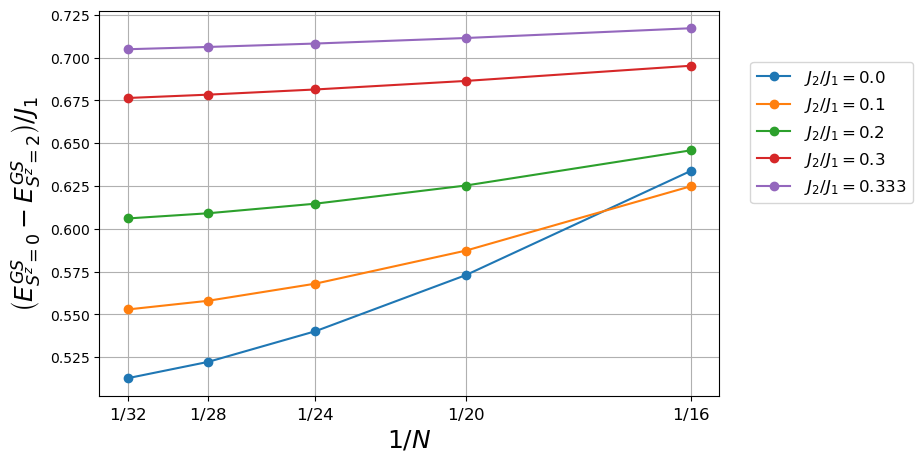

In [17]:
fig,ax = subplots(figsize=(8,5))
for i in 1:length(J2s)
    ax.plot(1 ./Ns,E_2[:,i]-E_0[:,i],"-o",label=L"$J_2/J_1=$"*string(round(J2s[i],digits=3)))
end
ax.legend(loc=(1.05,0.5),fontsize=12)
ax.set_xlabel(L"$1/N$", fontsize=18)
ax.set_xticks(1 ./Ns)
ax.set_xticklabels([L"1/" * string(N) for N in Ns ], fontsize=12)
ax.set_ylabel(L"\left(E^{GS}_{S^z=2}-E^{GS}_{S^z=0}\right)/J_1",fontsize=18)
# ax.set_xlim([0,1/16])
# ax.set_ylim([-0.6,0])
# ax.set_xscale("log")
ax.grid()

gcf()

## 2-2
*For the same values of $J_2$ as above, calculate the gap between the $S^z = 1$ and $S^z = 0$ sectors. Show that the gap decays exponentially with system size (i.e. the states are degenerate in the thermodynamic limit). Calculate the local expectation value of $S^z$ along the chain in the lowest energy state with $S^z = 1$ and show that the total spin accumulated near each edge is $\pm 1/2$.*

In [29]:
E_1 = zeros(length(Ns),length(J2s))
psis = []

for (i,N) in enumerate(Ns)
    for (j,J2) in enumerate(J2s)
        sites = siteinds("S=1", N; conserve_qns=true)
        H = AKLTHamiltonian(sites, J2)

        state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]
        state0[2] = "0"

        psi0 = randomMPS(sites,state0,linkdims=2)
        @show flux(psi0)
        E_1[i,j],psi = dmrg(H,psi0; nsweeps=50, maxdim=10, cutoff=1E-10)
        append!(psis, [psi])
    end
end

flux(psi0) = QN("Sz",2)
After sweep 1 energy=-20.631181785398198  maxlinkdim=10 maxerr=1.19E-04 time=0.100


After sweep 2 energy=-21.19650076139276  maxlinkdim=10 maxerr=1.63E-03 time=0.147


After sweep 3 energy=-21.197123943172745  maxlinkdim=10 maxerr=6.33E-05 time=0.138


After sweep 4 energy=-21.197124832891355  maxlinkdim=10 maxerr=5.79E-05 time=0.133


After sweep 5 energy=-21.197124770001913  maxlinkdim=10 maxerr=5.78E-05 time=0.135


After sweep 6 energy=-21.1971247654943  maxlinkdim=10 maxerr=5.78E-05 time=0.151


After sweep 7 energy=-21.197124765196065  maxlinkdim=10 maxerr=5.78E-05 time=0.141


After sweep 8 energy=-21.197124765176188  maxlinkdim=10 maxerr=5.78E-05 time=0.134


After sweep 9 energy=-21.197124765174873  maxlinkdim=10 maxerr=5.78E-05 time=0.135


After sweep 10 energy=-21.197124765174777  maxlinkdim=10 maxerr=5.78E-05 time=0.133


After sweep 11 energy=-21.197124765174745  maxlinkdim=10 maxerr=5.78E-05 time=0.134


After sweep 12 energy=-21.19712476517477  maxlinkdim=10 maxerr=5.78E-05 time=0.152


After sweep 13 energy=-21.197124765174806  maxlinkdim=10 maxerr=5.78E-05 time=0.140


After sweep 14 energy=-21.197124765174767  maxlinkdim=10 maxerr=5.78E-05 time=0.135


After sweep 15 energy=-21.197124765174745  maxlinkdim=10 maxerr=5.78E-05 time=0.135


After sweep 16 energy=-21.19712476517478  maxlinkdim=10 maxerr=5.78E-05 time=0.133


After sweep 17 energy=-21.197124765174788  maxlinkdim=10 maxerr=5.78E-05 time=0.134


After sweep 18 energy=-21.197124765174774  maxlinkdim=10 maxerr=5.78E-05 time=0.151


After sweep 19 energy=-21.197124765174788  maxlinkdim=10 maxerr=5.78E-05 time=0.133


After sweep 20 energy=-21.19712476517478  maxlinkdim=10 maxerr=5.78E-05 time=0.134


After sweep 21 energy=-21.197124765174784  maxlinkdim=10 maxerr=5.78E-05 time=0.133


After sweep 22 energy=-21.197124765174777  maxlinkdim=10 maxerr=5.78E-05 time=0.140


After sweep 23 energy=-21.197124765174763  maxlinkdim=10 maxerr=5.78E-05 time=0.141


After sweep 24 energy=-21.19712476517477  maxlinkdim=10 maxerr=5.78E-05 time=0.154


After sweep 25 energy=-21.19712476517477  maxlinkdim=10 maxerr=5.78E-05 time=0.133


After sweep 26 energy=-21.197124765174784  maxlinkdim=10 maxerr=5.78E-05 time=0.134


After sweep 27 energy=-21.197124765174774  maxlinkdim=10 maxerr=5.78E-05 time=0.133


After sweep 28 energy=-21.197124765174767  maxlinkdim=10 maxerr=5.78E-05 time=0.132


After sweep 29 energy=-21.19712476517478  maxlinkdim=10 maxerr=5.78E-05 time=0.152


After sweep 30 energy=-21.197124765174774  maxlinkdim=10 maxerr=5.78E-05 time=0.135


After sweep 31 energy=-21.19712476517477  maxlinkdim=10 maxerr=5.78E-05 time=0.135


After sweep 32 energy=-21.19712476517474  maxlinkdim=10 maxerr=5.78E-05 time=0.137


After sweep 33 energy=-21.19712476517477  maxlinkdim=10 maxerr=5.78E-05 time=0.133


After sweep 34 energy=-21.197124765174756  maxlinkdim=10 maxerr=5.78E-05 time=0.132


After sweep 35 energy=-21.19712476517476  maxlinkdim=10 maxerr=5.78E-05 time=0.151


After sweep 36 energy=-21.197124765174763  maxlinkdim=10 maxerr=5.78E-05 time=0.133


After sweep 37 energy=-21.197124765174745  maxlinkdim=10 maxerr=5.78E-05 time=0.138


After sweep 38 energy=-21.19712476517474  maxlinkdim=10 maxerr=5.78E-05 time=0.144


After sweep 39 energy=-21.197124765174777  maxlinkdim=10 maxerr=5.78E-05 time=0.201


After sweep 40 energy=-21.197124765174763  maxlinkdim=10 maxerr=5.78E-05 time=0.184


After sweep 41 energy=-21.197124765174756  maxlinkdim=10 maxerr=5.78E-05 time=0.155


After sweep 42 energy=-21.197124765174753  maxlinkdim=10 maxerr=5.78E-05 time=0.135


After sweep 43 energy=-21.19712476517476  maxlinkdim=10 maxerr=5.78E-05 time=0.145


After sweep 44 energy=-21.197124765174777  maxlinkdim=10 maxerr=5.78E-05 time=0.136


After sweep 45 energy=-21.19712476517478  maxlinkdim=10 maxerr=5.78E-05 time=0.137


After sweep 46 energy=-21.197124765174806  maxlinkdim=10 maxerr=5.78E-05 time=0.131


After sweep 47 energy=-21.197124765174777  maxlinkdim=10 maxerr=5.78E-05 time=0.149


After sweep 48 energy=-21.197124765174774  maxlinkdim=10 maxerr=5.78E-05 time=0.161


After sweep 49 energy=-21.19712476517477  maxlinkdim=10 maxerr=5.78E-05 time=0.135


After sweep 50 energy=-21.197124765174763  maxlinkdim=10 maxerr=5.78E-05 time=0.134


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-16.79405760425878  maxlinkdim=10 maxerr=2.41E-05 time=0.176


After sweep 2 energy=-17.622635949779017  maxlinkdim=10 maxerr=1.64E-03 time=0.286


After sweep 3 energy=-17.625624792606963  maxlinkdim=10 maxerr=2.00E-05 time=0.259


After sweep 4 energy=-17.625626772086544  maxlinkdim=10 maxerr=1.45E-05 time=0.248


After sweep 5 energy=-17.625626755671135  maxlinkdim=10 maxerr=1.44E-05 time=0.262


After sweep 6 energy=-17.625626754708634  maxlinkdim=10 maxerr=1.44E-05 time=0.260


After sweep 7 energy=-17.625626754662612  maxlinkdim=10 maxerr=1.44E-05 time=0.272


After sweep 8 energy=-17.62562675466033  maxlinkdim=10 maxerr=1.44E-05 time=0.268


After sweep 9 energy=-17.625626754660217  maxlinkdim=10 maxerr=1.44E-05 time=0.246


After sweep 10 energy=-17.625626754660203  maxlinkdim=10 maxerr=1.44E-05 time=0.260


After sweep 11 energy=-17.625626754660217  maxlinkdim=10 maxerr=1.44E-05 time=0.261


After sweep 12 energy=-17.625626754660203  maxlinkdim=10 maxerr=1.44E-05 time=0.260


After sweep 13 energy=-17.625626754660217  maxlinkdim=10 maxerr=1.44E-05 time=0.260


After sweep 14 energy=-17.625626754660225  maxlinkdim=10 maxerr=1.44E-05 time=0.243


After sweep 15 energy=-17.62562675466023  maxlinkdim=10 maxerr=1.44E-05 time=0.262


After sweep 16 energy=-17.625626754660217  maxlinkdim=10 maxerr=1.44E-05 time=0.263


After sweep 17 energy=-17.625626754660217  maxlinkdim=10 maxerr=1.44E-05 time=0.263


After sweep 18 energy=-17.62562675466023  maxlinkdim=10 maxerr=1.44E-05 time=0.245


After sweep 19 energy=-17.625626754660217  maxlinkdim=10 maxerr=1.44E-05 time=0.264


After sweep 20 energy=-17.625626754660225  maxlinkdim=10 maxerr=1.44E-05 time=0.263


After sweep 21 energy=-17.62562675466024  maxlinkdim=10 maxerr=1.44E-05 time=0.264


After sweep 22 energy=-17.62562675466021  maxlinkdim=10 maxerr=1.44E-05 time=0.262


After sweep 23 energy=-17.62562675466021  maxlinkdim=10 maxerr=1.44E-05 time=0.244


After sweep 24 energy=-17.625626754660225  maxlinkdim=10 maxerr=1.44E-05 time=0.263


After sweep 25 energy=-17.625626754660203  maxlinkdim=10 maxerr=1.44E-05 time=0.263


After sweep 26 energy=-17.625626754660225  maxlinkdim=10 maxerr=1.44E-05 time=0.267


After sweep 27 energy=-17.62562675466023  maxlinkdim=10 maxerr=1.44E-05 time=0.261


After sweep 28 energy=-17.62562675466021  maxlinkdim=10 maxerr=1.44E-05 time=0.293


After sweep 29 energy=-17.62562675466023  maxlinkdim=10 maxerr=1.44E-05 time=0.265


After sweep 30 energy=-17.62562675466021  maxlinkdim=10 maxerr=1.44E-05 time=0.263


After sweep 31 energy=-17.625626754660225  maxlinkdim=10 maxerr=1.44E-05 time=0.262


After sweep 32 energy=-17.625626754660217  maxlinkdim=10 maxerr=1.44E-05 time=0.245


After sweep 33 energy=-17.625626754660196  maxlinkdim=10 maxerr=1.44E-05 time=0.261


After sweep 34 energy=-17.625626754660217  maxlinkdim=10 maxerr=1.44E-05 time=0.315


After sweep 35 energy=-17.625626754660217  maxlinkdim=10 maxerr=1.44E-05 time=0.261


After sweep 36 energy=-17.625626754660225  maxlinkdim=10 maxerr=1.44E-05 time=0.258


After sweep 37 energy=-17.62562675466021  maxlinkdim=10 maxerr=1.44E-05 time=0.245


After sweep 38 energy=-17.62562675466023  maxlinkdim=10 maxerr=1.44E-05 time=0.263


After sweep 39 energy=-17.625626754660196  maxlinkdim=10 maxerr=1.44E-05 time=0.271


After sweep 40 energy=-17.62562675466022  maxlinkdim=10 maxerr=1.44E-05 time=0.257


After sweep 41 energy=-17.62562675466024  maxlinkdim=10 maxerr=1.44E-05 time=0.259


After sweep 42 energy=-17.625626754660225  maxlinkdim=10 maxerr=1.44E-05 time=0.243


After sweep 43 energy=-17.62562675466021  maxlinkdim=10 maxerr=1.44E-05 time=0.262


After sweep 44 energy=-17.625626754660203  maxlinkdim=10 maxerr=1.44E-05 time=0.258


After sweep 45 energy=-17.625626754660203  maxlinkdim=10 maxerr=1.44E-05 time=0.257


After sweep 46 energy=-17.625626754660207  maxlinkdim=10 maxerr=1.44E-05 time=0.244


After sweep 47 energy=-17.625626754660225  maxlinkdim=10 maxerr=1.44E-05 time=0.265


After sweep 48 energy=-17.625626754660225  maxlinkdim=10 maxerr=1.44E-05 time=0.262


After sweep 49 energy=-17.62562675466021  maxlinkdim=10 maxerr=1.44E-05 time=0.263


After sweep 50 energy=-17.625626754660246  maxlinkdim=10 maxerr=1.44E-05 time=0.263


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-13.44472009039918  maxlinkdim=10 maxerr=2.63E-04 time=0.183


After sweep 2 energy=-14.217288705157173  maxlinkdim=10 maxerr=1.26E-03 time=0.272


After sweep 3 energy=-14.217498101306184  maxlinkdim=10 maxerr=1.34E-06 time=0.258


After sweep 4 energy=-14.217498875795862  maxlinkdim=10 maxerr=1.13E-06 time=0.262


After sweep 5 energy=-14.217498958974886  maxlinkdim=10 maxerr=1.13E-06 time=0.248


After sweep 6 energy=-14.217498958791575  maxlinkdim=10 maxerr=1.12E-06 time=0.259


After sweep 7 energy=-14.217498958776448  maxlinkdim=10 maxerr=1.12E-06 time=0.262


After sweep 8 energy=-14.217498958775721  maxlinkdim=10 maxerr=1.12E-06 time=0.265


After sweep 9 energy=-14.217498958775678  maxlinkdim=10 maxerr=1.12E-06 time=0.260


After sweep 10 energy=-14.217498958775678  maxlinkdim=10 maxerr=1.12E-06 time=0.246


After sweep 11 energy=-14.217498958775675  maxlinkdim=10 maxerr=1.12E-06 time=0.260


After sweep 12 energy=-14.217498958775693  maxlinkdim=10 maxerr=1.12E-06 time=0.262


After sweep 13 energy=-14.21749895877568  maxlinkdim=10 maxerr=1.12E-06 time=0.265


After sweep 14 energy=-14.217498958775685  maxlinkdim=10 maxerr=1.12E-06 time=0.242


After sweep 15 energy=-14.217498958775666  maxlinkdim=10 maxerr=1.12E-06 time=0.258


After sweep 16 energy=-14.217498958775657  maxlinkdim=10 maxerr=1.12E-06 time=0.258


After sweep 17 energy=-14.217498958775685  maxlinkdim=10 maxerr=1.12E-06 time=0.262


After sweep 18 energy=-14.217498958775677  maxlinkdim=10 maxerr=1.12E-06 time=0.258


After sweep 19 energy=-14.217498958775675  maxlinkdim=10 maxerr=1.12E-06 time=0.242


After sweep 20 energy=-14.217498958775678  maxlinkdim=10 maxerr=1.12E-06 time=0.261


After sweep 21 energy=-14.217498958775657  maxlinkdim=10 maxerr=1.12E-06 time=0.257


After sweep 22 energy=-14.217498958775666  maxlinkdim=10 maxerr=1.12E-06 time=0.258


After sweep 23 energy=-14.217498958775646  maxlinkdim=10 maxerr=1.12E-06 time=0.239


After sweep 24 energy=-14.217498958775689  maxlinkdim=10 maxerr=1.12E-06 time=0.259


After sweep 25 energy=-14.217498958775685  maxlinkdim=10 maxerr=1.12E-06 time=0.258


After sweep 26 energy=-14.217498958775682  maxlinkdim=10 maxerr=1.12E-06 time=0.259


After sweep 27 energy=-14.217498958775684  maxlinkdim=10 maxerr=1.12E-06 time=0.256


After sweep 28 energy=-14.217498958775687  maxlinkdim=10 maxerr=1.12E-06 time=0.241


After sweep 29 energy=-14.217498958775675  maxlinkdim=10 maxerr=1.12E-06 time=0.261


After sweep 30 energy=-14.217498958775693  maxlinkdim=10 maxerr=1.12E-06 time=0.260


After sweep 31 energy=-14.217498958775684  maxlinkdim=10 maxerr=1.12E-06 time=0.259


After sweep 32 energy=-14.217498958775693  maxlinkdim=10 maxerr=1.12E-06 time=0.242


After sweep 33 energy=-14.217498958775687  maxlinkdim=10 maxerr=1.12E-06 time=0.266


After sweep 34 energy=-14.217498958775682  maxlinkdim=10 maxerr=1.12E-06 time=0.261


After sweep 35 energy=-14.217498958775673  maxlinkdim=10 maxerr=1.12E-06 time=0.258


After sweep 36 energy=-14.217498958775678  maxlinkdim=10 maxerr=1.12E-06 time=0.261


After sweep 37 energy=-14.21749895877568  maxlinkdim=10 maxerr=1.12E-06 time=0.241


After sweep 38 energy=-14.217498958775693  maxlinkdim=10 maxerr=1.12E-06 time=0.260


After sweep 39 energy=-14.217498958775668  maxlinkdim=10 maxerr=1.12E-06 time=0.259


After sweep 40 energy=-14.217498958775689  maxlinkdim=10 maxerr=1.12E-06 time=0.267


After sweep 41 energy=-14.217498958775703  maxlinkdim=10 maxerr=1.12E-06 time=0.243


After sweep 42 energy=-14.217498958775678  maxlinkdim=10 maxerr=1.12E-06 time=0.260


After sweep 43 energy=-14.217498958775689  maxlinkdim=10 maxerr=1.12E-06 time=0.260


After sweep 44 energy=-14.217498958775675  maxlinkdim=10 maxerr=1.12E-06 time=0.262


After sweep 45 energy=-14.217498958775678  maxlinkdim=10 maxerr=1.12E-06 time=0.265


After sweep 46 energy=-14.217498958775664  maxlinkdim=10 maxerr=1.12E-06 time=0.244


After sweep 47 energy=-14.217498958775701  maxlinkdim=10 maxerr=1.12E-06 time=0.270


After sweep 48 energy=-14.217498958775687  maxlinkdim=10 maxerr=1.12E-06 time=0.264


After sweep 49 energy=-14.217498958775693  maxlinkdim=10 maxerr=1.12E-06 time=0.271


After sweep 50 energy=-14.217498958775682  maxlinkdim=10 maxerr=1.12E-06 time=0.249


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-10.24406059483902  maxlinkdim=10 maxerr=4.29E-05 time=0.182


After sweep 2 energy=-10.29769676179182  maxlinkdim=10 maxerr=4.44E-05 time=0.293


After sweep 3 energy=-11.014346507703504  maxlinkdim=10 maxerr=6.30E-04 time=0.273


After sweep 4 energy=-11.01440903638202  maxlinkdim=10 maxerr=3.21E-07 time=0.257


After sweep 5 energy=-11.01440906471062  maxlinkdim=10 maxerr=1.73E-07 time=0.242


After sweep 6 energy=-11.014409064789898  maxlinkdim=10 maxerr=1.71E-07 time=0.260


After sweep 7 energy=-11.014409064792545  maxlinkdim=10 maxerr=1.71E-07 time=0.261


After sweep 8 energy=-11.014409064792664  maxlinkdim=10 maxerr=1.71E-07 time=0.260


After sweep 9 energy=-11.01440906479267  maxlinkdim=10 maxerr=1.71E-07 time=0.242


After sweep 10 energy=-11.014409064792657  maxlinkdim=10 maxerr=1.71E-07 time=0.261


After sweep 11 energy=-11.014409064792666  maxlinkdim=10 maxerr=1.71E-07 time=0.259


After sweep 12 energy=-11.014409064792655  maxlinkdim=10 maxerr=1.71E-07 time=0.354


After sweep 13 energy=-11.014409064792666  maxlinkdim=10 maxerr=1.71E-07 time=0.258


After sweep 14 energy=-11.014409064792652  maxlinkdim=10 maxerr=1.71E-07 time=0.258


After sweep 15 energy=-11.014409064792659  maxlinkdim=10 maxerr=1.71E-07 time=0.254


After sweep 16 energy=-11.014409064792659  maxlinkdim=10 maxerr=1.71E-07 time=0.239


After sweep 17 energy=-11.014409064792675  maxlinkdim=10 maxerr=1.71E-07 time=0.253


After sweep 18 energy=-11.014409064792678  maxlinkdim=10 maxerr=1.71E-07 time=0.256


After sweep 19 energy=-11.014409064792654  maxlinkdim=10 maxerr=1.71E-07 time=0.235


After sweep 20 energy=-11.01440906479267  maxlinkdim=10 maxerr=1.71E-07 time=0.256


After sweep 21 energy=-11.01440906479265  maxlinkdim=10 maxerr=1.71E-07 time=0.256


After sweep 22 energy=-11.014409064792645  maxlinkdim=10 maxerr=1.71E-07 time=0.252


After sweep 23 energy=-11.01440906479265  maxlinkdim=10 maxerr=1.71E-07 time=0.239


After sweep 24 energy=-11.014409064792675  maxlinkdim=10 maxerr=1.71E-07 time=0.258


After sweep 25 energy=-11.014409064792652  maxlinkdim=10 maxerr=1.71E-07 time=0.258


After sweep 26 energy=-11.014409064792675  maxlinkdim=10 maxerr=1.71E-07 time=0.252


After sweep 27 energy=-11.014409064792662  maxlinkdim=10 maxerr=1.71E-07 time=0.233


After sweep 28 energy=-11.01440906479267  maxlinkdim=10 maxerr=1.71E-07 time=0.254


After sweep 29 energy=-11.01440906479265  maxlinkdim=10 maxerr=1.71E-07 time=0.256


After sweep 30 energy=-11.014409064792659  maxlinkdim=10 maxerr=1.71E-07 time=0.236


After sweep 31 energy=-11.014409064792659  maxlinkdim=10 maxerr=1.71E-07 time=0.254


After sweep 32 energy=-11.014409064792664  maxlinkdim=10 maxerr=1.71E-07 time=0.255


After sweep 33 energy=-11.01440906479267  maxlinkdim=10 maxerr=1.71E-07 time=0.254


After sweep 34 energy=-11.014409064792655  maxlinkdim=10 maxerr=1.71E-07 time=0.236


After sweep 35 energy=-11.014409064792664  maxlinkdim=10 maxerr=1.71E-07 time=0.254


After sweep 36 energy=-11.014409064792666  maxlinkdim=10 maxerr=1.71E-07 time=0.256


After sweep 37 energy=-11.014409064792657  maxlinkdim=10 maxerr=1.71E-07 time=0.246


After sweep 38 energy=-11.014409064792654  maxlinkdim=10 maxerr=1.71E-07 time=0.256


After sweep 39 energy=-11.014409064792675  maxlinkdim=10 maxerr=1.71E-07 time=0.265


After sweep 40 energy=-11.014409064792668  maxlinkdim=10 maxerr=1.71E-07 time=0.256


After sweep 41 energy=-11.014409064792671  maxlinkdim=10 maxerr=1.71E-07 time=0.246


After sweep 42 energy=-11.014409064792634  maxlinkdim=10 maxerr=1.71E-07 time=0.253


After sweep 43 energy=-11.014409064792662  maxlinkdim=10 maxerr=1.71E-07 time=0.265


After sweep 44 energy=-11.014409064792677  maxlinkdim=10 maxerr=1.71E-07 time=0.266


After sweep 45 energy=-11.014409064792648  maxlinkdim=10 maxerr=1.71E-07 time=0.236


After sweep 46 energy=-11.014409064792655  maxlinkdim=10 maxerr=1.71E-07 time=0.299


After sweep 47 energy=-11.014409064792659  maxlinkdim=10 maxerr=1.71E-07 time=0.256


After sweep 48 energy=-11.01440906479267  maxlinkdim=10 maxerr=1.71E-07 time=0.238


After sweep 49 energy=-11.01440906479265  maxlinkdim=10 maxerr=1.71E-07 time=0.257


After sweep 50 energy=-11.014409064792664  maxlinkdim=10 maxerr=1.71E-07 time=0.255


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-9.100416445043274  maxlinkdim=10 maxerr=9.68E-05 time=0.194


After sweep 2 energy=-9.256022746682591  maxlinkdim=10 maxerr=2.57E-05 time=0.267


After sweep 3 energy=-9.998166653897142  maxlinkdim=10 maxerr=1.55E-05 time=0.281


After sweep 4 energy=-9.999999834216535  maxlinkdim=10 maxerr=3.94E-08 time=0.214


After sweep 5 energy=-9.999999999999844  maxlinkdim=2 maxerr=9.54E-11 time=0.094


After sweep 6 energy=-9.999999999999993  maxlinkdim=2 maxerr=2.76E-16 time=0.049


After sweep 7 energy=-10.000000000000002  maxlinkdim=2 maxerr=5.55E-17 time=0.049


After sweep 8 energy=-10.000000000000004  maxlinkdim=2 maxerr=5.55E-17 time=0.061


After sweep 9 energy=-10.0  maxlinkdim=2 maxerr=5.55E-17 time=0.026


After sweep 10 energy=-9.999999999999998  maxlinkdim=2 maxerr=5.55E-17 time=0.024


After sweep 11 energy=-9.999999999999998  maxlinkdim=2 maxerr=4.16E-17 time=0.023


After sweep 12 energy=-9.999999999999996  maxlinkdim=2 maxerr=4.16E-17 time=0.044


After sweep 13 energy=-10.0  maxlinkdim=2 maxerr=5.55E-17 time=0.023


After sweep 14 energy=-9.999999999999993  maxlinkdim=2 maxerr=5.55E-17 time=0.023


After sweep 15 energy=-10.0  maxlinkdim=2 maxerr=5.55E-17 time=0.024


After sweep 16 energy=-9.999999999999993  maxlinkdim=2 maxerr=6.94E-17 time=0.025


After sweep 17 energy=-10.0  maxlinkdim=2 maxerr=5.55E-17 time=0.044


After sweep 18 energy=-9.999999999999995  maxlinkdim=2 maxerr=5.55E-17 time=0.022


After sweep 19 energy=-10.0  maxlinkdim=2 maxerr=8.33E-17 time=0.023


After sweep 20 energy=-9.999999999999998  maxlinkdim=2 maxerr=6.94E-17 time=0.024


After sweep 21 energy=-9.999999999999998  maxlinkdim=2 maxerr=6.94E-17 time=0.024


After sweep 22 energy=-10.000000000000009  maxlinkdim=2 maxerr=5.55E-17 time=0.042


After sweep 23 energy=-10.000000000000002  maxlinkdim=2 maxerr=6.94E-17 time=0.023


After sweep 24 energy=-9.999999999999995  maxlinkdim=2 maxerr=8.33E-17 time=0.022


After sweep 25 energy=-9.999999999999998  maxlinkdim=2 maxerr=6.94E-17 time=0.024


After sweep 26 energy=-9.999999999999995  maxlinkdim=2 maxerr=8.33E-17 time=0.024


After sweep 27 energy=-10.0  maxlinkdim=2 maxerr=6.94E-17 time=0.044


After sweep 28 energy=-10.000000000000009  maxlinkdim=2 maxerr=6.94E-17 time=0.022


After sweep 29 energy=-10.0  maxlinkdim=2 maxerr=5.55E-17 time=0.022


After sweep 30 energy=-10.000000000000002  maxlinkdim=2 maxerr=6.94E-17 time=0.024


After sweep 31 energy=-10.0  maxlinkdim=2 maxerr=5.55E-17 time=0.022


After sweep 32 energy=-9.999999999999996  maxlinkdim=2 maxerr=4.16E-17 time=0.043


After sweep 33 energy=-10.000000000000002  maxlinkdim=2 maxerr=5.55E-17 time=0.022


After sweep 34 energy=-10.000000000000004  maxlinkdim=2 maxerr=8.33E-17 time=0.023


After sweep 35 energy=-10.0  maxlinkdim=2 maxerr=5.55E-17 time=0.023


After sweep 36 energy=-10.000000000000005  maxlinkdim=2 maxerr=6.94E-17 time=0.024


After sweep 37 energy=-10.000000000000002  maxlinkdim=2 maxerr=8.33E-17 time=0.042


After sweep 38 energy=-9.999999999999998  maxlinkdim=2 maxerr=5.55E-17 time=0.022


After sweep 39 energy=-9.999999999999998  maxlinkdim=2 maxerr=5.55E-17 time=0.024


After sweep 40 energy=-10.000000000000002  maxlinkdim=2 maxerr=5.55E-17 time=0.022


After sweep 41 energy=-10.000000000000012  maxlinkdim=2 maxerr=5.55E-17 time=0.029


After sweep 42 energy=-10.000000000000005  maxlinkdim=2 maxerr=5.55E-17 time=0.050


After sweep 43 energy=-10.000000000000002  maxlinkdim=2 maxerr=5.55E-17 time=0.027


After sweep 44 energy=-10.0  maxlinkdim=2 maxerr=5.55E-17 time=0.024


After sweep 45 energy=-10.000000000000004  maxlinkdim=2 maxerr=4.16E-17 time=0.023


After sweep 46 energy=-10.000000000000007  maxlinkdim=2 maxerr=5.55E-17 time=0.025


After sweep 47 energy=-10.0  maxlinkdim=2 maxerr=5.55E-17 time=0.022


After sweep 48 energy=-10.000000000000004  maxlinkdim=2 maxerr=6.94E-17 time=0.042


After sweep 49 energy=-9.999999999999995  maxlinkdim=2 maxerr=5.55E-17 time=0.022


After sweep 50 energy=-9.999999999999996  maxlinkdim=2 maxerr=5.55E-17 time=0.024


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-26.179709595512044  maxlinkdim=10 maxerr=5.72E-04 time=0.122


After sweep 2 energy=-26.80162113090945  maxlinkdim=10 maxerr=1.80E-03 time=0.181


After sweep 3 energy=-26.809624204945628  maxlinkdim=10 maxerr=8.70E-05 time=0.184


After sweep 4 energy=-26.809641172907284  maxlinkdim=10 maxerr=5.84E-05 time=0.165


After sweep 5 energy=-26.80964519136476  maxlinkdim=10 maxerr=5.81E-05 time=0.192


After sweep 6 energy=-26.8096452079633  maxlinkdim=10 maxerr=5.80E-05 time=0.167


After sweep 7 energy=-26.809645206018597  maxlinkdim=10 maxerr=5.80E-05 time=0.182


After sweep 8 energy=-26.809645205868613  maxlinkdim=10 maxerr=5.80E-05 time=0.169


After sweep 9 energy=-26.809645205858132  maxlinkdim=10 maxerr=5.80E-05 time=0.184


After sweep 10 energy=-26.809645205857436  maxlinkdim=10 maxerr=5.80E-05 time=0.165


After sweep 11 energy=-26.809645205857368  maxlinkdim=10 maxerr=5.80E-05 time=0.195


After sweep 12 energy=-26.809645205857365  maxlinkdim=10 maxerr=5.80E-05 time=0.181


After sweep 13 energy=-26.80964520585736  maxlinkdim=10 maxerr=5.80E-05 time=0.200


After sweep 14 energy=-26.809645205857354  maxlinkdim=10 maxerr=5.80E-05 time=0.173


After sweep 15 energy=-26.809645205857418  maxlinkdim=10 maxerr=5.80E-05 time=0.190


After sweep 16 energy=-26.80964520585739  maxlinkdim=10 maxerr=5.80E-05 time=0.169


After sweep 17 energy=-26.809645205857375  maxlinkdim=10 maxerr=5.80E-05 time=0.188


After sweep 18 energy=-26.809645205857358  maxlinkdim=10 maxerr=5.80E-05 time=0.169


After sweep 19 energy=-26.80964520585741  maxlinkdim=10 maxerr=5.80E-05 time=0.182


After sweep 20 energy=-26.809645205857347  maxlinkdim=10 maxerr=5.80E-05 time=0.169


After sweep 21 energy=-26.809645205857358  maxlinkdim=10 maxerr=5.80E-05 time=0.184


After sweep 22 energy=-26.8096452058574  maxlinkdim=10 maxerr=5.80E-05 time=0.164


After sweep 23 energy=-26.809645205857386  maxlinkdim=10 maxerr=5.80E-05 time=0.185


After sweep 24 energy=-26.809645205857347  maxlinkdim=10 maxerr=5.80E-05 time=0.166


After sweep 25 energy=-26.809645205857393  maxlinkdim=10 maxerr=5.80E-05 time=0.182


After sweep 26 energy=-26.809645205857322  maxlinkdim=10 maxerr=5.80E-05 time=0.169


After sweep 27 energy=-26.809645205857336  maxlinkdim=10 maxerr=5.80E-05 time=0.183


After sweep 28 energy=-26.809645205857347  maxlinkdim=10 maxerr=5.80E-05 time=0.169


After sweep 29 energy=-26.809645205857343  maxlinkdim=10 maxerr=5.80E-05 time=0.165


After sweep 30 energy=-26.809645205857347  maxlinkdim=10 maxerr=5.80E-05 time=0.185


After sweep 31 energy=-26.809645205857386  maxlinkdim=10 maxerr=5.80E-05 time=0.163


After sweep 32 energy=-26.809645205857368  maxlinkdim=10 maxerr=5.80E-05 time=0.186


After sweep 33 energy=-26.809645205857407  maxlinkdim=10 maxerr=5.80E-05 time=0.165


After sweep 34 energy=-26.80964520585739  maxlinkdim=10 maxerr=5.80E-05 time=0.185


After sweep 35 energy=-26.809645205857347  maxlinkdim=10 maxerr=5.80E-05 time=0.166


After sweep 36 energy=-26.80964520585735  maxlinkdim=10 maxerr=5.80E-05 time=0.184


After sweep 37 energy=-26.809645205857343  maxlinkdim=10 maxerr=5.80E-05 time=0.165


After sweep 38 energy=-26.80964520585736  maxlinkdim=10 maxerr=5.80E-05 time=0.185


After sweep 39 energy=-26.809645205857358  maxlinkdim=10 maxerr=5.80E-05 time=0.168


After sweep 40 energy=-26.809645205857343  maxlinkdim=10 maxerr=5.80E-05 time=0.184


After sweep 41 energy=-26.80964520585737  maxlinkdim=10 maxerr=5.80E-05 time=0.164


After sweep 42 energy=-26.80964520585738  maxlinkdim=10 maxerr=5.80E-05 time=0.184


After sweep 43 energy=-26.809645205857358  maxlinkdim=10 maxerr=5.80E-05 time=0.162


After sweep 44 energy=-26.809645205857347  maxlinkdim=10 maxerr=5.80E-05 time=0.184


After sweep 45 energy=-26.809645205857375  maxlinkdim=10 maxerr=5.80E-05 time=0.165


After sweep 46 energy=-26.809645205857382  maxlinkdim=10 maxerr=5.80E-05 time=0.182


After sweep 47 energy=-26.809645205857375  maxlinkdim=10 maxerr=5.80E-05 time=0.174


After sweep 48 energy=-26.80964520585734  maxlinkdim=10 maxerr=5.80E-05 time=0.184


After sweep 49 energy=-26.8096452058574  maxlinkdim=10 maxerr=5.80E-05 time=0.166


After sweep 50 energy=-26.809645205857414  maxlinkdim=10 maxerr=5.80E-05 time=0.186


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-21.374920343312542  maxlinkdim=10 maxerr=2.78E-05 time=0.255


After sweep 2 energy=-22.097545438808382  maxlinkdim=10 maxerr=2.32E-03 time=0.344


After sweep 3 energy=-22.302854944199165  maxlinkdim=10 maxerr=8.41E-05 time=0.346


After sweep 4 energy=-22.30290435648838  maxlinkdim=10 maxerr=1.46E-05 time=0.329


After sweep 5 energy=-22.3029074343587  maxlinkdim=10 maxerr=1.45E-05 time=0.322


After sweep 6 energy=-22.30290770284336  maxlinkdim=10 maxerr=1.45E-05 time=0.343


After sweep 7 energy=-22.30290769978095  maxlinkdim=10 maxerr=1.45E-05 time=0.326


After sweep 8 energy=-22.302907699656874  maxlinkdim=10 maxerr=1.45E-05 time=0.323


After sweep 9 energy=-22.302907699650266  maxlinkdim=10 maxerr=1.45E-05 time=0.326


After sweep 10 energy=-22.302907699649836  maxlinkdim=10 maxerr=1.45E-05 time=0.354


After sweep 11 energy=-22.30290769964983  maxlinkdim=10 maxerr=1.45E-05 time=0.330


After sweep 12 energy=-22.302907699649797  maxlinkdim=10 maxerr=1.45E-05 time=0.330


After sweep 13 energy=-22.302907699649754  maxlinkdim=10 maxerr=1.45E-05 time=0.333


After sweep 14 energy=-22.302907699649804  maxlinkdim=10 maxerr=1.45E-05 time=0.343


After sweep 15 energy=-22.302907699649825  maxlinkdim=10 maxerr=1.45E-05 time=0.325


After sweep 16 energy=-22.302907699649797  maxlinkdim=10 maxerr=1.45E-05 time=0.328


After sweep 17 energy=-22.302907699649754  maxlinkdim=10 maxerr=1.45E-05 time=0.343


After sweep 18 energy=-22.30290769964982  maxlinkdim=10 maxerr=1.45E-05 time=0.327


After sweep 19 energy=-22.302907699649804  maxlinkdim=10 maxerr=1.45E-05 time=0.327


After sweep 20 energy=-22.302907699649772  maxlinkdim=10 maxerr=1.45E-05 time=0.327


After sweep 21 energy=-22.3029076996498  maxlinkdim=10 maxerr=1.45E-05 time=0.344


After sweep 22 energy=-22.302907699649772  maxlinkdim=10 maxerr=1.45E-05 time=0.372


After sweep 23 energy=-22.302907699649804  maxlinkdim=10 maxerr=1.45E-05 time=0.323


After sweep 24 energy=-22.30290769964976  maxlinkdim=10 maxerr=1.45E-05 time=0.325


After sweep 25 energy=-22.302907699649744  maxlinkdim=10 maxerr=1.45E-05 time=0.355


After sweep 26 energy=-22.302907699649776  maxlinkdim=10 maxerr=1.45E-05 time=0.322


After sweep 27 energy=-22.302907699649797  maxlinkdim=10 maxerr=1.45E-05 time=0.323


After sweep 28 energy=-22.30290769964977  maxlinkdim=10 maxerr=1.45E-05 time=0.343


After sweep 29 energy=-22.302907699649758  maxlinkdim=10 maxerr=1.45E-05 time=0.322


After sweep 30 energy=-22.302907699649786  maxlinkdim=10 maxerr=1.45E-05 time=0.322


After sweep 31 energy=-22.3029076996498  maxlinkdim=10 maxerr=1.45E-05 time=0.326


After sweep 32 energy=-22.30290769964983  maxlinkdim=10 maxerr=1.45E-05 time=0.343


After sweep 33 energy=-22.302907699649797  maxlinkdim=10 maxerr=1.45E-05 time=0.325


After sweep 34 energy=-22.302907699649772  maxlinkdim=10 maxerr=1.45E-05 time=0.326


After sweep 35 energy=-22.302907699649783  maxlinkdim=10 maxerr=1.45E-05 time=0.385


After sweep 36 energy=-22.302907699649786  maxlinkdim=10 maxerr=1.45E-05 time=0.477


After sweep 37 energy=-22.302907699649776  maxlinkdim=10 maxerr=1.45E-05 time=0.339


After sweep 38 energy=-22.30290769964978  maxlinkdim=10 maxerr=1.45E-05 time=0.339


After sweep 39 energy=-22.302907699649797  maxlinkdim=10 maxerr=1.45E-05 time=0.348


After sweep 40 energy=-22.302907699649776  maxlinkdim=10 maxerr=1.45E-05 time=0.359


After sweep 41 energy=-22.302907699649786  maxlinkdim=10 maxerr=1.45E-05 time=0.340


After sweep 42 energy=-22.302907699649776  maxlinkdim=10 maxerr=1.45E-05 time=0.372


After sweep 43 energy=-22.302907699649808  maxlinkdim=10 maxerr=1.45E-05 time=0.365


After sweep 44 energy=-22.30290769964976  maxlinkdim=10 maxerr=1.45E-05 time=0.334


After sweep 45 energy=-22.302907699649783  maxlinkdim=10 maxerr=1.45E-05 time=0.341


After sweep 46 energy=-22.302907699649783  maxlinkdim=10 maxerr=1.45E-05 time=0.344


After sweep 47 energy=-22.302907699649765  maxlinkdim=10 maxerr=1.45E-05 time=0.355


After sweep 48 energy=-22.302907699649808  maxlinkdim=10 maxerr=1.45E-05 time=0.330


After sweep 49 energy=-22.30290769964979  maxlinkdim=10 maxerr=1.45E-05 time=0.374


After sweep 50 energy=-22.302907699649793  maxlinkdim=10 maxerr=1.45E-05 time=0.327


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-17.161015210706047  maxlinkdim=10 maxerr=4.47E-04 time=0.265


After sweep 2 energy=-17.99867523873476  maxlinkdim=10 maxerr=2.41E-03 time=0.369


After sweep 3 energy=-18.00016461479239  maxlinkdim=10 maxerr=1.43E-06 time=0.339


After sweep 4 energy=-18.000164888200384  maxlinkdim=10 maxerr=1.13E-06 time=0.354


After sweep 5 energy=-18.00016488746028  maxlinkdim=10 maxerr=1.13E-06 time=0.350


After sweep 6 energy=-18.00016488739937  maxlinkdim=10 maxerr=1.13E-06 time=0.332


After sweep 7 energy=-18.000164887395186  maxlinkdim=10 maxerr=1.13E-06 time=0.326


After sweep 8 energy=-18.00016488739488  maxlinkdim=10 maxerr=1.13E-06 time=0.353


After sweep 9 energy=-18.000164887394874  maxlinkdim=10 maxerr=1.13E-06 time=0.389


After sweep 10 energy=-18.00016488739486  maxlinkdim=10 maxerr=1.13E-06 time=0.337


After sweep 11 energy=-18.000164887394874  maxlinkdim=10 maxerr=1.13E-06 time=0.333


After sweep 12 energy=-18.000164887394867  maxlinkdim=10 maxerr=1.13E-06 time=0.351


After sweep 13 energy=-18.00016488739487  maxlinkdim=10 maxerr=1.13E-06 time=0.330


After sweep 14 energy=-18.000164887394902  maxlinkdim=10 maxerr=1.13E-06 time=0.388


After sweep 15 energy=-18.000164887394888  maxlinkdim=10 maxerr=1.13E-06 time=0.329


After sweep 16 energy=-18.000164887394842  maxlinkdim=10 maxerr=1.13E-06 time=0.345


After sweep 17 energy=-18.000164887394867  maxlinkdim=10 maxerr=1.13E-06 time=0.328


After sweep 18 energy=-18.000164887394853  maxlinkdim=10 maxerr=1.13E-06 time=0.327


After sweep 19 energy=-18.000164887394867  maxlinkdim=10 maxerr=1.13E-06 time=0.375


After sweep 20 energy=-18.000164887394888  maxlinkdim=10 maxerr=1.13E-06 time=0.391


After sweep 21 energy=-18.000164887394867  maxlinkdim=10 maxerr=1.13E-06 time=0.376


After sweep 22 energy=-18.0001648873949  maxlinkdim=10 maxerr=1.13E-06 time=0.371


After sweep 23 energy=-18.00016488739487  maxlinkdim=10 maxerr=1.13E-06 time=0.330


After sweep 24 energy=-18.000164887394895  maxlinkdim=10 maxerr=1.13E-06 time=0.358


After sweep 25 energy=-18.000164887394853  maxlinkdim=10 maxerr=1.13E-06 time=0.334


After sweep 26 energy=-18.000164887394916  maxlinkdim=10 maxerr=1.13E-06 time=0.338


After sweep 27 energy=-18.00016488739487  maxlinkdim=10 maxerr=1.13E-06 time=0.349


After sweep 28 energy=-18.000164887394867  maxlinkdim=10 maxerr=1.13E-06 time=0.323


After sweep 29 energy=-18.000164887394888  maxlinkdim=10 maxerr=1.13E-06 time=0.328


After sweep 30 energy=-18.000164887394874  maxlinkdim=10 maxerr=1.13E-06 time=0.323


After sweep 31 energy=-18.000164887394888  maxlinkdim=10 maxerr=1.13E-06 time=0.344


After sweep 32 energy=-18.00016488739486  maxlinkdim=10 maxerr=1.13E-06 time=0.326


After sweep 33 energy=-18.000164887394877  maxlinkdim=10 maxerr=1.13E-06 time=0.324


After sweep 34 energy=-18.000164887394853  maxlinkdim=10 maxerr=1.13E-06 time=0.324


After sweep 35 energy=-18.000164887394874  maxlinkdim=10 maxerr=1.13E-06 time=0.390


After sweep 36 energy=-18.00016488739489  maxlinkdim=10 maxerr=1.13E-06 time=0.339


After sweep 37 energy=-18.000164887394853  maxlinkdim=10 maxerr=1.13E-06 time=0.335


After sweep 38 energy=-18.000164887394867  maxlinkdim=10 maxerr=1.13E-06 time=0.408


After sweep 39 energy=-18.000164887394895  maxlinkdim=10 maxerr=1.13E-06 time=0.347


After sweep 40 energy=-18.00016488739488  maxlinkdim=10 maxerr=1.13E-06 time=0.328


After sweep 41 energy=-18.000164887394885  maxlinkdim=10 maxerr=1.13E-06 time=0.356


After sweep 42 energy=-18.000164887394867  maxlinkdim=10 maxerr=1.13E-06 time=0.422


After sweep 43 energy=-18.000164887394874  maxlinkdim=10 maxerr=1.13E-06 time=0.376


After sweep 44 energy=-18.00016488739488  maxlinkdim=10 maxerr=1.13E-06 time=0.329


After sweep 45 energy=-18.00016488739489  maxlinkdim=10 maxerr=1.13E-06 time=0.348


After sweep 46 energy=-18.000164887394867  maxlinkdim=10 maxerr=1.13E-06 time=0.327


After sweep 47 energy=-18.000164887394902  maxlinkdim=10 maxerr=1.13E-06 time=0.344


After sweep 48 energy=-18.000164887394874  maxlinkdim=10 maxerr=1.13E-06 time=0.341


After sweep 49 energy=-18.000164887394867  maxlinkdim=10 maxerr=1.13E-06 time=0.332


After sweep 50 energy=-18.000164887394874  maxlinkdim=10 maxerr=1.13E-06 time=0.342


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-12.396364253310992  maxlinkdim=10 maxerr=1.07E-04 time=0.261


After sweep 2 energy=-13.950668675925053  maxlinkdim=10 maxerr=6.32E-04 time=0.372


After sweep 3 energy=-13.950979494849696  maxlinkdim=10 maxerr=2.62E-07 time=0.325


After sweep 4 energy=-13.950979525716175  maxlinkdim=10 maxerr=1.71E-07 time=0.345


After sweep 5 energy=-13.950979525630725  maxlinkdim=10 maxerr=1.71E-07 time=0.348


After sweep 6 energy=-13.950979525627446  maxlinkdim=10 maxerr=1.71E-07 time=0.322


After sweep 7 energy=-13.950979525627325  maxlinkdim=10 maxerr=1.71E-07 time=0.327


After sweep 8 energy=-13.95097952562733  maxlinkdim=10 maxerr=1.71E-07 time=0.340


After sweep 9 energy=-13.950979525627297  maxlinkdim=10 maxerr=1.71E-07 time=0.342


After sweep 10 energy=-13.950979525627297  maxlinkdim=10 maxerr=1.71E-07 time=0.408


After sweep 11 energy=-13.950979525627304  maxlinkdim=10 maxerr=1.71E-07 time=0.336


After sweep 12 energy=-13.950979525627297  maxlinkdim=10 maxerr=1.71E-07 time=0.333


After sweep 13 energy=-13.95097952562731  maxlinkdim=10 maxerr=1.71E-07 time=0.365


After sweep 14 energy=-13.9509795256273  maxlinkdim=10 maxerr=1.71E-07 time=0.336


After sweep 15 energy=-13.950979525627318  maxlinkdim=10 maxerr=1.71E-07 time=0.339


After sweep 16 energy=-13.950979525627336  maxlinkdim=10 maxerr=1.71E-07 time=0.359


After sweep 17 energy=-13.950979525627321  maxlinkdim=10 maxerr=1.71E-07 time=0.340


After sweep 18 energy=-13.950979525627318  maxlinkdim=10 maxerr=1.71E-07 time=0.339


After sweep 19 energy=-13.950979525627321  maxlinkdim=10 maxerr=1.71E-07 time=0.337


After sweep 20 energy=-13.95097952562731  maxlinkdim=10 maxerr=1.71E-07 time=0.394


After sweep 21 energy=-13.950979525627321  maxlinkdim=10 maxerr=1.71E-07 time=0.360


After sweep 22 energy=-13.950979525627314  maxlinkdim=10 maxerr=1.71E-07 time=0.339


After sweep 23 energy=-13.950979525627307  maxlinkdim=10 maxerr=1.71E-07 time=0.339


After sweep 24 energy=-13.950979525627318  maxlinkdim=10 maxerr=1.71E-07 time=0.336


After sweep 25 energy=-13.950979525627282  maxlinkdim=10 maxerr=1.71E-07 time=0.339


After sweep 26 energy=-13.950979525627298  maxlinkdim=10 maxerr=1.71E-07 time=0.347


After sweep 27 energy=-13.950979525627325  maxlinkdim=10 maxerr=1.71E-07 time=0.338


After sweep 28 energy=-13.95097952562729  maxlinkdim=10 maxerr=1.71E-07 time=0.340


After sweep 29 energy=-13.950979525627321  maxlinkdim=10 maxerr=1.71E-07 time=0.334


After sweep 30 energy=-13.950979525627307  maxlinkdim=10 maxerr=1.71E-07 time=0.319


After sweep 31 energy=-13.95097952562731  maxlinkdim=10 maxerr=1.71E-07 time=0.388


After sweep 32 energy=-13.9509795256273  maxlinkdim=10 maxerr=1.71E-07 time=0.326


After sweep 33 energy=-13.950979525627293  maxlinkdim=10 maxerr=1.71E-07 time=0.320


After sweep 34 energy=-13.950979525627314  maxlinkdim=10 maxerr=1.71E-07 time=0.321


After sweep 35 energy=-13.950979525627304  maxlinkdim=10 maxerr=1.71E-07 time=0.322


After sweep 36 energy=-13.950979525627314  maxlinkdim=10 maxerr=1.71E-07 time=0.363


After sweep 37 energy=-13.950979525627307  maxlinkdim=10 maxerr=1.71E-07 time=0.325


After sweep 38 energy=-13.950979525627307  maxlinkdim=10 maxerr=1.71E-07 time=0.363


After sweep 39 energy=-13.950979525627304  maxlinkdim=10 maxerr=1.71E-07 time=0.425


After sweep 40 energy=-13.950979525627307  maxlinkdim=10 maxerr=1.71E-07 time=0.323


After sweep 41 energy=-13.950979525627298  maxlinkdim=10 maxerr=1.71E-07 time=0.365


After sweep 42 energy=-13.950979525627295  maxlinkdim=10 maxerr=1.71E-07 time=0.347


After sweep 43 energy=-13.950979525627304  maxlinkdim=10 maxerr=1.71E-07 time=0.322


After sweep 44 energy=-13.950979525627305  maxlinkdim=10 maxerr=1.71E-07 time=0.354


After sweep 45 energy=-13.950979525627279  maxlinkdim=10 maxerr=1.71E-07 time=0.340


After sweep 46 energy=-13.950979525627288  maxlinkdim=10 maxerr=1.71E-07 time=0.350


After sweep 47 energy=-13.950979525627318  maxlinkdim=10 maxerr=1.71E-07 time=0.337


After sweep 48 energy=-13.950979525627314  maxlinkdim=10 maxerr=1.71E-07 time=0.344


After sweep 49 energy=-13.95097952562731  maxlinkdim=10 maxerr=1.71E-07 time=0.327


After sweep 50 energy=-13.950979525627314  maxlinkdim=10 maxerr=1.71E-07 time=0.339


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-11.854259629189876  maxlinkdim=10 maxerr=4.42E-05 time=0.247


After sweep 2 energy=-11.933796045151173  maxlinkdim=10 maxerr=2.31E-05 time=0.390


After sweep 3 energy=-11.944596157259497  maxlinkdim=10 maxerr=2.45E-05 time=0.366


After sweep 4 energy=-12.66583620569728  maxlinkdim=10 maxerr=7.49E-06 time=0.399


After sweep 5 energy=-12.666666627242677  maxlinkdim=10 maxerr=2.51E-08 time=0.211


After sweep 6 energy=-12.66666666666614  maxlinkdim=2 maxerr=7.00E-11 time=0.101


After sweep 7 energy=-12.66666666666667  maxlinkdim=2 maxerr=9.73E-16 time=0.085


After sweep 8 energy=-12.666666666666664  maxlinkdim=2 maxerr=6.94E-17 time=0.066


After sweep 9 energy=-12.666666666666671  maxlinkdim=2 maxerr=5.55E-17 time=0.070


After sweep 10 energy=-12.666666666666664  maxlinkdim=2 maxerr=5.55E-17 time=0.036


After sweep 11 energy=-12.66666666666667  maxlinkdim=2 maxerr=5.55E-17 time=0.031


After sweep 12 energy=-12.66666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.048


After sweep 13 energy=-12.666666666666668  maxlinkdim=2 maxerr=6.94E-17 time=0.030


After sweep 14 energy=-12.66666666666667  maxlinkdim=2 maxerr=5.55E-17 time=0.030


After sweep 15 energy=-12.666666666666666  maxlinkdim=2 maxerr=5.55E-17 time=0.030


After sweep 16 energy=-12.666666666666655  maxlinkdim=2 maxerr=5.55E-17 time=0.036


After sweep 17 energy=-12.666666666666663  maxlinkdim=2 maxerr=6.94E-17 time=0.052


After sweep 18 energy=-12.66666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.032


After sweep 19 energy=-12.66666666666666  maxlinkdim=2 maxerr=5.55E-17 time=0.029


After sweep 20 energy=-12.666666666666659  maxlinkdim=2 maxerr=5.55E-17 time=0.035


After sweep 21 energy=-12.66666666666667  maxlinkdim=2 maxerr=5.55E-17 time=0.051


After sweep 22 energy=-12.666666666666655  maxlinkdim=2 maxerr=6.94E-17 time=0.051


After sweep 23 energy=-12.666666666666657  maxlinkdim=2 maxerr=6.94E-17 time=0.076


After sweep 24 energy=-12.666666666666655  maxlinkdim=2 maxerr=6.94E-17 time=0.057


After sweep 25 energy=-12.666666666666657  maxlinkdim=2 maxerr=5.55E-17 time=0.073


After sweep 26 energy=-12.666666666666666  maxlinkdim=2 maxerr=5.55E-17 time=0.035


After sweep 27 energy=-12.66666666666668  maxlinkdim=2 maxerr=5.55E-17 time=0.035


After sweep 28 energy=-12.666666666666659  maxlinkdim=2 maxerr=5.55E-17 time=0.040


After sweep 29 energy=-12.66666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.051


After sweep 30 energy=-12.666666666666654  maxlinkdim=2 maxerr=5.55E-17 time=0.029


After sweep 31 energy=-12.66666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.030


After sweep 32 energy=-12.666666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.034


After sweep 33 energy=-12.66666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.058


After sweep 34 energy=-12.666666666666663  maxlinkdim=2 maxerr=6.94E-17 time=0.029


After sweep 35 energy=-12.666666666666663  maxlinkdim=2 maxerr=5.55E-17 time=0.030


After sweep 36 energy=-12.666666666666657  maxlinkdim=2 maxerr=5.55E-17 time=0.030


After sweep 37 energy=-12.666666666666668  maxlinkdim=2 maxerr=6.94E-17 time=0.050


After sweep 38 energy=-12.66666666666667  maxlinkdim=2 maxerr=5.55E-17 time=0.028


After sweep 39 energy=-12.666666666666666  maxlinkdim=2 maxerr=5.55E-17 time=0.031


After sweep 40 energy=-12.66666666666666  maxlinkdim=2 maxerr=5.55E-17 time=0.031


After sweep 41 energy=-12.66666666666666  maxlinkdim=2 maxerr=5.55E-17 time=0.049


After sweep 42 energy=-12.666666666666675  maxlinkdim=2 maxerr=5.55E-17 time=0.029


After sweep 43 energy=-12.666666666666664  maxlinkdim=2 maxerr=5.55E-17 time=0.028


After sweep 44 energy=-12.666666666666668  maxlinkdim=2 maxerr=8.33E-17 time=0.030


After sweep 45 energy=-12.666666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.049


After sweep 46 energy=-12.666666666666664  maxlinkdim=2 maxerr=8.33E-17 time=0.030


After sweep 47 energy=-12.666666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.030


After sweep 48 energy=-12.666666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.031


After sweep 49 energy=-12.666666666666671  maxlinkdim=2 maxerr=6.94E-17 time=0.049


After sweep 50 energy=-12.666666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.029


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-31.395755512862472  maxlinkdim=10 maxerr=7.75E-05 time=0.188


After sweep 2 energy=-31.881400005070923  maxlinkdim=10 maxerr=8.43E-04 time=0.231


After sweep 3 energy=-32.41481701354232  maxlinkdim=10 maxerr=2.16E-03 time=0.218


After sweep 4 energy=-32.41815236571524  maxlinkdim=10 maxerr=6.82E-05 time=0.246


After sweep 5 energy=-32.41816623854278  maxlinkdim=10 maxerr=5.78E-05 time=0.220


After sweep 6 energy=-32.41817074282434  maxlinkdim=10 maxerr=5.76E-05 time=0.219


After sweep 7 energy=-32.418170767380296  maxlinkdim=10 maxerr=5.76E-05 time=0.217


After sweep 8 energy=-32.41817076651891  maxlinkdim=10 maxerr=5.76E-05 time=0.204


After sweep 9 energy=-32.41817076642425  maxlinkdim=10 maxerr=5.76E-05 time=0.219


After sweep 10 energy=-32.41817076641608  maxlinkdim=10 maxerr=5.76E-05 time=0.219


After sweep 11 energy=-32.41817076641546  maxlinkdim=10 maxerr=5.76E-05 time=0.223


After sweep 12 energy=-32.41817076641535  maxlinkdim=10 maxerr=5.76E-05 time=0.225


After sweep 13 energy=-32.41817076641539  maxlinkdim=10 maxerr=5.76E-05 time=0.206


After sweep 14 energy=-32.418170766415386  maxlinkdim=10 maxerr=5.76E-05 time=0.262


After sweep 15 energy=-32.418170766415344  maxlinkdim=10 maxerr=5.76E-05 time=0.219


After sweep 16 energy=-32.4181707664154  maxlinkdim=10 maxerr=5.76E-05 time=0.218


After sweep 17 energy=-32.41817076641538  maxlinkdim=10 maxerr=5.76E-05 time=0.197


After sweep 18 energy=-32.41817076641543  maxlinkdim=10 maxerr=5.76E-05 time=0.224


After sweep 19 energy=-32.41817076641537  maxlinkdim=10 maxerr=5.76E-05 time=0.218


After sweep 20 energy=-32.41817076641538  maxlinkdim=10 maxerr=5.76E-05 time=0.225


After sweep 21 energy=-32.41817076641543  maxlinkdim=10 maxerr=5.76E-05 time=0.226


After sweep 22 energy=-32.41817076641532  maxlinkdim=10 maxerr=5.76E-05 time=0.203


After sweep 23 energy=-32.4181707664153  maxlinkdim=10 maxerr=5.76E-05 time=0.222


After sweep 24 energy=-32.418170766415436  maxlinkdim=10 maxerr=5.76E-05 time=0.308


After sweep 25 energy=-32.418170766415386  maxlinkdim=10 maxerr=5.76E-05 time=0.236


After sweep 26 energy=-32.418170766415315  maxlinkdim=10 maxerr=5.76E-05 time=0.201


After sweep 27 energy=-32.41817076641541  maxlinkdim=10 maxerr=5.76E-05 time=0.221


After sweep 28 energy=-32.418170766415386  maxlinkdim=10 maxerr=5.76E-05 time=0.219


After sweep 29 energy=-32.41817076641534  maxlinkdim=10 maxerr=5.76E-05 time=0.218


After sweep 30 energy=-32.418170766415365  maxlinkdim=10 maxerr=5.76E-05 time=0.220


After sweep 31 energy=-32.41817076641537  maxlinkdim=10 maxerr=5.76E-05 time=0.202


After sweep 32 energy=-32.4181707664154  maxlinkdim=10 maxerr=5.76E-05 time=0.237


After sweep 33 energy=-32.418170766415315  maxlinkdim=10 maxerr=5.76E-05 time=0.218


After sweep 34 energy=-32.418170766415464  maxlinkdim=10 maxerr=5.76E-05 time=0.226


After sweep 35 energy=-32.418170766415344  maxlinkdim=10 maxerr=5.76E-05 time=0.234


After sweep 36 energy=-32.418170766415386  maxlinkdim=10 maxerr=5.76E-05 time=0.202


After sweep 37 energy=-32.418170766415344  maxlinkdim=10 maxerr=5.76E-05 time=0.221


After sweep 38 energy=-32.41817076641534  maxlinkdim=10 maxerr=5.76E-05 time=0.236


After sweep 39 energy=-32.418170766415386  maxlinkdim=10 maxerr=5.76E-05 time=0.225


After sweep 40 energy=-32.41817076641535  maxlinkdim=10 maxerr=5.76E-05 time=0.204


After sweep 41 energy=-32.4181707664154  maxlinkdim=10 maxerr=5.76E-05 time=0.226


After sweep 42 energy=-32.41817076641537  maxlinkdim=10 maxerr=5.76E-05 time=0.220


After sweep 43 energy=-32.41817076641543  maxlinkdim=10 maxerr=5.76E-05 time=0.225


After sweep 44 energy=-32.41817076641537  maxlinkdim=10 maxerr=5.76E-05 time=0.221


After sweep 45 energy=-32.418170766415365  maxlinkdim=10 maxerr=5.76E-05 time=0.202


After sweep 46 energy=-32.4181707664153  maxlinkdim=10 maxerr=5.76E-05 time=0.228


After sweep 47 energy=-32.41817076641534  maxlinkdim=10 maxerr=5.76E-05 time=0.219


After sweep 48 energy=-32.418170766415365  maxlinkdim=10 maxerr=5.76E-05 time=0.223


After sweep 49 energy=-32.41817076641537  maxlinkdim=10 maxerr=5.76E-05 time=0.206


After sweep 50 energy=-32.4181707664153  maxlinkdim=10 maxerr=5.76E-05 time=0.218


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-25.935015299028233  maxlinkdim=10 maxerr=6.72E-04 time=0.296


After sweep 2 energy=-26.977110902530534  maxlinkdim=10 maxerr=2.31E-03 time=0.473


After sweep 3 energy=-26.978441802834382  maxlinkdim=10 maxerr=1.72E-05 time=0.427


After sweep 4 energy=-26.978445157455468  maxlinkdim=10 maxerr=1.45E-05 time=0.414


After sweep 5 energy=-26.97844535772223  maxlinkdim=10 maxerr=1.44E-05 time=0.467


After sweep 6 energy=-26.978445354342576  maxlinkdim=10 maxerr=1.44E-05 time=0.467


After sweep 7 energy=-26.97844535421581  maxlinkdim=10 maxerr=1.44E-05 time=0.512


After sweep 8 energy=-26.9784453542084  maxlinkdim=10 maxerr=1.44E-05 time=0.422


After sweep 9 energy=-26.978445354207942  maxlinkdim=10 maxerr=1.44E-05 time=0.474


After sweep 10 energy=-26.978445354207853  maxlinkdim=10 maxerr=1.44E-05 time=0.502


After sweep 11 energy=-26.978445354207913  maxlinkdim=10 maxerr=1.44E-05 time=0.412


After sweep 12 energy=-26.978445354207896  maxlinkdim=10 maxerr=1.44E-05 time=0.470


After sweep 13 energy=-26.978445354207878  maxlinkdim=10 maxerr=1.44E-05 time=0.461


After sweep 14 energy=-26.978445354207913  maxlinkdim=10 maxerr=1.44E-05 time=0.474


After sweep 15 energy=-26.978445354207857  maxlinkdim=10 maxerr=1.44E-05 time=0.417


After sweep 16 energy=-26.978445354207867  maxlinkdim=10 maxerr=1.44E-05 time=0.451


After sweep 17 energy=-26.978445354207892  maxlinkdim=10 maxerr=1.44E-05 time=0.449


After sweep 18 energy=-26.978445354207846  maxlinkdim=10 maxerr=1.44E-05 time=0.403


After sweep 19 energy=-26.97844535420783  maxlinkdim=10 maxerr=1.44E-05 time=0.418


After sweep 20 energy=-26.978445354207885  maxlinkdim=10 maxerr=1.44E-05 time=0.425


After sweep 21 energy=-26.978445354207853  maxlinkdim=10 maxerr=1.44E-05 time=0.400


After sweep 22 energy=-26.97844535420786  maxlinkdim=10 maxerr=1.44E-05 time=0.430


After sweep 23 energy=-26.97844535420783  maxlinkdim=10 maxerr=1.44E-05 time=0.415


After sweep 24 energy=-26.978445354207892  maxlinkdim=10 maxerr=1.44E-05 time=0.430


After sweep 25 energy=-26.978445354207835  maxlinkdim=10 maxerr=1.44E-05 time=0.402


After sweep 26 energy=-26.978445354207857  maxlinkdim=10 maxerr=1.44E-05 time=0.442


After sweep 27 energy=-26.978445354207857  maxlinkdim=10 maxerr=1.44E-05 time=0.441


After sweep 28 energy=-26.978445354207892  maxlinkdim=10 maxerr=1.44E-05 time=0.469


After sweep 29 energy=-26.978445354207853  maxlinkdim=10 maxerr=1.44E-05 time=0.430


After sweep 30 energy=-26.97844535420788  maxlinkdim=10 maxerr=1.44E-05 time=0.421


After sweep 31 energy=-26.97844535420784  maxlinkdim=10 maxerr=1.44E-05 time=0.419


After sweep 32 energy=-26.978445354207867  maxlinkdim=10 maxerr=1.44E-05 time=0.406


After sweep 33 energy=-26.97844535420792  maxlinkdim=10 maxerr=1.44E-05 time=0.417


After sweep 34 energy=-26.97844535420785  maxlinkdim=10 maxerr=1.44E-05 time=0.425


After sweep 35 energy=-26.978445354207842  maxlinkdim=10 maxerr=1.44E-05 time=0.400


After sweep 36 energy=-26.9784453542079  maxlinkdim=10 maxerr=1.44E-05 time=0.452


After sweep 37 energy=-26.978445354207842  maxlinkdim=10 maxerr=1.44E-05 time=0.484


After sweep 38 energy=-26.978445354207896  maxlinkdim=10 maxerr=1.44E-05 time=0.430


After sweep 39 energy=-26.97844535420788  maxlinkdim=10 maxerr=1.44E-05 time=0.474


After sweep 40 energy=-26.978445354207874  maxlinkdim=10 maxerr=1.44E-05 time=0.443


After sweep 41 energy=-26.978445354207892  maxlinkdim=10 maxerr=1.44E-05 time=0.430


After sweep 42 energy=-26.97844535420783  maxlinkdim=10 maxerr=1.44E-05 time=0.403


After sweep 43 energy=-26.978445354207828  maxlinkdim=10 maxerr=1.44E-05 time=0.415


After sweep 44 energy=-26.97844535420789  maxlinkdim=10 maxerr=1.44E-05 time=0.418


After sweep 45 energy=-26.97844535420792  maxlinkdim=10 maxerr=1.44E-05 time=0.400


After sweep 46 energy=-26.978445354207853  maxlinkdim=10 maxerr=1.44E-05 time=0.435


After sweep 47 energy=-26.978445354207885  maxlinkdim=10 maxerr=1.44E-05 time=0.501


After sweep 48 energy=-26.978445354207896  maxlinkdim=10 maxerr=1.44E-05 time=0.409


After sweep 49 energy=-26.978445354207867  maxlinkdim=10 maxerr=1.44E-05 time=0.406


After sweep 50 energy=-26.978445354207892  maxlinkdim=10 maxerr=1.44E-05 time=0.441


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-18.51408329790458  maxlinkdim=10 maxerr=7.66E-04 time=0.335


After sweep 2 energy=-20.42083684879098  maxlinkdim=10 maxerr=7.18E-04 time=0.470


After sweep 3 energy=-21.78144324960505  maxlinkdim=10 maxerr=1.13E-03 time=0.466


After sweep 4 energy=-21.782474019881874  maxlinkdim=10 maxerr=1.13E-06 time=0.437


After sweep 5 energy=-21.78247488109329  maxlinkdim=10 maxerr=1.13E-06 time=0.414


After sweep 6 energy=-21.78247509304807  maxlinkdim=10 maxerr=1.13E-06 time=0.396


After sweep 7 energy=-21.782475126483256  maxlinkdim=10 maxerr=1.13E-06 time=0.415


After sweep 8 energy=-21.782475126398708  maxlinkdim=10 maxerr=1.13E-06 time=0.419


After sweep 9 energy=-21.782475126396193  maxlinkdim=10 maxerr=1.13E-06 time=0.447


After sweep 10 energy=-21.782475126396093  maxlinkdim=10 maxerr=1.13E-06 time=0.419


After sweep 11 energy=-21.782475126396122  maxlinkdim=10 maxerr=1.13E-06 time=0.414


After sweep 12 energy=-21.782475126396108  maxlinkdim=10 maxerr=1.13E-06 time=0.398


After sweep 13 energy=-21.782475126396154  maxlinkdim=10 maxerr=1.13E-06 time=0.414


After sweep 14 energy=-21.7824751263961  maxlinkdim=10 maxerr=1.13E-06 time=0.416


After sweep 15 energy=-21.78247512639613  maxlinkdim=10 maxerr=1.13E-06 time=0.396


After sweep 16 energy=-21.7824751263961  maxlinkdim=10 maxerr=1.13E-06 time=0.427


After sweep 17 energy=-21.782475126396125  maxlinkdim=10 maxerr=1.13E-06 time=0.416


After sweep 18 energy=-21.782475126396122  maxlinkdim=10 maxerr=1.13E-06 time=0.398


After sweep 19 energy=-21.782475126396093  maxlinkdim=10 maxerr=1.13E-06 time=0.417


After sweep 20 energy=-21.782475126396125  maxlinkdim=10 maxerr=1.13E-06 time=0.413


After sweep 21 energy=-21.782475126396168  maxlinkdim=10 maxerr=1.13E-06 time=0.398


After sweep 22 energy=-21.782475126396168  maxlinkdim=10 maxerr=1.13E-06 time=0.478


After sweep 23 energy=-21.78247512639615  maxlinkdim=10 maxerr=1.13E-06 time=0.430


After sweep 24 energy=-21.78247512639614  maxlinkdim=10 maxerr=1.13E-06 time=0.414


After sweep 25 energy=-21.782475126396132  maxlinkdim=10 maxerr=1.13E-06 time=0.436


After sweep 26 energy=-21.7824751263961  maxlinkdim=10 maxerr=1.13E-06 time=0.428


After sweep 27 energy=-21.7824751263961  maxlinkdim=10 maxerr=1.13E-06 time=0.495


After sweep 28 energy=-21.782475126396097  maxlinkdim=10 maxerr=1.13E-06 time=0.432


After sweep 29 energy=-21.78247512639614  maxlinkdim=10 maxerr=1.13E-06 time=0.417


After sweep 30 energy=-21.782475126396157  maxlinkdim=10 maxerr=1.13E-06 time=0.402


After sweep 31 energy=-21.78247512639611  maxlinkdim=10 maxerr=1.13E-06 time=0.466


After sweep 32 energy=-21.782475126396175  maxlinkdim=10 maxerr=1.13E-06 time=0.424


After sweep 33 energy=-21.782475126396157  maxlinkdim=10 maxerr=1.13E-06 time=0.467


After sweep 34 energy=-21.78247512639615  maxlinkdim=10 maxerr=1.13E-06 time=0.478


After sweep 35 energy=-21.782475126396164  maxlinkdim=10 maxerr=1.13E-06 time=0.450


After sweep 36 energy=-21.78247512639614  maxlinkdim=10 maxerr=1.13E-06 time=0.437


After sweep 37 energy=-21.78247512639612  maxlinkdim=10 maxerr=1.13E-06 time=0.433


After sweep 38 energy=-21.78247512639611  maxlinkdim=10 maxerr=1.13E-06 time=0.461


After sweep 39 energy=-21.78247512639616  maxlinkdim=10 maxerr=1.13E-06 time=0.464


After sweep 40 energy=-21.782475126396125  maxlinkdim=10 maxerr=1.13E-06 time=0.481


After sweep 41 energy=-21.78247512639618  maxlinkdim=10 maxerr=1.13E-06 time=0.503


After sweep 42 energy=-21.782475126396143  maxlinkdim=10 maxerr=1.13E-06 time=0.530


After sweep 43 energy=-21.782475126396154  maxlinkdim=10 maxerr=1.13E-06 time=0.447


After sweep 44 energy=-21.782475126396175  maxlinkdim=10 maxerr=1.13E-06 time=0.421


After sweep 45 energy=-21.782475126396147  maxlinkdim=10 maxerr=1.13E-06 time=0.461


After sweep 46 energy=-21.782475126396136  maxlinkdim=10 maxerr=1.13E-06 time=0.494


After sweep 47 energy=-21.782475126396136  maxlinkdim=10 maxerr=1.13E-06 time=0.440


After sweep 48 energy=-21.782475126396136  maxlinkdim=10 maxerr=1.13E-06 time=0.459


After sweep 49 energy=-21.782475126396168  maxlinkdim=10 maxerr=1.13E-06 time=0.475


After sweep 50 energy=-21.782475126396115  maxlinkdim=10 maxerr=1.13E-06 time=0.406


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-15.363786197179  maxlinkdim=10 maxerr=1.46E-04 time=0.287


After sweep 2 energy=-16.137733850801236  maxlinkdim=10 maxerr=1.55E-04 time=0.492


After sweep 3 energy=-16.715247379806996  maxlinkdim=10 maxerr=3.62E-04 time=0.430


After sweep 4 energy=-16.887541814850174  maxlinkdim=10 maxerr=1.38E-05 time=0.402


After sweep 5 energy=-16.887545460266185  maxlinkdim=10 maxerr=1.72E-07 time=0.383


After sweep 6 energy=-16.887545499102906  maxlinkdim=10 maxerr=1.71E-07 time=0.416


After sweep 7 energy=-16.887545499233866  maxlinkdim=10 maxerr=1.71E-07 time=0.521


After sweep 8 energy=-16.887545499234673  maxlinkdim=10 maxerr=1.71E-07 time=0.422


After sweep 9 energy=-16.887545499234736  maxlinkdim=10 maxerr=1.71E-07 time=0.406


After sweep 10 energy=-16.88754549923468  maxlinkdim=10 maxerr=1.71E-07 time=0.431


After sweep 11 energy=-16.88754549923469  maxlinkdim=10 maxerr=1.71E-07 time=0.400


After sweep 12 energy=-16.887545499234683  maxlinkdim=10 maxerr=1.71E-07 time=0.414


After sweep 13 energy=-16.887545499234694  maxlinkdim=10 maxerr=1.71E-07 time=0.398


After sweep 14 energy=-16.88754549923469  maxlinkdim=10 maxerr=1.71E-07 time=0.404


After sweep 15 energy=-16.887545499234694  maxlinkdim=10 maxerr=1.71E-07 time=0.394


After sweep 16 energy=-16.887545499234676  maxlinkdim=10 maxerr=1.71E-07 time=0.427


After sweep 17 energy=-16.88754549923467  maxlinkdim=10 maxerr=1.71E-07 time=0.392


After sweep 18 energy=-16.887545499234697  maxlinkdim=10 maxerr=1.71E-07 time=0.406


After sweep 19 energy=-16.887545499234726  maxlinkdim=10 maxerr=1.71E-07 time=0.417


After sweep 20 energy=-16.8875454992347  maxlinkdim=10 maxerr=1.71E-07 time=0.417


After sweep 21 energy=-16.887545499234715  maxlinkdim=10 maxerr=1.71E-07 time=0.396


After sweep 22 energy=-16.887545499234715  maxlinkdim=10 maxerr=1.71E-07 time=0.402


After sweep 23 energy=-16.887545499234715  maxlinkdim=10 maxerr=1.71E-07 time=0.420


After sweep 24 energy=-16.88754549923471  maxlinkdim=10 maxerr=1.71E-07 time=0.410


After sweep 25 energy=-16.88754549923471  maxlinkdim=10 maxerr=1.71E-07 time=0.419


After sweep 26 energy=-16.88754549923473  maxlinkdim=10 maxerr=1.71E-07 time=0.405


After sweep 27 energy=-16.887545499234726  maxlinkdim=10 maxerr=1.71E-07 time=0.408


After sweep 28 energy=-16.8875454992347  maxlinkdim=10 maxerr=1.71E-07 time=0.388


After sweep 29 energy=-16.887545499234722  maxlinkdim=10 maxerr=1.71E-07 time=0.443


After sweep 30 energy=-16.887545499234694  maxlinkdim=10 maxerr=1.71E-07 time=0.412


After sweep 31 energy=-16.887545499234694  maxlinkdim=10 maxerr=1.71E-07 time=0.432


After sweep 32 energy=-16.887545499234673  maxlinkdim=10 maxerr=1.71E-07 time=0.421


After sweep 33 energy=-16.887545499234694  maxlinkdim=10 maxerr=1.71E-07 time=0.400


After sweep 34 energy=-16.887545499234694  maxlinkdim=10 maxerr=1.71E-07 time=0.473


After sweep 35 energy=-16.887545499234694  maxlinkdim=10 maxerr=1.71E-07 time=0.400


After sweep 36 energy=-16.887545499234697  maxlinkdim=10 maxerr=1.71E-07 time=0.433


After sweep 37 energy=-16.887545499234708  maxlinkdim=10 maxerr=1.71E-07 time=0.465


After sweep 38 energy=-16.887545499234697  maxlinkdim=10 maxerr=1.71E-07 time=0.421


After sweep 39 energy=-16.887545499234733  maxlinkdim=10 maxerr=1.71E-07 time=0.400


After sweep 40 energy=-16.887545499234704  maxlinkdim=10 maxerr=1.71E-07 time=0.384


After sweep 41 energy=-16.88754549923469  maxlinkdim=10 maxerr=1.71E-07 time=0.417


After sweep 42 energy=-16.8875454992347  maxlinkdim=10 maxerr=1.71E-07 time=0.442


After sweep 43 energy=-16.887545499234697  maxlinkdim=10 maxerr=1.71E-07 time=0.429


After sweep 44 energy=-16.887545499234687  maxlinkdim=10 maxerr=1.71E-07 time=0.414


After sweep 45 energy=-16.887545499234708  maxlinkdim=10 maxerr=1.71E-07 time=0.420


After sweep 46 energy=-16.887545499234697  maxlinkdim=10 maxerr=1.71E-07 time=0.430


After sweep 47 energy=-16.88754549923469  maxlinkdim=10 maxerr=1.71E-07 time=0.416


After sweep 48 energy=-16.887545499234697  maxlinkdim=10 maxerr=1.71E-07 time=0.400


After sweep 49 energy=-16.887545499234683  maxlinkdim=10 maxerr=1.71E-07 time=0.383


After sweep 50 energy=-16.88754549923468  maxlinkdim=10 maxerr=1.71E-07 time=0.403


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-14.409774824546236  maxlinkdim=10 maxerr=8.01E-05 time=0.317


After sweep 2 energy=-14.577810519709411  maxlinkdim=10 maxerr=4.64E-05 time=0.450


After sweep 3 energy=-14.610536057160687  maxlinkdim=10 maxerr=8.05E-06 time=0.473


After sweep 4 energy=-15.332768210538456  maxlinkdim=10 maxerr=2.22E-04 time=0.492


After sweep 5 energy=-15.333332890226938  maxlinkdim=10 maxerr=3.93E-08 time=0.262


After sweep 6 energy=-15.333333333329875  maxlinkdim=2 maxerr=8.09E-11 time=0.126


After sweep 7 energy=-15.33333333333334  maxlinkdim=2 maxerr=7.86E-15 time=0.108


After sweep 8 energy=-15.333333333333323  maxlinkdim=2 maxerr=6.94E-17 time=0.106


After sweep 9 energy=-15.33333333333334  maxlinkdim=2 maxerr=6.94E-17 time=0.065


After sweep 10 energy=-15.333333333333325  maxlinkdim=2 maxerr=4.16E-17 time=0.046


After sweep 11 energy=-15.333333333333337  maxlinkdim=2 maxerr=5.55E-17 time=0.056


After sweep 12 energy=-15.333333333333334  maxlinkdim=2 maxerr=6.94E-17 time=0.037


After sweep 13 energy=-15.333333333333336  maxlinkdim=2 maxerr=5.55E-17 time=0.036


After sweep 14 energy=-15.333333333333325  maxlinkdim=2 maxerr=9.71E-17 time=0.057


After sweep 15 energy=-15.33333333333333  maxlinkdim=2 maxerr=6.94E-17 time=0.035


After sweep 16 energy=-15.333333333333329  maxlinkdim=2 maxerr=5.55E-17 time=0.037


After sweep 17 energy=-15.333333333333316  maxlinkdim=2 maxerr=6.94E-17 time=0.037


After sweep 18 energy=-15.333333333333336  maxlinkdim=2 maxerr=8.33E-17 time=0.058


After sweep 19 energy=-15.333333333333329  maxlinkdim=2 maxerr=8.33E-17 time=0.037


After sweep 20 energy=-15.333333333333327  maxlinkdim=2 maxerr=6.94E-17 time=0.037


After sweep 21 energy=-15.333333333333341  maxlinkdim=2 maxerr=5.55E-17 time=0.058


After sweep 22 energy=-15.33333333333334  maxlinkdim=2 maxerr=6.94E-17 time=0.037


After sweep 23 energy=-15.33333333333333  maxlinkdim=2 maxerr=5.55E-17 time=0.037


After sweep 24 energy=-15.33333333333333  maxlinkdim=2 maxerr=5.55E-17 time=0.036


After sweep 25 energy=-15.333333333333332  maxlinkdim=2 maxerr=6.94E-17 time=0.058


After sweep 26 energy=-15.33333333333333  maxlinkdim=2 maxerr=6.94E-17 time=0.037


After sweep 27 energy=-15.333333333333345  maxlinkdim=2 maxerr=8.33E-17 time=0.040


After sweep 28 energy=-15.333333333333353  maxlinkdim=2 maxerr=5.55E-17 time=0.055


After sweep 29 energy=-15.333333333333316  maxlinkdim=2 maxerr=6.94E-17 time=0.037


After sweep 30 energy=-15.333333333333334  maxlinkdim=2 maxerr=5.55E-17 time=0.044


After sweep 31 energy=-15.33333333333333  maxlinkdim=2 maxerr=6.94E-17 time=0.070


After sweep 32 energy=-15.333333333333345  maxlinkdim=2 maxerr=6.94E-17 time=0.058


After sweep 33 energy=-15.333333333333325  maxlinkdim=2 maxerr=6.94E-17 time=0.039


After sweep 34 energy=-15.333333333333336  maxlinkdim=2 maxerr=8.33E-17 time=0.036


After sweep 35 energy=-15.333333333333329  maxlinkdim=2 maxerr=6.94E-17 time=0.055


After sweep 36 energy=-15.333333333333341  maxlinkdim=2 maxerr=8.33E-17 time=0.037


After sweep 37 energy=-15.333333333333341  maxlinkdim=2 maxerr=8.33E-17 time=0.036


After sweep 38 energy=-15.333333333333343  maxlinkdim=2 maxerr=5.55E-17 time=0.060


After sweep 39 energy=-15.333333333333334  maxlinkdim=2 maxerr=5.55E-17 time=0.036


After sweep 40 energy=-15.333333333333337  maxlinkdim=2 maxerr=6.94E-17 time=0.036


After sweep 41 energy=-15.333333333333332  maxlinkdim=2 maxerr=8.33E-17 time=0.036


After sweep 42 energy=-15.333333333333337  maxlinkdim=2 maxerr=6.94E-17 time=0.057


After sweep 43 energy=-15.333333333333325  maxlinkdim=2 maxerr=5.55E-17 time=0.037


After sweep 44 energy=-15.33333333333333  maxlinkdim=2 maxerr=5.55E-17 time=0.037


After sweep 45 energy=-15.33333333333334  maxlinkdim=2 maxerr=6.94E-17 time=0.056


After sweep 46 energy=-15.333333333333337  maxlinkdim=2 maxerr=9.71E-17 time=0.035


After sweep 47 energy=-15.33333333333333  maxlinkdim=2 maxerr=6.94E-17 time=0.037


After sweep 48 energy=-15.333333333333343  maxlinkdim=2 maxerr=6.94E-17 time=0.037


After sweep 49 energy=-15.33333333333334  maxlinkdim=2 maxerr=5.55E-17 time=0.055


After sweep 50 energy=-15.333333333333332  maxlinkdim=2 maxerr=6.94E-17 time=0.037


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-36.84143133037256  maxlinkdim=10 maxerr=5.93E-04 time=0.172


After sweep 2 energy=-38.02442612927668  maxlinkdim=10 maxerr=4.44E-04 time=0.265


After sweep 3 energy=-38.02484183540704  maxlinkdim=10 maxerr=5.71E-05 time=0.260


After sweep 4 energy=-38.02486286634034  maxlinkdim=10 maxerr=5.72E-05 time=0.288


After sweep 5 energy=-38.02486486438006  maxlinkdim=10 maxerr=5.72E-05 time=0.258


After sweep 6 energy=-38.02486502970687  maxlinkdim=10 maxerr=5.72E-05 time=0.262


After sweep 7 energy=-38.02486502909784  maxlinkdim=10 maxerr=5.72E-05 time=0.273


After sweep 8 energy=-38.02486502893559  maxlinkdim=10 maxerr=5.72E-05 time=0.274


After sweep 9 energy=-38.024865028921845  maxlinkdim=10 maxerr=5.72E-05 time=0.256


After sweep 10 energy=-38.02486502892072  maxlinkdim=10 maxerr=5.72E-05 time=0.256


After sweep 11 energy=-38.024865028920786  maxlinkdim=10 maxerr=5.72E-05 time=0.283


After sweep 12 energy=-38.024865028920715  maxlinkdim=10 maxerr=5.72E-05 time=0.307


After sweep 13 energy=-38.024865028920715  maxlinkdim=10 maxerr=5.72E-05 time=0.259


After sweep 14 energy=-38.024865028920644  maxlinkdim=10 maxerr=5.72E-05 time=0.264


After sweep 15 energy=-38.02486502892065  maxlinkdim=10 maxerr=5.72E-05 time=0.254


After sweep 16 energy=-38.02486502892063  maxlinkdim=10 maxerr=5.72E-05 time=0.258


After sweep 17 energy=-38.02486502892063  maxlinkdim=10 maxerr=5.72E-05 time=0.255


After sweep 18 energy=-38.024865028920665  maxlinkdim=10 maxerr=5.72E-05 time=0.264


After sweep 19 energy=-38.02486502892066  maxlinkdim=10 maxerr=5.72E-05 time=0.260


After sweep 20 energy=-38.024865028920686  maxlinkdim=10 maxerr=5.72E-05 time=0.290


After sweep 21 energy=-38.02486502892062  maxlinkdim=10 maxerr=5.72E-05 time=0.257


After sweep 22 energy=-38.02486502892068  maxlinkdim=10 maxerr=5.72E-05 time=0.286


After sweep 23 energy=-38.02486502892068  maxlinkdim=10 maxerr=5.72E-05 time=0.377


After sweep 24 energy=-38.024865028920765  maxlinkdim=10 maxerr=5.72E-05 time=0.276


After sweep 25 energy=-38.02486502892066  maxlinkdim=10 maxerr=5.72E-05 time=0.309


After sweep 26 energy=-38.024865028920615  maxlinkdim=10 maxerr=5.72E-05 time=0.266


After sweep 27 energy=-38.02486502892067  maxlinkdim=10 maxerr=5.72E-05 time=0.286


After sweep 28 energy=-38.02486502892072  maxlinkdim=10 maxerr=5.72E-05 time=0.278


After sweep 29 energy=-38.02486502892069  maxlinkdim=10 maxerr=5.72E-05 time=0.257


After sweep 30 energy=-38.02486502892071  maxlinkdim=10 maxerr=5.72E-05 time=0.256


After sweep 31 energy=-38.02486502892077  maxlinkdim=10 maxerr=5.72E-05 time=0.253


After sweep 32 energy=-38.02486502892071  maxlinkdim=10 maxerr=5.72E-05 time=0.259


After sweep 33 energy=-38.02486502892072  maxlinkdim=10 maxerr=5.72E-05 time=0.251


After sweep 34 energy=-38.02486502892069  maxlinkdim=10 maxerr=5.72E-05 time=0.254


After sweep 35 energy=-38.024865028920686  maxlinkdim=10 maxerr=5.72E-05 time=0.253


After sweep 36 energy=-38.02486502892064  maxlinkdim=10 maxerr=5.72E-05 time=0.255


After sweep 37 energy=-38.02486502892065  maxlinkdim=10 maxerr=5.72E-05 time=0.253


After sweep 38 energy=-38.02486502892067  maxlinkdim=10 maxerr=5.72E-05 time=0.254


After sweep 39 energy=-38.02486502892064  maxlinkdim=10 maxerr=5.72E-05 time=0.253


After sweep 40 energy=-38.02486502892069  maxlinkdim=10 maxerr=5.72E-05 time=0.254


After sweep 41 energy=-38.02486502892069  maxlinkdim=10 maxerr=5.72E-05 time=0.253


After sweep 42 energy=-38.024865028920715  maxlinkdim=10 maxerr=5.72E-05 time=0.253


After sweep 43 energy=-38.024865028920686  maxlinkdim=10 maxerr=5.72E-05 time=0.254


After sweep 44 energy=-38.02486502892069  maxlinkdim=10 maxerr=5.72E-05 time=0.255


After sweep 45 energy=-38.0248650289207  maxlinkdim=10 maxerr=5.72E-05 time=0.253


After sweep 46 energy=-38.02486502892065  maxlinkdim=10 maxerr=5.72E-05 time=0.254


After sweep 47 energy=-38.02486502892066  maxlinkdim=10 maxerr=5.72E-05 time=0.255


After sweep 48 energy=-38.02486502892069  maxlinkdim=10 maxerr=5.72E-05 time=0.284


After sweep 49 energy=-38.024865028920615  maxlinkdim=10 maxerr=5.72E-05 time=0.286


After sweep 50 energy=-38.0248650289207  maxlinkdim=10 maxerr=5.72E-05 time=0.255


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-30.159225432009215  maxlinkdim=10 maxerr=9.19E-05 time=0.350


After sweep 2 energy=-31.059405930668603  maxlinkdim=10 maxerr=1.11E-03 time=0.572


After sweep 3 energy=-31.645633636601154  maxlinkdim=10 maxerr=1.54E-03 time=0.542


After sweep 4 energy=-31.653326074927325  maxlinkdim=10 maxerr=1.89E-05 time=0.535


After sweep 5 energy=-31.65333585219233  maxlinkdim=10 maxerr=1.45E-05 time=0.494


After sweep 6 energy=-31.653335947763132  maxlinkdim=10 maxerr=1.44E-05 time=0.532


After sweep 7 energy=-31.653335947409076  maxlinkdim=10 maxerr=1.44E-05 time=0.480


After sweep 8 energy=-31.653335947314794  maxlinkdim=10 maxerr=1.44E-05 time=0.536


After sweep 9 energy=-31.653335947306964  maxlinkdim=10 maxerr=1.44E-05 time=0.493


After sweep 10 energy=-31.653335947306346  maxlinkdim=10 maxerr=1.44E-05 time=0.507


After sweep 11 energy=-31.65333594730641  maxlinkdim=10 maxerr=1.44E-05 time=0.504


After sweep 12 energy=-31.65333594730631  maxlinkdim=10 maxerr=1.44E-05 time=0.509


After sweep 13 energy=-31.653335947306378  maxlinkdim=10 maxerr=1.44E-05 time=0.495


After sweep 14 energy=-31.653335947306303  maxlinkdim=10 maxerr=1.44E-05 time=0.516


After sweep 15 energy=-31.65333594730632  maxlinkdim=10 maxerr=1.44E-05 time=0.519


After sweep 16 energy=-31.653335947306363  maxlinkdim=10 maxerr=1.44E-05 time=0.480


After sweep 17 energy=-31.65333594730636  maxlinkdim=10 maxerr=1.44E-05 time=0.478


After sweep 18 energy=-31.65333594730634  maxlinkdim=10 maxerr=1.44E-05 time=0.480


After sweep 19 energy=-31.65333594730638  maxlinkdim=10 maxerr=1.44E-05 time=0.481


After sweep 20 energy=-31.65333594730633  maxlinkdim=10 maxerr=1.44E-05 time=0.480


After sweep 21 energy=-31.65333594730633  maxlinkdim=10 maxerr=1.44E-05 time=0.480


After sweep 22 energy=-31.653335947306335  maxlinkdim=10 maxerr=1.44E-05 time=0.483


After sweep 23 energy=-31.653335947306346  maxlinkdim=10 maxerr=1.44E-05 time=0.486


After sweep 24 energy=-31.653335947306427  maxlinkdim=10 maxerr=1.44E-05 time=0.477


After sweep 25 energy=-31.6533359473064  maxlinkdim=10 maxerr=1.44E-05 time=0.525


After sweep 26 energy=-31.653335947306402  maxlinkdim=10 maxerr=1.44E-05 time=0.530


After sweep 27 energy=-31.65333594730634  maxlinkdim=10 maxerr=1.44E-05 time=0.520


After sweep 28 energy=-31.65333594730642  maxlinkdim=10 maxerr=1.44E-05 time=0.498


After sweep 29 energy=-31.653335947306378  maxlinkdim=10 maxerr=1.44E-05 time=0.572


After sweep 30 energy=-31.653335947306346  maxlinkdim=10 maxerr=1.44E-05 time=0.484


After sweep 31 energy=-31.653335947306353  maxlinkdim=10 maxerr=1.44E-05 time=0.480


After sweep 32 energy=-31.653335947306346  maxlinkdim=10 maxerr=1.44E-05 time=0.476


After sweep 33 energy=-31.653335947306413  maxlinkdim=10 maxerr=1.44E-05 time=0.481


After sweep 34 energy=-31.65333594730638  maxlinkdim=10 maxerr=1.44E-05 time=0.477


After sweep 35 energy=-31.653335947306402  maxlinkdim=10 maxerr=1.44E-05 time=0.479


After sweep 36 energy=-31.653335947306346  maxlinkdim=10 maxerr=1.44E-05 time=0.480


After sweep 37 energy=-31.653335947306324  maxlinkdim=10 maxerr=1.44E-05 time=0.479


After sweep 38 energy=-31.65333594730634  maxlinkdim=10 maxerr=1.44E-05 time=0.477


After sweep 39 energy=-31.653335947306328  maxlinkdim=10 maxerr=1.44E-05 time=0.536


After sweep 40 energy=-31.653335947306445  maxlinkdim=10 maxerr=1.44E-05 time=0.499


After sweep 41 energy=-31.653335947306413  maxlinkdim=10 maxerr=1.44E-05 time=0.488


After sweep 42 energy=-31.6533359473064  maxlinkdim=10 maxerr=1.44E-05 time=0.506


After sweep 43 energy=-31.653335947306367  maxlinkdim=10 maxerr=1.44E-05 time=0.542


After sweep 44 energy=-31.653335947306346  maxlinkdim=10 maxerr=1.44E-05 time=0.512


After sweep 45 energy=-31.65333594730635  maxlinkdim=10 maxerr=1.44E-05 time=0.484


After sweep 46 energy=-31.65333594730639  maxlinkdim=10 maxerr=1.44E-05 time=0.505


After sweep 47 energy=-31.6533359473064  maxlinkdim=10 maxerr=1.44E-05 time=0.483


After sweep 48 energy=-31.65333594730639  maxlinkdim=10 maxerr=1.44E-05 time=0.482


After sweep 49 energy=-31.65333594730635  maxlinkdim=10 maxerr=1.44E-05 time=0.491


After sweep 50 energy=-31.653335947306434  maxlinkdim=10 maxerr=1.44E-05 time=0.482


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-24.79685138871703  maxlinkdim=10 maxerr=1.81E-04 time=0.408


After sweep 2 energy=-24.93314079464072  maxlinkdim=10 maxerr=1.58E-04 time=0.541


After sweep 3 energy=-25.56338548450156  maxlinkdim=10 maxerr=1.67E-03 time=0.534


After sweep 4 energy=-25.56470026309708  maxlinkdim=10 maxerr=1.48E-06 time=0.508


After sweep 5 energy=-25.564700597349695  maxlinkdim=10 maxerr=1.13E-06 time=0.486


After sweep 6 energy=-25.564700630940465  maxlinkdim=10 maxerr=1.13E-06 time=0.479


After sweep 7 energy=-25.564700630794512  maxlinkdim=10 maxerr=1.13E-06 time=0.477


After sweep 8 energy=-25.564700630786607  maxlinkdim=10 maxerr=1.13E-06 time=0.553


After sweep 9 energy=-25.564700630786056  maxlinkdim=10 maxerr=1.13E-06 time=0.493


After sweep 10 energy=-25.564700630786067  maxlinkdim=10 maxerr=1.13E-06 time=0.481


After sweep 11 energy=-25.56470063078602  maxlinkdim=10 maxerr=1.13E-06 time=0.506


After sweep 12 energy=-25.564700630785985  maxlinkdim=10 maxerr=1.13E-06 time=0.496


After sweep 13 energy=-25.56470063078602  maxlinkdim=10 maxerr=1.13E-06 time=0.488


After sweep 14 energy=-25.564700630786085  maxlinkdim=10 maxerr=1.13E-06 time=0.495


After sweep 15 energy=-25.564700630786064  maxlinkdim=10 maxerr=1.13E-06 time=0.481


After sweep 16 energy=-25.56470063078612  maxlinkdim=10 maxerr=1.13E-06 time=0.479


After sweep 17 energy=-25.564700630786074  maxlinkdim=10 maxerr=1.13E-06 time=0.477


After sweep 18 energy=-25.564700630786074  maxlinkdim=10 maxerr=1.13E-06 time=0.497


After sweep 19 energy=-25.564700630786096  maxlinkdim=10 maxerr=1.13E-06 time=0.500


After sweep 20 energy=-25.56470063078604  maxlinkdim=10 maxerr=1.13E-06 time=0.500


After sweep 21 energy=-25.56470063078606  maxlinkdim=10 maxerr=1.13E-06 time=0.493


After sweep 22 energy=-25.56470063078602  maxlinkdim=10 maxerr=1.13E-06 time=0.496


After sweep 23 energy=-25.56470063078609  maxlinkdim=10 maxerr=1.13E-06 time=0.506


After sweep 24 energy=-25.564700630786074  maxlinkdim=10 maxerr=1.13E-06 time=0.508


After sweep 25 energy=-25.56470063078607  maxlinkdim=10 maxerr=1.13E-06 time=0.498


After sweep 26 energy=-25.564700630786092  maxlinkdim=10 maxerr=1.13E-06 time=0.599


After sweep 27 energy=-25.564700630786053  maxlinkdim=10 maxerr=1.13E-06 time=0.560


After sweep 28 energy=-25.56470063078612  maxlinkdim=10 maxerr=1.13E-06 time=0.552


After sweep 29 energy=-25.564700630786067  maxlinkdim=10 maxerr=1.13E-06 time=0.519


After sweep 30 energy=-25.564700630786046  maxlinkdim=10 maxerr=1.13E-06 time=0.509


After sweep 31 energy=-25.564700630786092  maxlinkdim=10 maxerr=1.13E-06 time=0.484


After sweep 32 energy=-25.564700630786053  maxlinkdim=10 maxerr=1.13E-06 time=0.495


After sweep 33 energy=-25.56470063078606  maxlinkdim=10 maxerr=1.13E-06 time=0.482


After sweep 34 energy=-25.564700630786085  maxlinkdim=10 maxerr=1.13E-06 time=0.478


After sweep 35 energy=-25.564700630786078  maxlinkdim=10 maxerr=1.13E-06 time=0.477


After sweep 36 energy=-25.564700630786056  maxlinkdim=10 maxerr=1.13E-06 time=0.482


After sweep 37 energy=-25.564700630786046  maxlinkdim=10 maxerr=1.13E-06 time=0.482


After sweep 38 energy=-25.56470063078606  maxlinkdim=10 maxerr=1.13E-06 time=0.474


After sweep 39 energy=-25.564700630786046  maxlinkdim=10 maxerr=1.13E-06 time=0.583


After sweep 40 energy=-25.5647006307861  maxlinkdim=10 maxerr=1.13E-06 time=0.542


After sweep 41 energy=-25.564700630786056  maxlinkdim=10 maxerr=1.13E-06 time=0.531


After sweep 42 energy=-25.564700630786135  maxlinkdim=10 maxerr=1.13E-06 time=0.495


After sweep 43 energy=-25.564700630786113  maxlinkdim=10 maxerr=1.13E-06 time=0.512


After sweep 44 energy=-25.56470063078604  maxlinkdim=10 maxerr=1.13E-06 time=0.506


After sweep 45 energy=-25.56470063078607  maxlinkdim=10 maxerr=1.13E-06 time=0.496


After sweep 46 energy=-25.56470063078605  maxlinkdim=10 maxerr=1.13E-06 time=0.493


After sweep 47 energy=-25.56470063078609  maxlinkdim=10 maxerr=1.13E-06 time=0.496


After sweep 48 energy=-25.56470063078604  maxlinkdim=10 maxerr=1.13E-06 time=0.512


After sweep 49 energy=-25.564700630786056  maxlinkdim=10 maxerr=1.13E-06 time=0.509


After sweep 50 energy=-25.564700630786085  maxlinkdim=10 maxerr=1.13E-06 time=0.503


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-17.13018357618094  maxlinkdim=10 maxerr=2.03E-05 time=0.350


After sweep 2 energy=-19.027987820871456  maxlinkdim=10 maxerr=1.98E-04 time=0.493


After sweep 3 energy=-19.094958574113274  maxlinkdim=10 maxerr=5.85E-05 time=0.492


After sweep 4 energy=-19.13076548684322  maxlinkdim=10 maxerr=3.75E-05 time=0.515


After sweep 5 energy=-19.82389144418215  maxlinkdim=10 maxerr=5.95E-03 time=0.568


After sweep 6 energy=-19.824111053841268  maxlinkdim=10 maxerr=3.44E-07 time=0.499


After sweep 7 energy=-19.824110832679477  maxlinkdim=10 maxerr=1.71E-07 time=0.499


After sweep 8 energy=-19.82411110754355  maxlinkdim=10 maxerr=1.71E-07 time=0.493


After sweep 9 energy=-19.824111107559187  maxlinkdim=10 maxerr=1.71E-07 time=0.478


After sweep 10 energy=-19.82411110755901  maxlinkdim=10 maxerr=1.71E-07 time=0.457


After sweep 11 energy=-19.824111107558988  maxlinkdim=10 maxerr=1.71E-07 time=0.473


After sweep 12 energy=-19.824111107558984  maxlinkdim=10 maxerr=1.71E-07 time=0.468


After sweep 13 energy=-19.824111107559006  maxlinkdim=10 maxerr=1.71E-07 time=0.464


After sweep 14 energy=-19.824111107559002  maxlinkdim=10 maxerr=1.71E-07 time=0.471


After sweep 15 energy=-19.82411110755901  maxlinkdim=10 maxerr=1.71E-07 time=0.464


After sweep 16 energy=-19.824111107559002  maxlinkdim=10 maxerr=1.71E-07 time=0.477


After sweep 17 energy=-19.824111107559013  maxlinkdim=10 maxerr=1.71E-07 time=0.637


After sweep 18 energy=-19.824111107558988  maxlinkdim=10 maxerr=1.71E-07 time=0.531


After sweep 19 energy=-19.824111107558966  maxlinkdim=10 maxerr=1.71E-07 time=0.571


After sweep 20 energy=-19.824111107558966  maxlinkdim=10 maxerr=1.71E-07 time=0.497


After sweep 21 energy=-19.82411110755895  maxlinkdim=10 maxerr=1.71E-07 time=0.482


After sweep 22 energy=-19.824111107559002  maxlinkdim=10 maxerr=1.71E-07 time=0.535


After sweep 23 energy=-19.824111107558963  maxlinkdim=10 maxerr=1.71E-07 time=0.481


After sweep 24 energy=-19.824111107559002  maxlinkdim=10 maxerr=1.71E-07 time=0.483


After sweep 25 energy=-19.824111107558988  maxlinkdim=10 maxerr=1.71E-07 time=0.511


After sweep 26 energy=-19.824111107559  maxlinkdim=10 maxerr=1.71E-07 time=0.516


After sweep 27 energy=-19.824111107559  maxlinkdim=10 maxerr=1.71E-07 time=0.483


After sweep 28 energy=-19.82411110755899  maxlinkdim=10 maxerr=1.71E-07 time=0.527


After sweep 29 energy=-19.824111107559  maxlinkdim=10 maxerr=1.71E-07 time=0.491


After sweep 30 energy=-19.824111107558988  maxlinkdim=10 maxerr=1.71E-07 time=0.552


After sweep 31 energy=-19.824111107558995  maxlinkdim=10 maxerr=1.71E-07 time=0.501


After sweep 32 energy=-19.824111107558995  maxlinkdim=10 maxerr=1.71E-07 time=0.487


After sweep 33 energy=-19.824111107558977  maxlinkdim=10 maxerr=1.71E-07 time=0.486


After sweep 34 energy=-19.82411110755899  maxlinkdim=10 maxerr=1.71E-07 time=0.491


After sweep 35 energy=-19.824111107558963  maxlinkdim=10 maxerr=1.71E-07 time=0.484


After sweep 36 energy=-19.82411110755898  maxlinkdim=10 maxerr=1.71E-07 time=0.544


After sweep 37 energy=-19.824111107558963  maxlinkdim=10 maxerr=1.71E-07 time=0.466


After sweep 38 energy=-19.824111107558945  maxlinkdim=10 maxerr=1.71E-07 time=0.468


After sweep 39 energy=-19.824111107559013  maxlinkdim=10 maxerr=1.71E-07 time=0.470


After sweep 40 energy=-19.824111107558977  maxlinkdim=10 maxerr=1.71E-07 time=0.526


After sweep 41 energy=-19.82411110755898  maxlinkdim=10 maxerr=1.71E-07 time=0.472


After sweep 42 energy=-19.824111107558984  maxlinkdim=10 maxerr=1.71E-07 time=0.462


After sweep 43 energy=-19.824111107558966  maxlinkdim=10 maxerr=1.71E-07 time=0.506


After sweep 44 energy=-19.824111107558995  maxlinkdim=10 maxerr=1.71E-07 time=0.506


After sweep 45 energy=-19.82411110755899  maxlinkdim=10 maxerr=1.71E-07 time=0.494


After sweep 46 energy=-19.824111107558977  maxlinkdim=10 maxerr=1.71E-07 time=0.489


After sweep 47 energy=-19.82411110755894  maxlinkdim=10 maxerr=1.71E-07 time=0.451


After sweep 48 energy=-19.824111107558995  maxlinkdim=10 maxerr=1.71E-07 time=0.469


After sweep 49 energy=-19.824111107558977  maxlinkdim=10 maxerr=1.71E-07 time=0.517


After sweep 50 energy=-19.824111107558963  maxlinkdim=10 maxerr=1.71E-07 time=0.479


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-15.61751390565459  maxlinkdim=10 maxerr=6.65E-05 time=0.391


After sweep 2 energy=-17.272268387766196  maxlinkdim=10 maxerr=1.51E-03 time=0.549


After sweep 3 energy=-17.282724460256695  maxlinkdim=10 maxerr=1.03E-05 time=0.582


After sweep 4 energy=-17.28649136448607  maxlinkdim=10 maxerr=8.43E-06 time=0.512


After sweep 5 energy=-17.289494729766908  maxlinkdim=10 maxerr=4.92E-06 time=0.555


After sweep 6 energy=-17.99937179656812  maxlinkdim=10 maxerr=6.08E-06 time=0.548


After sweep 7 energy=-17.99999995119166  maxlinkdim=10 maxerr=1.65E-08 time=0.282


After sweep 8 energy=-17.999999999999915  maxlinkdim=2 maxerr=9.32E-11 time=0.178


After sweep 9 energy=-17.99999999999999  maxlinkdim=2 maxerr=1.37E-16 time=0.116


After sweep 10 energy=-18.00000000000001  maxlinkdim=2 maxerr=6.94E-17 time=0.118


After sweep 11 energy=-18.00000000000001  maxlinkdim=2 maxerr=6.94E-17 time=0.094


After sweep 12 energy=-18.000000000000007  maxlinkdim=2 maxerr=8.33E-17 time=0.094


After sweep 13 energy=-17.999999999999996  maxlinkdim=2 maxerr=5.55E-17 time=0.048


After sweep 14 energy=-18.000000000000014  maxlinkdim=2 maxerr=5.55E-17 time=0.066


After sweep 15 energy=-17.999999999999996  maxlinkdim=2 maxerr=8.33E-17 time=0.043


After sweep 16 energy=-18.0  maxlinkdim=2 maxerr=8.33E-17 time=0.044


After sweep 17 energy=-18.00000000000001  maxlinkdim=2 maxerr=8.33E-17 time=0.065


After sweep 18 energy=-18.000000000000004  maxlinkdim=2 maxerr=6.94E-17 time=0.043


After sweep 19 energy=-17.999999999999975  maxlinkdim=2 maxerr=5.55E-17 time=0.042


After sweep 20 energy=-17.999999999999993  maxlinkdim=2 maxerr=5.55E-17 time=0.072


After sweep 21 energy=-17.999999999999975  maxlinkdim=2 maxerr=6.94E-17 time=0.050


After sweep 22 energy=-17.999999999999993  maxlinkdim=2 maxerr=6.94E-17 time=0.050


After sweep 23 energy=-18.00000000000001  maxlinkdim=2 maxerr=8.33E-17 time=0.074


After sweep 24 energy=-17.999999999999996  maxlinkdim=2 maxerr=6.94E-17 time=0.046


After sweep 25 energy=-18.000000000000004  maxlinkdim=2 maxerr=8.33E-17 time=0.042


After sweep 26 energy=-17.999999999999993  maxlinkdim=2 maxerr=5.55E-17 time=0.043


After sweep 27 energy=-17.999999999999996  maxlinkdim=2 maxerr=6.94E-17 time=0.066


After sweep 28 energy=-18.00000000000002  maxlinkdim=2 maxerr=9.71E-17 time=0.046


After sweep 29 energy=-18.00000000000001  maxlinkdim=2 maxerr=5.55E-17 time=0.043


After sweep 30 energy=-17.999999999999996  maxlinkdim=2 maxerr=6.94E-17 time=0.063


After sweep 31 energy=-17.999999999999993  maxlinkdim=2 maxerr=6.94E-17 time=0.044


After sweep 32 energy=-18.000000000000004  maxlinkdim=2 maxerr=6.94E-17 time=0.044


After sweep 33 energy=-17.99999999999999  maxlinkdim=2 maxerr=6.94E-17 time=0.063


After sweep 34 energy=-17.999999999999996  maxlinkdim=2 maxerr=6.94E-17 time=0.043


After sweep 35 energy=-17.999999999999975  maxlinkdim=2 maxerr=5.55E-17 time=0.054


After sweep 36 energy=-17.999999999999993  maxlinkdim=2 maxerr=6.94E-17 time=0.068


After sweep 37 energy=-17.999999999999975  maxlinkdim=2 maxerr=6.94E-17 time=0.043


After sweep 38 energy=-17.99999999999999  maxlinkdim=2 maxerr=6.94E-17 time=0.043


After sweep 39 energy=-17.999999999999996  maxlinkdim=2 maxerr=6.94E-17 time=0.070


After sweep 40 energy=-17.99999999999999  maxlinkdim=2 maxerr=5.55E-17 time=0.041


After sweep 41 energy=-17.99999999999999  maxlinkdim=2 maxerr=6.94E-17 time=0.044


After sweep 42 energy=-17.999999999999975  maxlinkdim=2 maxerr=6.94E-17 time=0.064


After sweep 43 energy=-18.00000000000003  maxlinkdim=2 maxerr=6.94E-17 time=0.043


After sweep 44 energy=-18.00000000000001  maxlinkdim=2 maxerr=6.94E-17 time=0.044


After sweep 45 energy=-18.000000000000007  maxlinkdim=2 maxerr=5.55E-17 time=0.047


After sweep 46 energy=-17.99999999999999  maxlinkdim=2 maxerr=6.94E-17 time=0.068


After sweep 47 energy=-18.0  maxlinkdim=2 maxerr=6.94E-17 time=0.044


After sweep 48 energy=-17.99999999999999  maxlinkdim=2 maxerr=6.94E-17 time=0.043


After sweep 49 energy=-18.000000000000004  maxlinkdim=2 maxerr=6.94E-17 time=0.064


After sweep 50 energy=-17.999999999999993  maxlinkdim=2 maxerr=6.94E-17 time=0.046


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-42.826250676875034  maxlinkdim=10 maxerr=1.14E-04 time=0.194


After sweep 2 energy=-43.086501605738945  maxlinkdim=10 maxerr=7.22E-04 time=0.344


After sweep 3 energy=-43.11373813890356  maxlinkdim=10 maxerr=8.33E-04 time=0.324


After sweep 4 energy=-43.30998065375607  maxlinkdim=10 maxerr=2.48E-03 time=0.333


After sweep 5 energy=-43.630348648448  maxlinkdim=10 maxerr=5.03E-04 time=0.330


After sweep 6 energy=-43.63065577302729  maxlinkdim=10 maxerr=5.83E-05 time=0.304


After sweep 7 energy=-43.63067282965934  maxlinkdim=10 maxerr=5.70E-05 time=0.314


After sweep 8 energy=-43.63067323788283  maxlinkdim=10 maxerr=5.69E-05 time=0.305


After sweep 9 energy=-43.63067323377662  maxlinkdim=10 maxerr=5.69E-05 time=0.333


After sweep 10 energy=-43.63067323324102  maxlinkdim=10 maxerr=5.69E-05 time=0.322


After sweep 11 energy=-43.6306732331998  maxlinkdim=10 maxerr=5.69E-05 time=0.320


After sweep 12 energy=-43.63067323319679  maxlinkdim=10 maxerr=5.69E-05 time=0.308


After sweep 13 energy=-43.6306732331965  maxlinkdim=10 maxerr=5.69E-05 time=0.332


After sweep 14 energy=-43.630673233196504  maxlinkdim=10 maxerr=5.69E-05 time=0.300


After sweep 15 energy=-43.63067323319648  maxlinkdim=10 maxerr=5.69E-05 time=0.343


After sweep 16 energy=-43.63067323319657  maxlinkdim=10 maxerr=5.69E-05 time=0.321


After sweep 17 energy=-43.63067323319645  maxlinkdim=10 maxerr=5.69E-05 time=0.311


After sweep 18 energy=-43.63067323319655  maxlinkdim=10 maxerr=5.69E-05 time=0.384


After sweep 19 energy=-43.63067323319663  maxlinkdim=10 maxerr=5.69E-05 time=0.319


After sweep 20 energy=-43.6306732331966  maxlinkdim=10 maxerr=5.69E-05 time=0.333


After sweep 21 energy=-43.63067323319657  maxlinkdim=10 maxerr=5.69E-05 time=0.303


After sweep 22 energy=-43.6306732331966  maxlinkdim=10 maxerr=5.69E-05 time=0.306


After sweep 23 energy=-43.630673233196575  maxlinkdim=10 maxerr=5.69E-05 time=0.309


After sweep 24 energy=-43.630673233196624  maxlinkdim=10 maxerr=5.69E-05 time=0.305


After sweep 25 energy=-43.63067323319658  maxlinkdim=10 maxerr=5.69E-05 time=0.307


After sweep 26 energy=-43.63067323319659  maxlinkdim=10 maxerr=5.69E-05 time=0.487


After sweep 27 energy=-43.630673233196546  maxlinkdim=10 maxerr=5.69E-05 time=0.331


After sweep 28 energy=-43.630673233196624  maxlinkdim=10 maxerr=5.69E-05 time=0.351


After sweep 29 energy=-43.63067323319654  maxlinkdim=10 maxerr=5.69E-05 time=0.325


After sweep 30 energy=-43.63067323319655  maxlinkdim=10 maxerr=5.69E-05 time=0.307


After sweep 31 energy=-43.63067323319653  maxlinkdim=10 maxerr=5.69E-05 time=0.308


After sweep 32 energy=-43.630673233196596  maxlinkdim=10 maxerr=5.69E-05 time=0.305


After sweep 33 energy=-43.63067323319654  maxlinkdim=10 maxerr=5.69E-05 time=0.299


After sweep 34 energy=-43.630673233196546  maxlinkdim=10 maxerr=5.69E-05 time=0.307


After sweep 35 energy=-43.63067323319652  maxlinkdim=10 maxerr=5.69E-05 time=0.330


After sweep 36 energy=-43.63067323319661  maxlinkdim=10 maxerr=5.69E-05 time=0.332


After sweep 37 energy=-43.63067323319654  maxlinkdim=10 maxerr=5.69E-05 time=0.295


After sweep 38 energy=-43.63067323319663  maxlinkdim=10 maxerr=5.69E-05 time=0.307


After sweep 39 energy=-43.630673233196525  maxlinkdim=10 maxerr=5.69E-05 time=0.303


After sweep 40 energy=-43.63067323319667  maxlinkdim=10 maxerr=5.69E-05 time=0.309


After sweep 41 energy=-43.63067323319656  maxlinkdim=10 maxerr=5.69E-05 time=0.299


After sweep 42 energy=-43.63067323319654  maxlinkdim=10 maxerr=5.69E-05 time=0.294


After sweep 43 energy=-43.630673233196575  maxlinkdim=10 maxerr=5.69E-05 time=0.317


After sweep 44 energy=-43.630673233196475  maxlinkdim=10 maxerr=5.69E-05 time=0.320


After sweep 45 energy=-43.6306732331966  maxlinkdim=10 maxerr=5.69E-05 time=0.325


After sweep 46 energy=-43.63067323319645  maxlinkdim=10 maxerr=5.69E-05 time=0.326


After sweep 47 energy=-43.63067323319655  maxlinkdim=10 maxerr=5.69E-05 time=0.341


After sweep 48 energy=-43.63067323319661  maxlinkdim=10 maxerr=5.69E-05 time=0.356


After sweep 49 energy=-43.63067323319651  maxlinkdim=10 maxerr=5.69E-05 time=0.336


After sweep 50 energy=-43.630673233196546  maxlinkdim=10 maxerr=5.69E-05 time=0.350


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-35.438896174983675  maxlinkdim=10 maxerr=2.66E-04 time=0.430


After sweep 2 energy=-35.73698272610035  maxlinkdim=10 maxerr=6.32E-04 time=0.615


After sweep 3 energy=-35.7695916914161  maxlinkdim=10 maxerr=6.56E-04 time=0.663


After sweep 4 energy=-36.32684580261463  maxlinkdim=10 maxerr=3.09E-03 time=0.741


After sweep 5 energy=-36.32797177583861  maxlinkdim=10 maxerr=1.51E-05 time=0.590


After sweep 6 energy=-36.327978850403156  maxlinkdim=10 maxerr=1.44E-05 time=0.641


After sweep 7 energy=-36.32798045060861  maxlinkdim=10 maxerr=1.44E-05 time=0.648


After sweep 8 energy=-36.327980461323136  maxlinkdim=10 maxerr=1.44E-05 time=0.590


After sweep 9 energy=-36.32798046139112  maxlinkdim=10 maxerr=1.44E-05 time=0.561


After sweep 10 energy=-36.32798046138881  maxlinkdim=10 maxerr=1.44E-05 time=0.568


After sweep 11 energy=-36.327980461388364  maxlinkdim=10 maxerr=1.44E-05 time=0.559


After sweep 12 energy=-36.32798046138825  maxlinkdim=10 maxerr=1.44E-05 time=0.604


After sweep 13 energy=-36.32798046138826  maxlinkdim=10 maxerr=1.44E-05 time=0.659


After sweep 14 energy=-36.327980461388385  maxlinkdim=10 maxerr=1.44E-05 time=0.595


After sweep 15 energy=-36.32798046138836  maxlinkdim=10 maxerr=1.44E-05 time=0.632


After sweep 16 energy=-36.32798046138831  maxlinkdim=10 maxerr=1.44E-05 time=0.572


After sweep 17 energy=-36.327980461388286  maxlinkdim=10 maxerr=1.44E-05 time=0.591


After sweep 18 energy=-36.32798046138835  maxlinkdim=10 maxerr=1.44E-05 time=0.579


After sweep 19 energy=-36.32798046138837  maxlinkdim=10 maxerr=1.44E-05 time=0.556


After sweep 20 energy=-36.32798046138829  maxlinkdim=10 maxerr=1.44E-05 time=0.586


After sweep 21 energy=-36.32798046138836  maxlinkdim=10 maxerr=1.44E-05 time=0.577


After sweep 22 energy=-36.327980461388265  maxlinkdim=10 maxerr=1.44E-05 time=0.658


After sweep 23 energy=-36.327980461388286  maxlinkdim=10 maxerr=1.44E-05 time=0.591


After sweep 24 energy=-36.32798046138827  maxlinkdim=10 maxerr=1.44E-05 time=0.625


After sweep 25 energy=-36.32798046138833  maxlinkdim=10 maxerr=1.44E-05 time=0.588


After sweep 26 energy=-36.32798046138837  maxlinkdim=10 maxerr=1.44E-05 time=0.599


After sweep 27 energy=-36.32798046138829  maxlinkdim=10 maxerr=1.44E-05 time=0.592


After sweep 28 energy=-36.32798046138834  maxlinkdim=10 maxerr=1.44E-05 time=0.592


After sweep 29 energy=-36.32798046138832  maxlinkdim=10 maxerr=1.44E-05 time=0.591


After sweep 30 energy=-36.3279804613883  maxlinkdim=10 maxerr=1.44E-05 time=0.661


After sweep 31 energy=-36.327980461388286  maxlinkdim=10 maxerr=1.44E-05 time=0.651


After sweep 32 energy=-36.32798046138827  maxlinkdim=10 maxerr=1.44E-05 time=0.607


After sweep 33 energy=-36.32798046138836  maxlinkdim=10 maxerr=1.44E-05 time=0.576


After sweep 34 energy=-36.327980461388364  maxlinkdim=10 maxerr=1.44E-05 time=0.553


After sweep 35 energy=-36.32798046138835  maxlinkdim=10 maxerr=1.44E-05 time=0.545


After sweep 36 energy=-36.327980461388314  maxlinkdim=10 maxerr=1.44E-05 time=0.582


After sweep 37 energy=-36.32798046138836  maxlinkdim=10 maxerr=1.44E-05 time=0.566


After sweep 38 energy=-36.327980461388314  maxlinkdim=10 maxerr=1.44E-05 time=0.576


After sweep 39 energy=-36.32798046138826  maxlinkdim=10 maxerr=1.44E-05 time=0.562


After sweep 40 energy=-36.327980461388314  maxlinkdim=10 maxerr=1.44E-05 time=0.610


After sweep 41 energy=-36.32798046138829  maxlinkdim=10 maxerr=1.44E-05 time=0.555


After sweep 42 energy=-36.32798046138832  maxlinkdim=10 maxerr=1.44E-05 time=0.576


After sweep 43 energy=-36.32798046138828  maxlinkdim=10 maxerr=1.44E-05 time=0.653


After sweep 44 energy=-36.32798046138821  maxlinkdim=10 maxerr=1.44E-05 time=0.552


After sweep 45 energy=-36.3279804613883  maxlinkdim=10 maxerr=1.44E-05 time=0.551


After sweep 46 energy=-36.327980461388364  maxlinkdim=10 maxerr=1.44E-05 time=0.583


After sweep 47 energy=-36.32798046138832  maxlinkdim=10 maxerr=1.44E-05 time=0.581


After sweep 48 energy=-36.32798046138837  maxlinkdim=10 maxerr=1.44E-05 time=0.569


After sweep 49 energy=-36.327980461388414  maxlinkdim=10 maxerr=1.44E-05 time=0.562


After sweep 50 energy=-36.32798046138832  maxlinkdim=10 maxerr=1.44E-05 time=0.554


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-28.06942820015101  maxlinkdim=10 maxerr=9.64E-04 time=0.420


After sweep 2 energy=-28.66008845266633  maxlinkdim=10 maxerr=1.30E-04 time=0.595


After sweep 3 energy=-28.724563788715354  maxlinkdim=10 maxerr=2.51E-04 time=0.639


After sweep 4 energy=-29.3459770622812  maxlinkdim=10 maxerr=2.45E-03 time=0.617


After sweep 5 energy=-29.34690552417519  maxlinkdim=10 maxerr=1.32E-06 time=0.615


After sweep 6 energy=-29.34690590708584  maxlinkdim=10 maxerr=1.13E-06 time=0.547


After sweep 7 energy=-29.346905941540957  maxlinkdim=10 maxerr=1.13E-06 time=0.560


After sweep 8 energy=-29.346905941410824  maxlinkdim=10 maxerr=1.13E-06 time=0.568


After sweep 9 energy=-29.346905941403936  maxlinkdim=10 maxerr=1.13E-06 time=0.573


After sweep 10 energy=-29.346905941403488  maxlinkdim=10 maxerr=1.13E-06 time=0.581


After sweep 11 energy=-29.34690594140352  maxlinkdim=10 maxerr=1.13E-06 time=0.578


After sweep 12 energy=-29.346905941403467  maxlinkdim=10 maxerr=1.13E-06 time=0.615


After sweep 13 energy=-29.346905941403477  maxlinkdim=10 maxerr=1.13E-06 time=0.591


After sweep 14 energy=-29.346905941403445  maxlinkdim=10 maxerr=1.13E-06 time=0.569


After sweep 15 energy=-29.346905941403474  maxlinkdim=10 maxerr=1.13E-06 time=0.595


After sweep 16 energy=-29.346905941403456  maxlinkdim=10 maxerr=1.13E-06 time=0.575


After sweep 17 energy=-29.346905941403428  maxlinkdim=10 maxerr=1.13E-06 time=0.563


After sweep 18 energy=-29.34690594140346  maxlinkdim=10 maxerr=1.13E-06 time=0.645


After sweep 19 energy=-29.34690594140346  maxlinkdim=10 maxerr=1.13E-06 time=0.625


After sweep 20 energy=-29.346905941403488  maxlinkdim=10 maxerr=1.13E-06 time=0.969


After sweep 21 energy=-29.346905941403477  maxlinkdim=10 maxerr=1.13E-06 time=0.597


After sweep 22 energy=-29.346905941403435  maxlinkdim=10 maxerr=1.13E-06 time=0.561


After sweep 23 energy=-29.34690594140343  maxlinkdim=10 maxerr=1.13E-06 time=0.583


After sweep 24 energy=-29.346905941403477  maxlinkdim=10 maxerr=1.13E-06 time=0.635


After sweep 25 energy=-29.346905941403456  maxlinkdim=10 maxerr=1.13E-06 time=0.716


After sweep 26 energy=-29.346905941403463  maxlinkdim=10 maxerr=1.13E-06 time=0.635


After sweep 27 energy=-29.34690594140346  maxlinkdim=10 maxerr=1.13E-06 time=0.596


After sweep 28 energy=-29.346905941403485  maxlinkdim=10 maxerr=1.13E-06 time=0.577


After sweep 29 energy=-29.346905941403485  maxlinkdim=10 maxerr=1.13E-06 time=0.629


After sweep 30 energy=-29.346905941403456  maxlinkdim=10 maxerr=1.13E-06 time=0.582


After sweep 31 energy=-29.34690594140349  maxlinkdim=10 maxerr=1.13E-06 time=0.606


After sweep 32 energy=-29.346905941403346  maxlinkdim=10 maxerr=1.13E-06 time=0.584


After sweep 33 energy=-29.346905941403424  maxlinkdim=10 maxerr=1.13E-06 time=0.596


After sweep 34 energy=-29.346905941403403  maxlinkdim=10 maxerr=1.13E-06 time=0.588


After sweep 35 energy=-29.346905941403463  maxlinkdim=10 maxerr=1.13E-06 time=0.588


After sweep 36 energy=-29.346905941403453  maxlinkdim=10 maxerr=1.13E-06 time=0.612


After sweep 37 energy=-29.346905941403463  maxlinkdim=10 maxerr=1.13E-06 time=0.585


After sweep 38 energy=-29.34690594140347  maxlinkdim=10 maxerr=1.13E-06 time=0.563


After sweep 39 energy=-29.34690594140351  maxlinkdim=10 maxerr=1.13E-06 time=0.572


After sweep 40 energy=-29.346905941403485  maxlinkdim=10 maxerr=1.13E-06 time=0.566


After sweep 41 energy=-29.346905941403502  maxlinkdim=10 maxerr=1.13E-06 time=0.570


After sweep 42 energy=-29.346905941403417  maxlinkdim=10 maxerr=1.13E-06 time=0.707


After sweep 43 energy=-29.346905941403495  maxlinkdim=10 maxerr=1.13E-06 time=0.637


After sweep 44 energy=-29.34690594140348  maxlinkdim=10 maxerr=1.13E-06 time=0.609


After sweep 45 energy=-29.346905941403527  maxlinkdim=10 maxerr=1.13E-06 time=0.595


After sweep 46 energy=-29.34690594140342  maxlinkdim=10 maxerr=1.13E-06 time=0.613


After sweep 47 energy=-29.34690594140342  maxlinkdim=10 maxerr=1.13E-06 time=0.615


After sweep 48 energy=-29.34690594140351  maxlinkdim=10 maxerr=1.13E-06 time=0.571


After sweep 49 energy=-29.346905941403474  maxlinkdim=10 maxerr=1.13E-06 time=0.588


After sweep 50 energy=-29.346905941403428  maxlinkdim=10 maxerr=1.13E-06 time=0.612


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-21.860604911383955  maxlinkdim=10 maxerr=1.14E-03 time=0.418


After sweep 2 energy=-22.062660927696392  maxlinkdim=10 maxerr=3.80E-05 time=0.671


After sweep 3 energy=-22.074222458303062  maxlinkdim=10 maxerr=2.08E-05 time=0.607


After sweep 4 energy=-22.76035797157084  maxlinkdim=10 maxerr=2.23E-05 time=0.586


After sweep 5 energy=-22.760676279255982  maxlinkdim=10 maxerr=2.48E-07 time=0.629


After sweep 6 energy=-22.76067629798144  maxlinkdim=10 maxerr=1.71E-07 time=0.552


After sweep 7 energy=-22.760676572467034  maxlinkdim=10 maxerr=1.71E-07 time=0.569


After sweep 8 energy=-22.760676572637134  maxlinkdim=10 maxerr=1.71E-07 time=0.557


After sweep 9 energy=-22.76067657360978  maxlinkdim=10 maxerr=1.71E-07 time=0.554


After sweep 10 energy=-22.760676573608013  maxlinkdim=10 maxerr=1.71E-07 time=0.558


After sweep 11 energy=-22.760676573608038  maxlinkdim=10 maxerr=1.71E-07 time=0.557


After sweep 12 energy=-22.76067657360801  maxlinkdim=10 maxerr=1.71E-07 time=0.555


After sweep 13 energy=-22.760676573607988  maxlinkdim=10 maxerr=1.71E-07 time=0.551


After sweep 14 energy=-22.76067657360801  maxlinkdim=10 maxerr=1.71E-07 time=0.571


After sweep 15 energy=-22.760676573608002  maxlinkdim=10 maxerr=1.71E-07 time=0.551


After sweep 16 energy=-22.760676573608027  maxlinkdim=10 maxerr=1.71E-07 time=0.576


After sweep 17 energy=-22.760676573608002  maxlinkdim=10 maxerr=1.71E-07 time=0.559


After sweep 18 energy=-22.76067657360801  maxlinkdim=10 maxerr=1.71E-07 time=0.566


After sweep 19 energy=-22.760676573608066  maxlinkdim=10 maxerr=1.71E-07 time=0.556


After sweep 20 energy=-22.760676573608016  maxlinkdim=10 maxerr=1.71E-07 time=0.558


After sweep 21 energy=-22.760676573608045  maxlinkdim=10 maxerr=1.71E-07 time=0.576


After sweep 22 energy=-22.76067657360798  maxlinkdim=10 maxerr=1.71E-07 time=0.574


After sweep 23 energy=-22.760676573608016  maxlinkdim=10 maxerr=1.71E-07 time=0.584


After sweep 24 energy=-22.76067657360801  maxlinkdim=10 maxerr=1.71E-07 time=0.560


After sweep 25 energy=-22.760676573607995  maxlinkdim=10 maxerr=1.71E-07 time=0.558


After sweep 26 energy=-22.760676573607995  maxlinkdim=10 maxerr=1.71E-07 time=0.561


After sweep 27 energy=-22.760676573608027  maxlinkdim=10 maxerr=1.71E-07 time=0.565


After sweep 28 energy=-22.760676573608016  maxlinkdim=10 maxerr=1.71E-07 time=0.569


After sweep 29 energy=-22.760676573608023  maxlinkdim=10 maxerr=1.71E-07 time=0.565


After sweep 30 energy=-22.76067657360801  maxlinkdim=10 maxerr=1.71E-07 time=0.561


After sweep 31 energy=-22.760676573608066  maxlinkdim=10 maxerr=1.71E-07 time=0.558


After sweep 32 energy=-22.760676573608063  maxlinkdim=10 maxerr=1.71E-07 time=0.543


After sweep 33 energy=-22.76067657360806  maxlinkdim=10 maxerr=1.71E-07 time=0.563


After sweep 34 energy=-22.760676573608023  maxlinkdim=10 maxerr=1.71E-07 time=0.559


After sweep 35 energy=-22.760676573608016  maxlinkdim=10 maxerr=1.71E-07 time=0.556


After sweep 36 energy=-22.760676573608052  maxlinkdim=10 maxerr=1.71E-07 time=0.559


After sweep 37 energy=-22.760676573608016  maxlinkdim=10 maxerr=1.71E-07 time=0.563


After sweep 38 energy=-22.76067657360803  maxlinkdim=10 maxerr=1.71E-07 time=0.559


After sweep 39 energy=-22.76067657360807  maxlinkdim=10 maxerr=1.71E-07 time=0.557


After sweep 40 energy=-22.760676573607995  maxlinkdim=10 maxerr=1.71E-07 time=0.550


After sweep 41 energy=-22.760676573608038  maxlinkdim=10 maxerr=1.71E-07 time=0.562


After sweep 42 energy=-22.760676573607995  maxlinkdim=10 maxerr=1.71E-07 time=0.559


After sweep 43 energy=-22.760676573608027  maxlinkdim=10 maxerr=1.71E-07 time=0.568


After sweep 44 energy=-22.76067657360801  maxlinkdim=10 maxerr=1.71E-07 time=0.557


After sweep 45 energy=-22.760676573608002  maxlinkdim=10 maxerr=1.71E-07 time=0.542


After sweep 46 energy=-22.76067657360806  maxlinkdim=10 maxerr=1.71E-07 time=0.579


After sweep 47 energy=-22.760676573608023  maxlinkdim=10 maxerr=1.71E-07 time=0.581


After sweep 48 energy=-22.760676573607984  maxlinkdim=10 maxerr=1.71E-07 time=0.625


After sweep 49 energy=-22.76067657360806  maxlinkdim=10 maxerr=1.71E-07 time=0.625


After sweep 50 energy=-22.760676573608038  maxlinkdim=10 maxerr=1.71E-07 time=0.574


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-19.60613660711311  maxlinkdim=10 maxerr=1.43E-04 time=0.458


After sweep 2 energy=-19.853710776871498  maxlinkdim=10 maxerr=3.89E-05 time=0.639


After sweep 3 energy=-19.907109617824023  maxlinkdim=10 maxerr=3.01E-05 time=0.679


After sweep 4 energy=-19.93504355089067  maxlinkdim=10 maxerr=2.41E-05 time=0.424


After sweep 5 energy=-19.946744990523364  maxlinkdim=10 maxerr=1.56E-05 time=0.415


After sweep 6 energy=-19.953137708848743  maxlinkdim=10 maxerr=1.58E-05 time=0.492


After sweep 7 energy=-19.956515998035712  maxlinkdim=10 maxerr=4.98E-06 time=0.588


After sweep 8 energy=-19.958606804198798  maxlinkdim=10 maxerr=2.45E-06 time=0.655


After sweep 9 energy=-20.5375657816904  maxlinkdim=10 maxerr=6.42E-05 time=0.636


After sweep 10 energy=-20.6666647651718  maxlinkdim=10 maxerr=1.42E-06 time=0.456


After sweep 11 energy=-20.666666666547037  maxlinkdim=2 maxerr=9.71E-11 time=0.219


After sweep 12 energy=-20.666666666666686  maxlinkdim=2 maxerr=2.03E-13 time=0.119


After sweep 13 energy=-20.66666666666669  maxlinkdim=2 maxerr=6.94E-17 time=0.115


After sweep 14 energy=-20.66666666666668  maxlinkdim=2 maxerr=5.55E-17 time=0.099


After sweep 15 energy=-20.666666666666682  maxlinkdim=2 maxerr=5.55E-17 time=0.082


After sweep 16 energy=-20.666666666666682  maxlinkdim=2 maxerr=6.94E-17 time=0.070


After sweep 17 energy=-20.66666666666667  maxlinkdim=2 maxerr=6.94E-17 time=0.051


After sweep 18 energy=-20.66666666666666  maxlinkdim=2 maxerr=8.33E-17 time=0.063


After sweep 19 energy=-20.66666666666667  maxlinkdim=2 maxerr=6.94E-17 time=0.049


After sweep 20 energy=-20.666666666666682  maxlinkdim=2 maxerr=6.94E-17 time=0.062


After sweep 21 energy=-20.666666666666675  maxlinkdim=2 maxerr=6.94E-17 time=0.049


After sweep 22 energy=-20.666666666666675  maxlinkdim=2 maxerr=6.94E-17 time=0.065


After sweep 23 energy=-20.666666666666675  maxlinkdim=2 maxerr=5.55E-17 time=0.050


After sweep 24 energy=-20.666666666666668  maxlinkdim=2 maxerr=5.55E-17 time=0.067


After sweep 25 energy=-20.666666666666657  maxlinkdim=2 maxerr=5.55E-17 time=0.068


After sweep 26 energy=-20.66666666666664  maxlinkdim=2 maxerr=6.94E-17 time=0.048


After sweep 27 energy=-20.66666666666666  maxlinkdim=2 maxerr=5.55E-17 time=0.065


After sweep 28 energy=-20.666666666666664  maxlinkdim=2 maxerr=6.94E-17 time=0.049


After sweep 29 energy=-20.666666666666664  maxlinkdim=2 maxerr=5.55E-17 time=0.064


After sweep 30 energy=-20.66666666666665  maxlinkdim=2 maxerr=6.94E-17 time=0.048


After sweep 31 energy=-20.666666666666664  maxlinkdim=2 maxerr=6.94E-17 time=0.068


After sweep 32 energy=-20.66666666666668  maxlinkdim=2 maxerr=8.33E-17 time=0.051


After sweep 33 energy=-20.666666666666682  maxlinkdim=2 maxerr=8.33E-17 time=0.066


After sweep 34 energy=-20.666666666666668  maxlinkdim=2 maxerr=6.94E-17 time=0.053


After sweep 35 energy=-20.66666666666665  maxlinkdim=2 maxerr=6.94E-17 time=0.065


After sweep 36 energy=-20.66666666666665  maxlinkdim=2 maxerr=6.94E-17 time=0.052


After sweep 37 energy=-20.666666666666643  maxlinkdim=2 maxerr=6.94E-17 time=0.064


After sweep 38 energy=-20.66666666666666  maxlinkdim=2 maxerr=6.94E-17 time=0.052


After sweep 39 energy=-20.66666666666665  maxlinkdim=2 maxerr=6.94E-17 time=0.064


After sweep 40 energy=-20.66666666666665  maxlinkdim=2 maxerr=6.94E-17 time=0.066


After sweep 41 energy=-20.666666666666682  maxlinkdim=2 maxerr=5.55E-17 time=0.050


After sweep 42 energy=-20.666666666666657  maxlinkdim=2 maxerr=6.94E-17 time=0.066


After sweep 43 energy=-20.666666666666657  maxlinkdim=2 maxerr=6.94E-17 time=0.048


After sweep 44 energy=-20.66666666666665  maxlinkdim=2 maxerr=6.94E-17 time=0.066


After sweep 45 energy=-20.666666666666664  maxlinkdim=2 maxerr=6.94E-17 time=0.048


After sweep 46 energy=-20.66666666666667  maxlinkdim=2 maxerr=6.94E-17 time=0.068


After sweep 47 energy=-20.66666666666666  maxlinkdim=2 maxerr=5.55E-17 time=0.049


After sweep 48 energy=-20.666666666666682  maxlinkdim=2 maxerr=6.94E-17 time=0.068


After sweep 49 energy=-20.66666666666666  maxlinkdim=2 maxerr=9.71E-17 time=0.055


After sweep 50 energy=-20.666666666666668  maxlinkdim=2 maxerr=5.55E-17 time=0.072


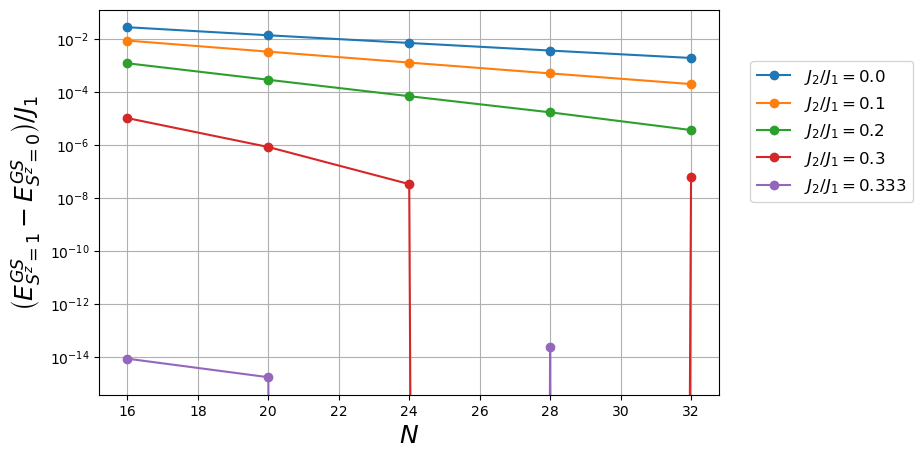

In [30]:
fig,ax = subplots(figsize=(8,5))
for i in 1:length(J2s)
    ax.plot(Ns,(E_1[:,i]-E_0[:,i]),"-o",label=L"$J_2/J_1=$"*string(round(J2s[i],digits=3)))
    # ax.plot(1 ./Ns,E_1[:,i]-E_0[:,i],"-o",label=L"$J_2/J_1=$"*string(round(J2s[i],digits=3)))
end
ax.legend(loc=(1.05,0.5),fontsize=12)
ax.set_xlabel(L"$N$", fontsize=18)
# ax.set_xticks(1 ./Ns)
# ax.set_xticklabels([L"1/" * string(N) for N in Ns ], fontsize=12)
ax.set_ylabel(L"\left(E^{GS}_{S^z=1}-E^{GS}_{S^z=0}\right)/J_1",fontsize=18)
# ax.set_xlim([0,1/16])
# ax.set_ylim([-0.6,0])
ax.set_yscale("log")
ax.grid()

gcf()

for $J_2/J_1 \geq 0.3$, it's practically gapless.

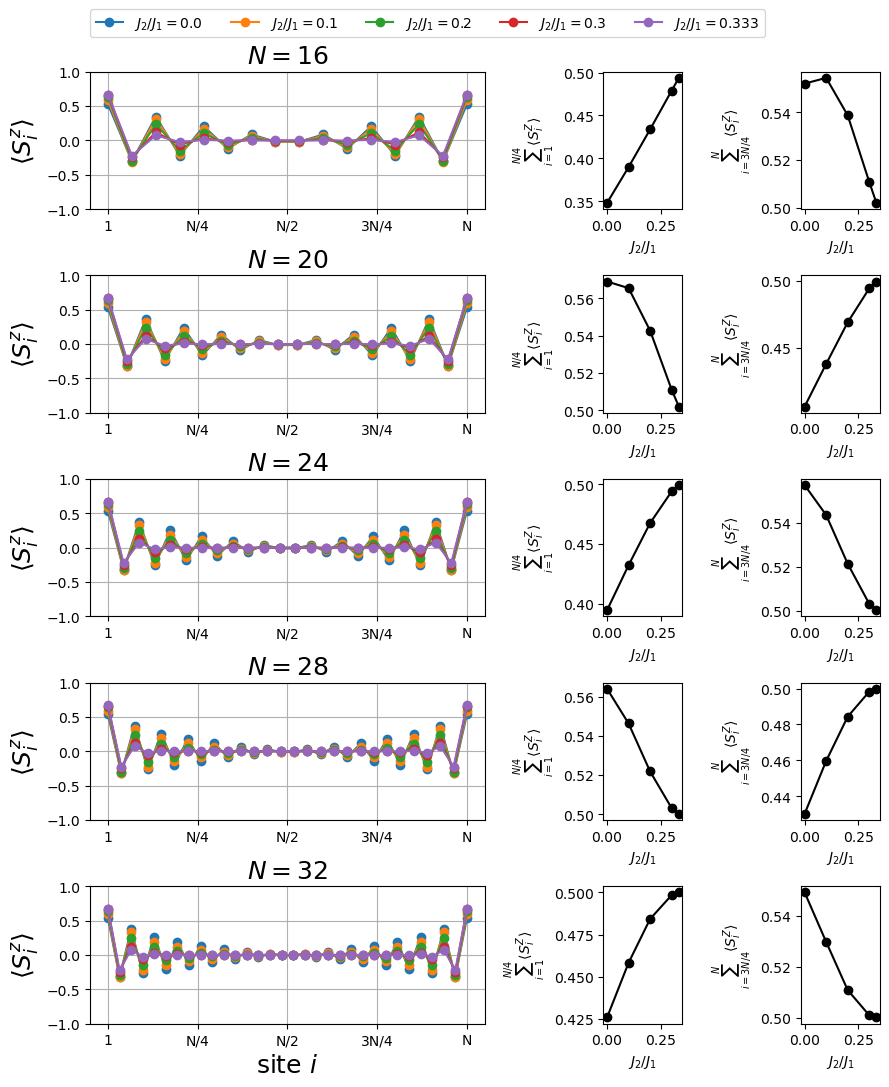

In [117]:
fig,ax = subplots(length(Ns),3,figsize=(9,11),gridspec_kw=Dict("width_ratios" => [5, 1,1]))

for (i,N) in enumerate(Ns)
    left_Sz = []
    right_Sz = []
    for (j,J2) in enumerate(J2s)
        # LinRange(0,1,N)
        ax[i,1].plot(LinRange(0,1,N),expect(psis[j+(i-1)*length(Ns)],"Sz"),"-o",label=L"J_2/J_1="*string(round(J2,digits=3)))
        append!(left_Sz,sum(expect(psis[j+(i-1)*length(Ns)],"Sz")[1:div(N,4)]))
        append!(right_Sz,sum(expect(psis[j+(i-1)*length(Ns)],"Sz")[3*div(N,4):N]))
    end
    ax[i,1].set_ylabel(L"$\langle S^z_i \rangle$", fontsize=18)
    ax[i,1].set_xticks(0:0.25:1)
    ax[i,1].set_xticklabels(["1","N/4","N/2","3N/4","N"])
    ax[i,1].set_title(L"$N=$"*string(N),fontsize=18)
    ax[i,1].set_ylim([-1,1])
    ax[i,1].grid()
    
    ax[i,2].plot(J2s,left_Sz,"-o",color="black")
    ax[i,2].set_xlabel(L"$J_2/J_1$")
    ax[i,2].set_ylabel(L"$\sum_{i=1}^{N/4}\langle S^Z_i \rangle$")

    ax[i,3].plot(J2s,right_Sz,"-o",color="black")
    ax[i,3].set_xlabel(L"$J_2/J_1$")
    ax[i,3].set_ylabel(L"$\sum_{i=3N/4}^N \langle S^Z_i \rangle$")
    # ax[i,2].set_yticks([])
end

ax[5,1].set_xlabel(L"site $i$", fontsize=18)
ax[1,1].legend(loc=(0,1.25),ncol=5)
fig.tight_layout(w_pad=-15) 
gcf()